### parametric case

特点:  
1,不使用任何扰动

In [1]:
import jax
import jax.numpy as jnp
import jax_cfd.base as cfd
import numpy as np
import seaborn
import xarray
import functools
import copy

from jax_cfd_test import my_equations
from jax_cfd_test import my_funcutils
from jax_cfd_test import my_forcing

from flax import linen as nn
from jax import random
from jax import grad
from jax.scipy.linalg import inv, det
from jax.scipy.optimize import minimize

import optax

import time
import matplotlib.pyplot as plt

from flax.traverse_util import flatten_dict, unflatten_dict

In [2]:
jax.devices()

[cuda(id=0)]

In [3]:
def sealed_convection_diffusion_true(measure_point_coordinate, center, stage):
    grid = cfd.grids.Grid((size, size), domain=((lo_b, up_b), (lo_b, up_b)))

    bc = cfd.boundaries.neumann_boundary_conditions(2)
    
    grid_x = jnp.linspace(lo_b, up_b, size)
    grid_y = jnp.linspace(lo_b, up_b, size)
    xx, yy = jnp.meshgrid(grid_x, grid_y, indexing='ij')
    
    distance_array = 0.0*xx
    array = cfd.grids.GridArray(distance_array, offset=grid.cell_center, grid=grid)
    v0 = cfd.grids.GridVariable(array, bc)
    G=(v0,v0)

    time=0.0
    dt= 0.0005
    center_x= center[0]
    center_y= center[1]
    
    i = (measure_point_coordinate[0]-lo_b)/(up_b-lo_b)*(size-1)
    j = (measure_point_coordinate[1]-lo_b)/(up_b-lo_b)*(size-1)
    
    inner_steps = 1
    outer_steps = (stage+1)*100+1#401

    # model = my_forcing.FullyConnectedNN()  # 创建模型实例 在外侧定义，只是一个结构

    #rollout_fn = jax.jit(my_funcutils.trajectory(my_equations.implicit_convection_diffusion3(
    #        density=density, viscosity=viscosity, dt=dt, grid=grid, forcing = my_forcing.exponential_force_with_nn(grid,center_x=center_x, center_y=center_y,params=param,model =model)), outer_steps*inner_steps))
  
    rollout_fn = jax.jit(my_funcutils.trajectory(my_equations.implicit_convection_diffusion3(
            density=density, viscosity=viscosity, dt=dt, grid=grid, forcing = my_forcing.exponential_force(grid,center_x=center_x, center_y=center_y)), outer_steps*inner_steps))
   
    #_, trajectory = jax.device_get(rollout_fn(G,time))
    #data_array_at_last_step = trajectory[0][0].data[-1,:,:]

    last_step, _ = jax.device_get(rollout_fn(G,time))
    data_array_at_last_step = last_step[0][0].array.data
    
    data_fin=jax.scipy.ndimage.map_coordinates(data_array_at_last_step,[i,j],1)
    
    return data_fin, data_array_at_last_step
    
def sealed_convection_diffusion_nn(param, measure_point_coordinate, center, stage, model):
    grid = cfd.grids.Grid((size, size), domain=((lo_b, up_b), (lo_b, up_b)))

    bc = cfd.boundaries.neumann_boundary_conditions(2)
    
    grid_x = jnp.linspace(lo_b, up_b, size)
    grid_y = jnp.linspace(lo_b, up_b, size)
    xx, yy = jnp.meshgrid(grid_x, grid_y, indexing='ij')
    
    distance_array = 0.0*xx
    array = cfd.grids.GridArray(distance_array, offset=grid.cell_center, grid=grid)
    v0 = cfd.grids.GridVariable(array, bc)
    G=(v0,v0)

    time=0.0
    dt= 0.0005
    center_x= center[0]
    center_y= center[1]
    
    i = (measure_point_coordinate[0]-lo_b)/(up_b-lo_b)*(size-1)
    j = (measure_point_coordinate[1]-lo_b)/(up_b-lo_b)*(size-1)
    
    inner_steps = 1
    outer_steps = (stage+1)*100+1#401

    # model = my_forcing.FullyConnectedNN()  # 创建模型实例 在外侧定义，只是一个结构

    rollout_fn = jax.jit(my_funcutils.trajectory(my_equations.implicit_convection_diffusion3(
            density=density, viscosity=viscosity, dt=dt, grid=grid, forcing = my_forcing.reciprocal_force_with_nn(grid,center_x=center_x, center_y=center_y,params=param,model =model)), outer_steps*inner_steps))
  
    #rollout_fn = jax.jit(my_funcutils.trajectory(my_equations.implicit_convection_diffusion3(
     #       density=density, viscosity=viscosity, dt=dt, grid=grid, forcing = my_forcing.reciprocal_force(grid,center_x=center_x, center_y=center_y)), outer_steps*inner_steps))
   
    #_, trajectory = jax.device_get(rollout_fn(G,time))
    #data_array_at_last_step = trajectory[0][0].data[-1,:,:]

    last_step, _ = jax.device_get(rollout_fn(G,time))
    data_array_at_last_step = last_step[0][0].array.data
    
    data_fin=jax.scipy.ndimage.map_coordinates(data_array_at_last_step,[i,j],1)
    
    return data_fin, data_array_at_last_step
    
#%time jax.value_and_grad(sealed_convection_diffusion, has_aux=True)(params, (0.21,0.21),(0.203,0.21),stage=3)

def forward_epistemic_model(u,center,params,stage):
    '''
    用于kalmen方法的前进模型
    给定一个时刻的场,输出下一个时刻的场.时刻用stage标记.
    输出一个len=2的tuple.第一个元素是场的tuple,第二个元素是时间
    使用u[0][0].array.data提取数据

    stage是当前阶段的标记，当前阶段的样本x中的场是上一个阶段来的，因此前进模型的开始计算时间是上一个阶段的时间
    '''
    steps = 100
    
    dt= 0.0005
    grid = cfd.grids.Grid((size, size), domain=((lo_b, up_b), (lo_b, up_b)))
    
    center_x= center[0]
    center_y= center[1]

    rollout_fn = jax.jit(my_funcutils.trajectory(my_equations.implicit_convection_diffusion3(
            density=density, viscosity=viscosity, dt=dt, grid=grid, forcing = my_forcing.exponential_force_adjustable(grid,center_x=center_x, center_y=center_y, theta_s=params)), steps))

    time = stage*0.05

    last_step, _ = jax.device_get(rollout_fn(u,time))
    return last_step



def reconstruct_array_to_field(array):
    '''
    将一个方形数组（251*251）直接转化为一个场

    转化的方向步数很重要，因为这个场就是直接从tuple中提取的。
    '''
    grid = cfd.grids.Grid((size, size), domain=((lo_b, up_b), (lo_b, up_b)))
    bc = cfd.boundaries.neumann_boundary_conditions(2)
    grid_array = cfd.grids.GridArray(array, offset=grid.cell_center, grid=grid)
    v0 = cfd.grids.GridVariable(grid_array, bc)
    G=(v0,v0)
    return G

def get_tem_u_f(sample, d_start,center):
    tem_field = get_tem_field(sample)
    tem_param_dict = get_tem_param_dict(sample)
    return forward_epistemic_model(tem_field, center, tem_param_dict,params)

def get_y_f(tem_u_f, d_start):
    i = (d_start[0] - lo_b) / (up_b - lo_b) * (size - 1)
    j = (d_start[1] - lo_b) / (up_b - lo_b) * (size - 1)
    tem_u_f_data = tem_u_f[0][0].array.data
    return jax.scipy.ndimage.map_coordinates(tem_u_f_data, [i, j], order=1)


def get_tem_field(sample):
    sample_field = sample[:size*size].reshape(size,size)
    return reconstruct_array_to_field(sample_field)

def get_tem_param_dict(sample):
    sample_netparams = sample[size*size:]
    return sample_netparams


# 计算高斯分布的KLD
def gaussian_kld(mu_P, Sigma_P, mu_Q, Sigma_Q):
    if Sigma_Q.ndim == 0:
        # Sigma_Q 是一个标量，转换为 (1, 1) 矩阵
        Sigma_Q = Sigma_Q.reshape((1, 1))
        Sigma_P = Sigma_P.reshape((1,1))
    inv_Sigma_Q = inv(Sigma_Q)
    term1 = jnp.trace(inv_Sigma_Q @ Sigma_P)
    term2 = (mu_Q - mu_P).T @ inv_Sigma_Q @ (mu_Q - mu_P)
    term3 = jnp.log(det(Sigma_Q) / det(Sigma_P))
    k = len(mu_P)
    kld = 0.5 * (term1 + term2 - k + term3)
    return kld


def find_max_posterior_coordinates(posterior, grid_x_plot0, grid_y_plot0, size=3):
    # 找到posterior中最大元素的索引
    max_index = jnp.argmax(posterior)
    max_row, max_col = jnp.unravel_index(max_index, posterior.shape)

    # 选择最大元素附近的小区域
    def get_subgrid(matrix, center_row, center_col, size=3):
        half_size = size // 2
        return matrix[
            max(center_row - half_size, 0):min(center_row + half_size + 1, matrix.shape[0]),
            max(center_col - half_size, 0):min(center_col + half_size + 1, matrix.shape[1])
        ]

    sub_posterior = get_subgrid(posterior, max_row, max_col, size)
    sub_grid_x = get_subgrid(grid_x_plot0, max_row, max_col, size)
    sub_grid_y = get_subgrid(grid_y_plot0, max_row, max_col, size)

    # 二次插值函数
    def quadratic_interpolation(posterior_subgrid, x_subgrid, y_subgrid):
        # Flatten the subgrid for polynomial fitting
        x_flat = x_subgrid.flatten()
        y_flat = y_subgrid.flatten()
        z_flat = posterior_subgrid.flatten()
        
        # Polynomial fit (2nd order polynomial in 2 variables)
        A = jnp.column_stack([x_flat**2, y_flat**2, x_flat*y_flat, x_flat, y_flat, jnp.ones_like(x_flat)])
        coeffs, _, _, _ = jnp.linalg.lstsq(A, z_flat, rcond=None)
        
        # Define the polynomial
        def poly(x, y, coeffs):
            return coeffs[0]*x**2 + coeffs[1]*y**2 + coeffs[2]*x*y + coeffs[3]*x + coeffs[4]*y + coeffs[5]
        
        # Gradient of the polynomial
        grad_poly = grad(lambda xy: poly(xy[0], xy[1], coeffs))
        
        # Objective function: sum of squares of the gradient
        def objective(xy):
            g = grad_poly(xy)
            return jnp.sum(g**2)
        
        # Initial guess for the optimization
        x_init = jnp.array([x_flat.mean(), y_flat.mean()])
        
        # Find the critical point using minimize
        result = minimize(objective, x_init, method='BFGS')
        critical_point = result.x
        
        return critical_point

    max_x, max_y = quadratic_interpolation(sub_posterior, sub_grid_x, sub_grid_y)

    return jnp.array([max_x, max_y])

def sealed_convection_diffusion_exp_parametic(measure_point_coordinate, center, stage, theta_s):
    grid = cfd.grids.Grid((size, size), domain=((lo_b, up_b), (lo_b, up_b)))

    bc = cfd.boundaries.neumann_boundary_conditions(2)
    
    grid_x = jnp.linspace(lo_b, up_b, size)
    grid_y = jnp.linspace(lo_b, up_b, size)
    xx, yy = jnp.meshgrid(grid_x, grid_y, indexing='ij')
    
    distance_array = 0.0*xx
    array = cfd.grids.GridArray(distance_array, offset=grid.cell_center, grid=grid)
    v0 = cfd.grids.GridVariable(array, bc)
    G=(v0,v0)

    time=0.0
    dt= 0.0005
    center_x= center[0]
    center_y= center[1]
    
    i = (measure_point_coordinate[0]-lo_b)/(up_b-lo_b)*(size-1)
    j = (measure_point_coordinate[1]-lo_b)/(up_b-lo_b)*(size-1)
    
    inner_steps = 1
    outer_steps = (stage+1)*100+1#401

    # model = my_forcing.FullyConnectedNN()  # 创建模型实例 在外侧定义，只是一个结构

    #rollout_fn = jax.jit(my_funcutils.trajectory(my_equations.implicit_convection_diffusion3(
    #        density=density, viscosity=viscosity, dt=dt, grid=grid, forcing = my_forcing.exponential_force_with_nn(grid,center_x=center_x, center_y=center_y,params=param,model =model)), outer_steps*inner_steps))
  
    rollout_fn = jax.jit(my_funcutils.trajectory(my_equations.implicit_convection_diffusion3(
            density=density, viscosity=viscosity, dt=dt, grid=grid, forcing = my_forcing.exponential_force_adjustable(grid,center_x=center_x, center_y=center_y,theta_s=theta_s)), outer_steps*inner_steps))
   
    #_, trajectory = jax.device_get(rollout_fn(G,time))
    #data_array_at_last_step = trajectory[0][0].data[-1,:,:]

    last_step, _ = rollout_fn(G,time)#last_step, _ = jax.device_get(rollout_fn(G,time))
    data_array_at_last_step = last_step[0][0].array.data
    
    data_fin=jax.scipy.ndimage.map_coordinates(data_array_at_last_step,[i,j],1)
    #data_fin=jax.scipy.ndimage.map_coordinates(data_array_at_last_step,[j,i],1)
    
    return data_fin, data_array_at_last_step

In [4]:
# data_point, data_map = sealed_convection_diffusion_exp_parametic(jnp.array([0.0,0.2]), jnp.array([0.0,0.2]), 0, jnp.array([2.0]))
# 
# data_point
# 
# data_map.shape
# 
# measure_point_coordinate=jnp.array([0.0,0.2])
# i = (measure_point_coordinate[0]-lo_b)/(up_b-lo_b)*(size-1)
# print(i)
# j = (measure_point_coordinate[1]-lo_b)/(up_b-lo_b)*(size-1)
# print(j)
# jax.scipy.ndimage.map_coordinates(data_map,[i,j],1)
# 
# print(jnp.max(data_map))
# print(jnp.unravel_index(jnp.argmax(data_map), data_map.shape))
# 
# # 经过验证，原本的代码没有任何问题
# # 那么问题应该出在likelihood那里

Network Settings: 

learning_rate1 =  0.015
learning_rate2 =  [0.012 0.012 0.012 0.012 0.012 0.012 0.012 0.012 0.012 0.012 0.012 0.012
 0.012 0.012 0.012]
iteration_step_number1 =  (50, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40)
iteration_step_number2 =  (150, 150, 150, 150, 150, 150, 150, 150)

 stage =  0 

start learning design
start design :  [0.5 0.5]
Stopping iteration at step 17 as clip function has been activated 5 times.
Execution learning design time: 35.34560990333557 seconds
Current design: [0.44343537 0.3       ]
start optimazing design for model correction
observation =  0.52629185
estimated_center is  [0.41066667 0.27733335]
......................................................................................................................................................

design for model correction :  [0.44343537 0.3       ]
Execution learning param time: 202.03024196624756 seconds
current theta_s: [[1.9461329]]

 stage =  1 

start learni

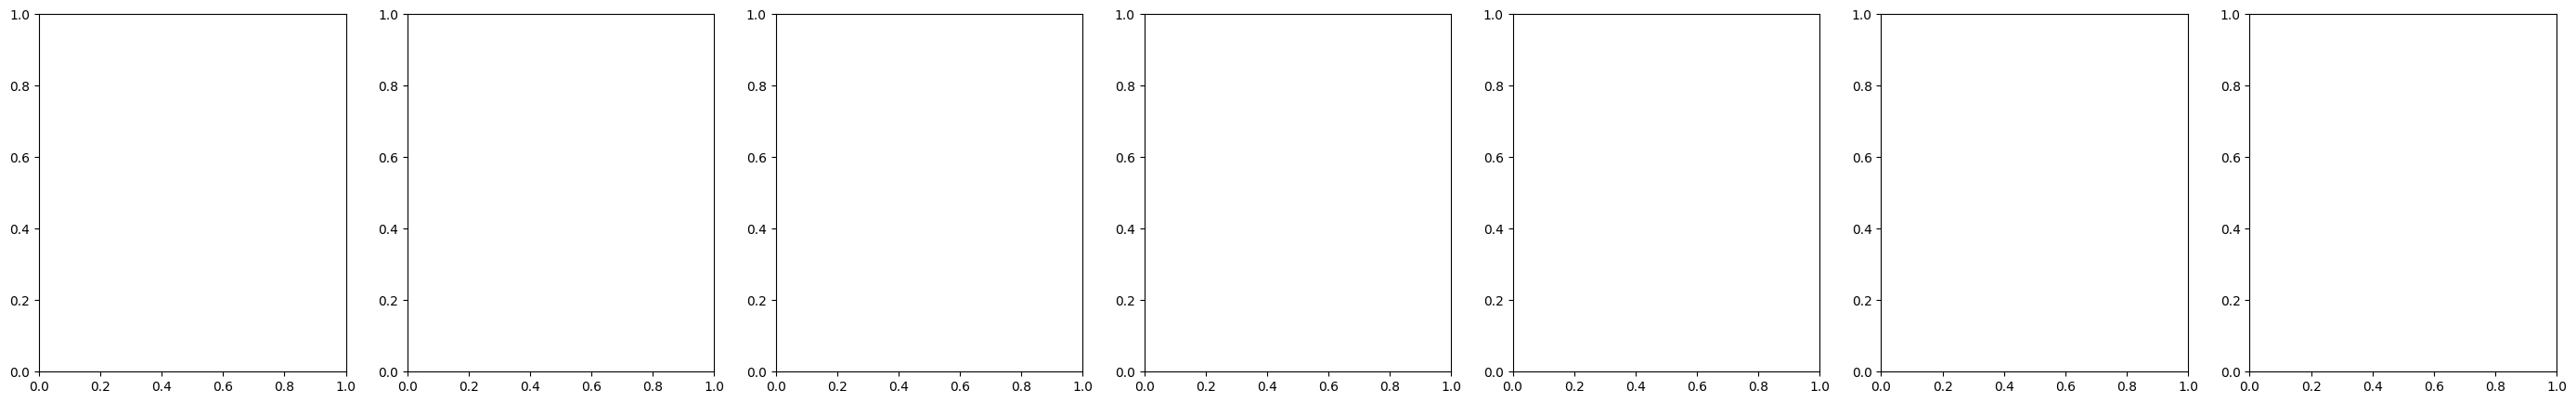

In [5]:
# 规划：
'''
1，涉及需要导数的过程都需要封装。因此 forward，likelihood，posterior，kld 都需要封装起来
2，其他的更新参数过程可以外方面
'''
def log_normalize_pdf(log_probs):
    # 计算最大对数概率值
    max_log_prob = jnp.max(log_probs)
    
    # 缩放并转换对数概率到概率空间，减少数值溢出风险
    probs = jnp.exp(log_probs - max_log_prob)
    
    # 归一化概率值
    normalized_probs = probs / jnp.sum(probs)
    
    # 转换回对数空间
    normalized_log_probs = jnp.log(normalized_probs+1e-32)
    
    return normalized_log_probs

def normalize_pdf(probs):
    return probs/jnp.sum(probs)

def calculate_loglikelihood(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, theta_true):
    '''
    参数：
    stage: 当前的阶段。用于决定forward模拟的步数
    center: 污染源的中心
    current_params: 网络的参数
    d_start: 测量点
    prior: 先验
    noise_info: 测量误差设置
    num_d: 计算后验时使用的点数
    radio_d: 在测量点附近多选几个点测量，本质上可以理解为多次测量消除误差，可以考虑直接舍弃误差

    说明：
    1，假设数据量是300*300，计算范围是3*3
    应该是需要数据尺寸是3的倍数，否则到时候后验那里也会费劲
    也可以不是3的倍数，只要后验矩阵和数据矩阵匹配就行
    2，运用了等效的原则。主要起作用的是测量点和center的相对位置
    这里突然想到nn应该需要四个参数，当前的坐标和center，而不是仅当前坐标。
    '''
    noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]
    if num_d == 1.0:
        #output_point, _ = sealed_convection_diffusion_true(d_start, center, stage) #这里的形状是()
        output_point, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
        #output_point = jax.lax.stop_gradient(output_point)
        #key, subkey = random.split(key) 这一步放在外面
        
        ##暂时只考虑不要误差的情况：
        observation = output_point + jnp.array([0.0])

        #这是要误差的代码：
        #noise = random.normal(key,(1,1))*(noise_base_scale+output_point*noise_ratio_scale) #形状(1,1)
        #observation = output_point + noise*0.1

        # 给一个函数，从所有的输出中找到关心的点
        false_center = jnp.array([1.0,1.0]) - d_start
        false_start = jnp.array([0.5, 0.5])
        #_, output_all = sealed_convection_diffusion_nn(current_params, false_start, false_center, stage, model)
        _, output_all  = sealed_convection_diffusion_exp_parametic(false_start, false_center, stage, current_params)
        #output_all_central_sym = output_all.T
        output_all_central_sym = jnp.fliplr(jnp.flipud(output_all))
        # 取出[0,1]^2之间的矩阵
        xb_lo = int((0.0 - lo_b) / (up_b - lo_b) * (size - 1))
        xb_up = int((1.0 - lo_b) / (up_b - lo_b) * (size - 1))
        output_for_xb = output_all_central_sym[xb_lo:(xb_up+1),xb_lo:(xb_up+1)]
        # 针对于每一个数字求likelihood
        #loglikelihood = jax.scipy.stats.norm.logpdf(output_for_xb, loc=observation, scale=noise_base_scale+noise_ratio_scale*observation)
        loglikelihood = jax.scipy.stats.norm.logpdf(observation, loc=output_for_xb, scale=noise_base_scale+noise_ratio_scale*output_for_xb)
    return loglikelihood, output_point

def calculate_info_gain(prior, posterior):
    '''
    KLD
    '''
    return jnp.sum(posterior*(jnp.log(posterior+1e-32) - jnp.log(prior+1e-32)))

def forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, theta_true):
    loglikelihood, measurement = calculate_loglikelihood(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, theta_true)
    log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
    evidence_list = jnp.exp(log_evidence_list)
    posterior = evidence_list/jnp.sum(evidence_list)
    KLD = calculate_info_gain(prior, posterior)
    return KLD, posterior, measurement

def compute_gradient_norm(grad_params):
    # 计算所有参数梯度的平方L2范数
    squared_norms = jax.tree_util.tree_map(lambda x: jnp.sum(x**2), grad_params)
    # 求和所有平方范数
    total_squared_norm = sum(jax.tree_util.tree_leaves(squared_norms))
    # 取平方根得到总的L2范数
    total_norm = jnp.sqrt(total_squared_norm)
    return total_norm

'''
main
'''

# 输入权重，求权重的导数

# PDE settings =================
size = 251  #只需要在 my_equation 里面改尺寸就可以了
local_size = int((size-1)/5+1)
density = 1.
viscosity = 1

lo_b = -2. #也需要在 my_equation 里面改范围
up_b = 3.


# OED settings =================
n_stage = 7
d_start = jnp.array([0.5,0.5])
center = jnp.array([0.45,0.25])

d_change_range = jnp.array([0.2,0.2])

noise_loc = 0
noise_base_scale = 0.05
noise_ratio_scale = 0.05
noise_info = [(noise_loc, noise_base_scale, noise_ratio_scale),]

num_d = 1.0
radio_d = 0.5

xb_size = int((size - 1)/5+1) #初始化均匀先验
prior_ori = jnp.ones((xb_size,xb_size))
prior = prior_ori/jnp.sum(prior_ori)

#key = random.split(key,int(n_stage*2+1))

'''
%time jax.value_and_grad(forward_posterior_infoGain_gradParam,has_aux=True)(params, d_start, stage, center, prior, noise_info, num_d, radio_d, key2)

d_start = jnp.array([0.7,0.7])
%time jax.value_and_grad(forward_posterior_infoGain_gradDesign,has_aux=True)(d_start, params, stage, center, prior, noise_info, num_d, radio_d, key2)

%time jax.value_and_grad(forward_posterior_infoGain_gradParam,has_aux=True)(params, d_start, stage, center, prior, noise_info, num_d, radio_d, key2)
'''

# 现在撰写主循环
# 只写一个步骤，从先验到后验和infogain，之后用scan的方式拼接

    


def loss_params_new(current_params, d_start, stage, center, noise_info, observation):
    noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]
    y_f, _ = sealed_convection_diffusion_exp_parametic(d_start, estimated_center, stage, current_params)
    loglikelihood = jax.scipy.stats.norm.logpdf(observation, loc=y_f, scale=noise_base_scale+noise_ratio_scale*jnp.abs(y_f))
    return -loglikelihood
    
# def f(a, b, c):
#     d = a * b + c
#     e = a * b - c
#     return d, e
# 
# a=1.0
# b=2.0
# c=3.0
# 
# jax.value_and_grad(f,has_aux=True)(a,b,c)

def calculate_loglikelihood_refine(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, theta_true, observation):
    '''
    参数：
    stage: 当前的阶段。用于决定forward模拟的步数
    center: 污染源的中心
    current_params: 网络的参数
    d_start: 测量点
    prior: 先验
    noise_info: 测量误差设置
    num_d: 计算后验时使用的点数
    radio_d: 在测量点附近多选几个点测量，本质上可以理解为多次测量消除误差，可以考虑直接舍弃误差

    说明：
    1，假设数据量是300*300，计算范围是3*3
    应该是需要数据尺寸是3的倍数，否则到时候后验那里也会费劲
    也可以不是3的倍数，只要后验矩阵和数据矩阵匹配就行
    2，运用了等效的原则。主要起作用的是测量点和center的相对位置
    这里突然想到nn应该需要四个参数，当前的坐标和center，而不是仅当前坐标。
    '''
    noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]
    if num_d == 1.0:
        # 给一个函数，从所有的输出中找到关心的点
        false_center = jnp.array([1.0,1.0]) - d_start
        false_start = jnp.array([0.5, 0.5])
        #_, output_all = sealed_convection_diffusion_nn(current_params, false_start, false_center, stage, model)
        _, output_all  = sealed_convection_diffusion_exp_parametic(false_start, false_center, stage, current_params)
        #output_all_central_sym = output_all.T
        output_all_central_sym = jnp.fliplr(jnp.flipud(output_all))
        # 取出[0,1]^2之间的矩阵
        xb_lo = int((0.0 - lo_b) / (up_b - lo_b) * (size - 1))
        xb_up = int((1.0 - lo_b) / (up_b - lo_b) * (size - 1))
        output_for_xb = output_all_central_sym[xb_lo:(xb_up+1),xb_lo:(xb_up+1)]
        # 针对于每一个数字求likelihood
        #loglikelihood = jax.scipy.stats.norm.logpdf(output_for_xb, loc=observation, scale=noise_base_scale+noise_ratio_scale*observation)
        loglikelihood = jax.scipy.stats.norm.logpdf(observation, loc=output_for_xb, scale=noise_base_scale+noise_ratio_scale*output_for_xb)
    return loglikelihood



def loss_design(d_start, current_params, stage, center, prior, noise_info, num_d, radio_d, key, theta_true):
    KLD, _, measurement = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, theta_true)
    return -KLD, measurement

# ======================================

iteration_step_number1 = tuple((50,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40))
iteration_step_number2 = tuple((150,150,150,150,150,150,150,150))
#tuple((200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200))#(150,50,60,70,70,90,110,70,70,70))#(10, 30, 40, 50, 50, 50, 50, 50, 50, 50))#
num_array = jnp.array([15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15])#jnp.array([33,30,27,24,21,18,15,12])

stage_to_skip = []

learning_rate1 = 0.015
#learning_rate2 = jnp.array([0.03,0.026,0.022,0.018,0.014,0.01,0.006])
#learning_rate2 = jnp.array([1,0.1,0.1,0.98,0.96,0.94,0.92,0.9 ])
#learning_rate2 = jnp.array([0.1,0.1,0.12,0.12,0.13,0.13,0.14,0.14])
learning_rate2 = 0.012*jnp.ones(15)
#learning_rate2 = (jnp.arange(0,10,1)/20+1.0)*0.007

#T0 = 1.0  # 初始温度
#alpha = 0.99  # 温度衰减系数
#step_size = 0.01  # 邻域步长

# ======================================


fig, axes = plt.subplots(1, n_stage, figsize=(5*n_stage, 5))
grid_x_plot0, grid_y_plot0 = np.meshgrid(np.linspace(0, 1, local_size), np.linspace(0, 1, local_size))


print('Network Settings: \n')
print(f'learning_rate1 = ', learning_rate1)
print(f'learning_rate2 = ', learning_rate2)
print(f'iteration_step_number1 = ', iteration_step_number1)
print(f'iteration_step_number2 = ', iteration_step_number2)

def create_decay_schedule(initial_lr, decay_steps, decay_rate):
    # 这里使用exponential_decay来创建学习率衰减计划
    lr_schedule = optax.exponential_decay(init_value=initial_lr,
                                          transition_steps=decay_steps,
                                          decay_rate=decay_rate,
                                          staircase=True)
    return lr_schedule
    
decay_rate1 = 1.0
decay_rate2 = 0.9  # 衰减率

learning_rate1_min = 0.001
learning_rate2_min = 0.001

lr_schedule1 = create_decay_schedule(learning_rate1, 20, decay_rate1)
#lr_schedule2 = create_decay_schedule(learning_rate2, 25, decay_rate2)
cosine_schedule1 = optax.cosine_decay_schedule(init_value=learning_rate1, decay_steps=20, alpha=learning_rate1_min)
cosine_schedule2 = optax.cosine_decay_schedule(init_value=learning_rate2[0], decay_steps=50, alpha=learning_rate2_min)


KLD_list=[]
evidence_list=[]
NN_error_list=[]
grad_list=[]
params_list=[]
params_at_stage_end_list=[]

average_theta_xy_list = []
params_detail_list=[]
design_list = []
design_list.append(d_start)
posterior_of_design_list = []
posterior_list = []

key1 = random.PRNGKey(2023)
key = random.split(key1,int(n_stage*2+1))

theta_true = jnp.array([2.0])
current_params = jnp.array([[3.0]])
params_back = copy.deepcopy(current_params)
params_at_stage_end_list.append(current_params)

len_params = 1

# 设置是否通过observation拒绝执行接下来的model correction
# observation_accumulate
counted_stage_list = []
ensemble_trajectory_list = []

# 设置停止的参数
loss_change_threshold = 0.01  # 损失变化阈值
window_size = 20  # 检查窗口大小
count_step_list = [] # 实际的每阶段步数

for stage in range(n_stage):
    print('\n stage = ', stage, '\n')
    key_for_design = random.split(key[stage*2],iteration_step_number1[stage])
    key_for_param = random.split(key[stage*2+1],iteration_step_number2[stage])
    
    clip_count = 0
    
    if stage!=0:
        del tx1
        
    #tx1 = optax.adam(lr_schedule1)
    tx1 = optax.chain(
    optax.adam(lr_schedule1),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
    optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
    )
    
    opt_state1 = tx1.init(d_start)
    
    d_limit_min = d_start - d_change_range
    d_limit_max = d_start + d_change_range
    
    start_time = time.time()
    d_start_backup = d_start

    print('start learning design')
    print(f'start design : ', d_start)

    index_of_oed = 0

    oed_design_measurement = []
    
    for i in range(iteration_step_number1[stage]):
        negtive_KLD, grad_design = jax.value_and_grad(loss_design, has_aux = True)(d_start, current_params, stage, center, prior, noise_info, num_d, radio_d, key_for_design[i], theta_true)
        updates, opt_state1 = tx1.update(grad_design, opt_state1, params=d_start)

        
        # 解决nan的问题
        updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
        if updates_contain_nans:
            print('NaN appears in learning. Perturb designs and continue')
            noise = 0.01*jax.random.normal(key_for_design[i], d_start.shape)
            d_start = d_start+ noise
        else:
            d_start = optax.apply_updates(d_start, updates)
    
        d_start_before_clip = d_start
        d_start = jnp.clip(d_start, d_limit_min, d_limit_max)
        
        # 如果clip函数生效，即有参数被裁剪，增加计数器
        if not jnp.all(d_start == d_start_before_clip):
            clip_count += 1
            
        index_of_oed += 1
        oed_design_measurement.append([d_start, negtive_KLD[1]])
        
        if clip_count >= 5:
            print(f"Stopping iteration at step {i} as clip function has been activated 5 times.")
            break
        
        if np.isnan(d_start).any() or np.isnan(negtive_KLD[0]).any():
            print('some results are Nan')
            break
    
        KLD_list.append(-negtive_KLD[0])
            
    end_time = time.time()
    print(f"Execution learning design time: {end_time - start_time} seconds")
    print(f"Current design: {d_start}")

    
    # ====== 如果下面是从0阶段就开始做model correction，那么这里需要从0阶段开始执行。如果下面跳过某些阶段，那么这里就跳过某些阶段。因为这里会和下面的更新后验的步骤重叠。
    if stage not in stage_to_skip:
        _, posterior, _ = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], theta_true)
        del prior
        prior = posterior

    design_list.append(d_start)
    posterior_of_design_list.append(prior)
    
    # model correction    
    start_time = time.time()
    print('start optimazing design for model correction')
    num_top = int(num_array[stage])

    ## 新的办法：只在开头进行一次测量，后面不测量了。节约一半的时间
    
    noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]
    output_point, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
    observation = output_point
    print('observation = ', observation)

    # 模块：判断数据怎么样
    # 先平均前两个阶段的测量值
    if stage == 0:
        observation_accumulate = observation
    elif stage == 1:
        observation_accumulate = (observation_accumulate + observation)/2.0*2.5/3.5
        print('observation_accumulate = ', observation_accumulate)
    
        
    # 后面的测量值如果太小，则缩小这一阶段的学习率
    if stage > 1 and observation_accumulate > observation:
        learning_rate_model_correction = learning_rate2[stage]*0.2#0.3
        print('observation is too small, reduce learning rate in this stage')
    else:
        learning_rate_model_correction = learning_rate2[stage]

    # 模块：计算估计后验点
    loglikelihood = calculate_loglikelihood_refine(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, theta_true, observation)
    log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
    indices = jnp.argpartition(log_evidence_list.ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)

    # 计算平均坐标
    average_x = np.mean(multi_indices[0])
    average_y = np.mean(multi_indices[1])

    estimated_center = jnp.array([average_x, average_y])/50
    print('estimated_center is ', estimated_center)

    
    counted_stage_list.append(1)
    nan_account = 0
    prev_loss = jnp.array([2.0])
    stable_loss_count = 0 
    count_step = 0
    

    # 设置优化器
    if stage!=0:
        del tx2
        del lr_schedule2
        
    lr_schedule2 = create_decay_schedule(learning_rate_model_correction, 10, 0.98)
    
    tx2 = optax.chain(
        optax.adam(lr_schedule2),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
        optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
    )

    opt_state2 = tx2.init(current_params)

    break_outer_cycle = 0
    
    for i in range(iteration_step_number2[stage]):
        if stage in stage_to_skip:
            print('this stage  dont learn error parameters')
            break
            
        current_params = round(current_params, 5)
        #loss_return, grad_params = jax.value_and_grad(loss_params_average_refine,has_aux=True)(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_for_param[i], theta_true, num_top, observation)
        if i == 0:
            loss_return, grad_params = jax.value_and_grad(loss_params_new)(current_params, d_start, stage, center, noise_info, observation)
        else:
            observation_perturbed = observation + jax.random.normal(key_for_param[i], observation.shape)*0.02*np.exp(-0.053*i)
            loss_return, grad_params = jax.value_and_grad(loss_params_new)(current_params, d_start, stage, center, noise_info, observation_perturbed)
        
        updates, opt_state2 = tx2.update(grad_params, opt_state2, params=current_params)

        updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
        
        if updates_contain_nans:
            #break_outer_cycle = 1
            #break
            noise = 0.001*jax.random.normal(key_for_param[i], current_params.shape)
            print('NaN appears in learning. Perturb params and continue. The previos theta_s is ',current_params,'. noise is ', noise)
            current_params = current_params+ noise
            #average_theta_xy_list.append(['nan'])
            nan_account += 1
        else:
            current_params = optax.apply_updates(current_params, updates)
            print('.',end='')
            nan_account = 0
            #average_theta_xy_list.append(loss_return[1])

        count_step += 1

        
                
        if nan_account > 6:
            print('break this stage as nan continue showing up more than 6 times')
            break

        if np.isnan(current_params).any():
            print('some results are Nan')
            break
            
            
        NN_error_list.append(loss_return)
        params_list.append(current_params)
        params_detail_list.append(grad_params)
            
        
        #if len(NN_error_list) >= 5:
        #    last_five = NN_error_list[-5:]
        #    if all(abs(last_five[0] - k) < 0.005*last_five[0] for k in last_five[1:]):
        #        print("连续5步的 NN error 几乎相同，停止循环")
        #        break  # 跳出循环

    if break_outer_cycle == 1:
        break
        
    count_step_list.append(count_step)
    print('\n')
    print('design for model correction : ', d_start)
    end_time = time.time()
    print(f"Execution learning param time: {end_time - start_time} seconds")
    print(f"current theta_s: {current_params}")
    params_at_stage_end_list.append(current_params)

    # 更新后验
    _, posterior, _ = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], theta_true)
    if stage!=0:
         del prior
    prior = posterior
    posterior_list.append(posterior)

    #if n_stage!=1:
    #    axes[stage].contourf(grid_x_plot0, grid_y_plot0, posterior.T, levels=100,cmap='RdYlBu_r' )
    #    axes[stage].scatter(d_start[0], d_start[1], marker='o', s=100, c='orangered')
    #    axes[stage].scatter(center[0], center[1], marker='*', s=100, c='magenta')
    #    axes[stage].plot([d_start[0],d_start_backup[0]],
    #                    [d_start[1],d_start_backup[1]], c='orangered')
    #    axes[stage].set_title(f'stage {stage}, t = {((stage+1)*0.05):.2f} s')  # 设置子图的标题
    #    axes[stage].set_xlim([0.3,0.5])  # 设置x轴标签
    #    axes[stage].set_ylim([0.15,0.35])  # 设置x轴标签
    #    axes[stage].set_xlabel('z_x')  # 设置x轴标签
    #    axes[stage].set_ylabel('z_y')  # 设置y轴标签
    #else:
    #    
    #    axes.contourf(grid_x_plot0, grid_y_plot0, posterior.T, levels=100,cmap='RdYlBu_r' )
    #    axes.scatter(d_start[0], d_start[1], marker='o', s=100, c='orangered')
    #    axes.scatter(center[0], center[1], marker='*', s=100, c='magenta')
    #    axes.plot([d_start[0],d_start_backup[0]],
    #                    [d_start[1],d_start_backup[1]], c='orangered')
    #    axes.set_title(f'stage {stage}, t = {((stage+1)*0.05):.2f} s')  # 设置子图的标题
    #    axes.set_xlabel('z_x')  # 设置x轴标签
    #    axes.set_ylabel('z_y')  # 设置y轴标签



#plt.tight_layout()  # 调整子图间距
#plt.savefig('myplot1.png')
#plt.show()

In [24]:
i=1
np.exp(-0.053*i)

0.9483800124822982

/tmp/ipykernel_249090/848167519.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  param_values = [float(p) for p in params_list]


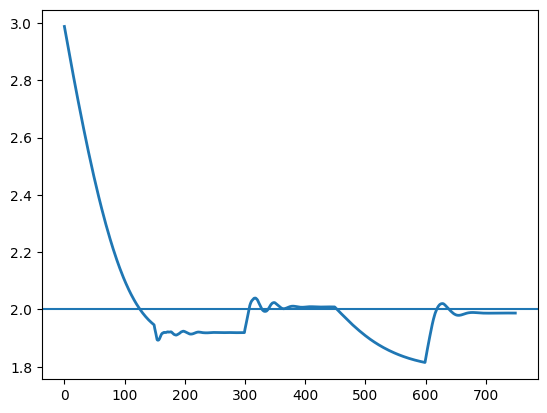

In [8]:
param_values = [float(p) for p in params_list] 

plt.plot(param_values[0:750], label='param', linewidth=2)
plt.axhline(2)

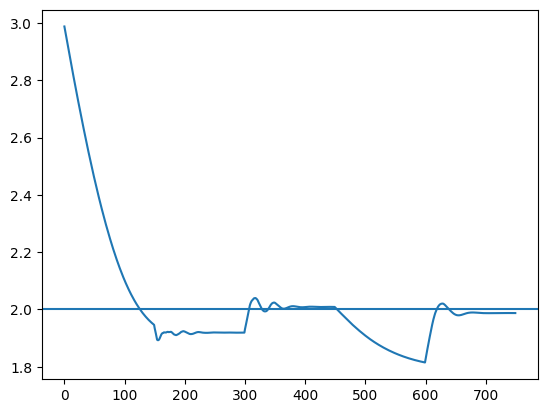

In [20]:
plt.plot(values[0:750])
plt.axhline(2)

In [18]:
np.exp(-10)

4.5399929762484854e-05

In [16]:
y_f, _ = sealed_convection_diffusion_exp_parametic(d_start, estimated_center, stage, current_params)
y_f

Array(0.7314184, dtype=float32)

In [23]:
def loss_params_new(current_params, d_start, stage, center, noise_info, observation):
    noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]
    y_f, _ = sealed_convection_diffusion_exp_parametic(d_start, estimated_center, stage, current_params)
    #loglikelihood = jax.scipy.stats.norm.logpdf(observation, loc=y_f, scale=noise_base_scale+noise_ratio_scale*jnp.abs(y_f))
    return -y_f

loss_return, grad_params = jax.value_and_grad(loss_params_new)(2.640504, d_start, stage, center, noise_info, observation)
grad_params

Array(-0.27699947, dtype=float32, weak_type=True)

In [14]:
# 更改了似然的计算方式，保存的数据

numpy_list = [np.array(arr) for arr in posterior_list]

# 保存数组到npz文件
np.savez("posterior_simple_case_seed_2023_final.npz", *numpy_list)


values = [item[0][0] for item in params_list]
np.savez("theta_s_trajectory_simple_case_seed_2023_final.npz", values, count_step_list, design_list, params_at_stage_end_list)

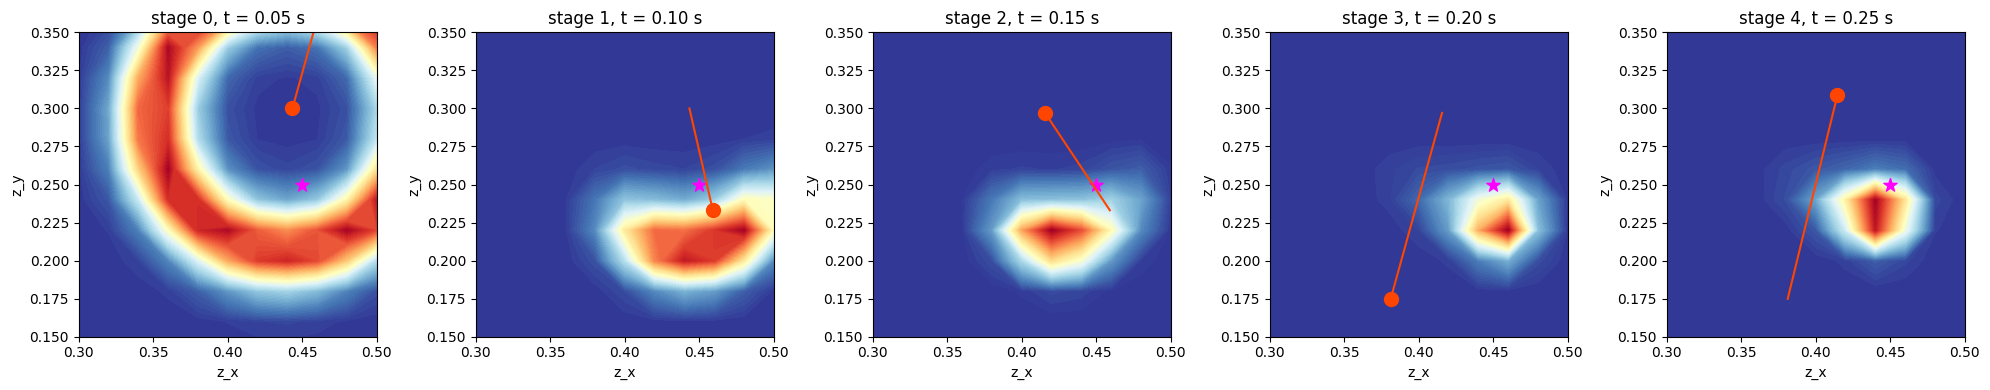

In [8]:
rows = (n_stage + 4) // 5  # 计算总行数，每行5个子图

# 创建子图
fig, axes = plt.subplots(rows, 5, figsize=(20, 4 * rows))
axes = axes.flatten()  # 将axes转换为1D数组，方便索引

# 遍历每个子图并绘制内容
for stage in range(n_stage):
    axes[stage].contourf(grid_x_plot0, grid_y_plot0, posterior_list[stage].T, levels=100, cmap='RdYlBu_r')
    axes[stage].scatter(design_list[stage+1][0], design_list[stage+1][1], marker='o', s=100, c='orangered')
    axes[stage].scatter(center[0], center[1], marker='*', s=100, c='magenta')
    axes[stage].plot([design_list[stage+1][0],design_list[stage][0]],
                    [design_list[stage+1][1],design_list[stage][1]], c='orangered')
    axes[stage].set_title(f'stage {stage}, t = {((stage+1)*0.05):.2f} s')  # 设置子图的标题
    axes[stage].set_xlim([0.3, 0.5])  # 设置x轴范围
    axes[stage].set_ylim([0.15, 0.35])  # 设置y轴范围
    axes[stage].set_xlabel('z_x')  # 设置x轴标签
    axes[stage].set_ylabel('z_y')  # 设置y轴标签

# 如果子图的总数不能被5整除，隐藏多余的空子图
for i in range(n_stage, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()  # 调整布局，使子图之间不重叠
plt.show()

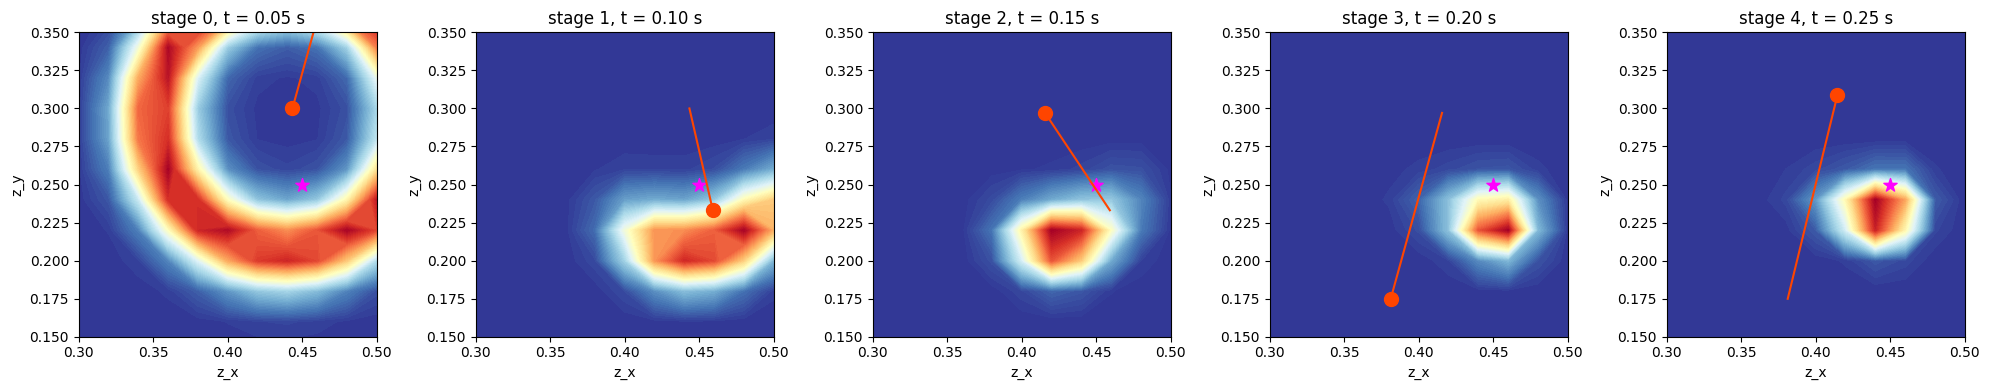

In [11]:
file_path = "posterior_simple_case_seed_2023_final.npz"

# 读取保存的数组
data = np.load(file_path)

posterior_list = [data[key] for key in ['arr_0', 'arr_1', 'arr_2', 'arr_3', 'arr_4', 'arr_5', 'arr_6']]

rows = (n_stage + 4) // 5  # 计算总行数，每行5个子图

# 创建子图
fig, axes = plt.subplots(rows, 5, figsize=(20, 4 * rows))
axes = axes.flatten()  # 将axes转换为1D数组，方便索引

# 遍历每个子图并绘制内容
for stage in range(n_stage):
    axes[stage].contourf(grid_x_plot0, grid_y_plot0, posterior_list[stage].T, levels=100, cmap='RdYlBu_r')
    axes[stage].scatter(design_list[stage+1][0], design_list[stage+1][1], marker='o', s=100, c='orangered')
    axes[stage].scatter(center[0], center[1], marker='*', s=100, c='magenta')
    axes[stage].plot([design_list[stage+1][0],design_list[stage][0]],
                    [design_list[stage+1][1],design_list[stage][1]], c='orangered')
    axes[stage].set_title(f'stage {stage}, t = {((stage+1)*0.05):.2f} s')  # 设置子图的标题
    axes[stage].set_xlim([0.3, 0.5])  # 设置x轴范围
    axes[stage].set_ylim([0.15, 0.35])  # 设置y轴范围
    axes[stage].set_xlabel('z_x')  # 设置x轴标签
    axes[stage].set_ylabel('z_y')  # 设置y轴标签

# 如果子图的总数不能被5整除，隐藏多余的空子图
for i in range(n_stage, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()  # 调整布局，使子图之间不重叠
plt.show()

In [10]:
posterior_list[-3][20:25,10:15]

array([[2.5340373e-04, 1.2533405e-02, 3.3708747e-02, 6.5414915e-03,
        2.3882891e-04],
       [3.0812246e-03, 7.7477157e-02, 1.0720529e-01, 1.1917379e-02,
        2.8740102e-04],
       [1.1400548e-02, 1.9191898e-01, 2.0647517e-01, 2.0723119e-02,
        4.5130003e-04],
       [6.3603250e-03, 1.0901780e-01, 1.4688273e-01, 2.0543918e-02,
        5.2302616e-04],
       [2.3023611e-04, 5.6766458e-03, 1.2871389e-02, 3.0153699e-03,
        9.3191265e-05]], dtype=float32)

In [16]:
posterior[20:25,10:15]

Array([[1.0975407e-06, 2.4109920e-04, 3.8174659e-03, 3.2583736e-03,
        2.5827912e-04],
       [1.8936548e-04, 1.8114241e-02, 8.6430043e-02, 1.9522797e-02,
        4.5305671e-04],
       [2.9780765e-03, 1.7249221e-01, 4.3544888e-01, 5.1537015e-02,
        6.0466840e-04],
       [9.6694136e-04, 5.2617233e-02, 1.3293152e-01, 1.6502237e-02,
        1.6588025e-04],
       [2.1923415e-06, 1.5124353e-04, 5.4802926e-04, 9.8180550e-05,
        1.0221173e-06]], dtype=float32)

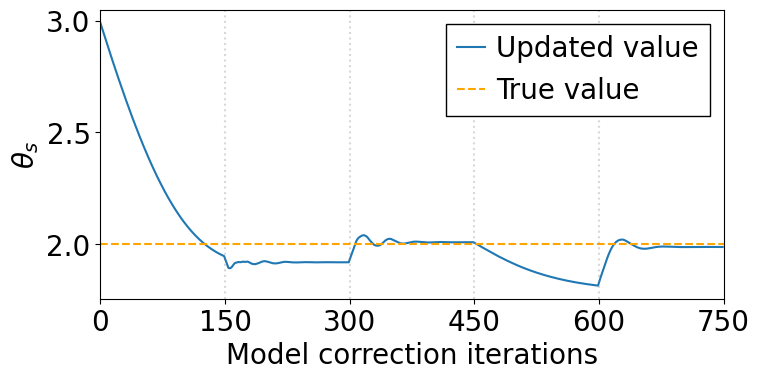

In [3]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

data = np.load("theta_s_trajectory_simple_case_seed_2023_final.npz")

# 读取数组
values = data['arr_0']

plt.figure(figsize=(8,4.2))
font_size = 20
plt.rc('font', size=font_size)
plt.plot(values[0:750],label='Updated value')
plt.axhline(2.0, linestyle='--', color='orange',label='True value')
for x in [150,300,450,600]:
    plt.axvline(x, linestyle=':',color='grey',alpha=0.3)
plt.xlim([0,750])
plt.xticks([0,150,300,450,600,750])
plt.xlabel('Model correction iterations')
plt.ylabel('$\\theta_s$')
plt.legend(
    frameon=True,
    framealpha=1,
    edgecolor='black',
    borderpad=0.4,
    handlelength=1,
    fancybox=False,  # 设置图例框为方形
    handletextpad=0.4  # 调整图标和文字之间的距离
)
plt.tight_layout()  # 调整子图间距
plt.savefig('theta_s_trajactory.png',dpi=300,bbox_inches='tight')
plt.show()

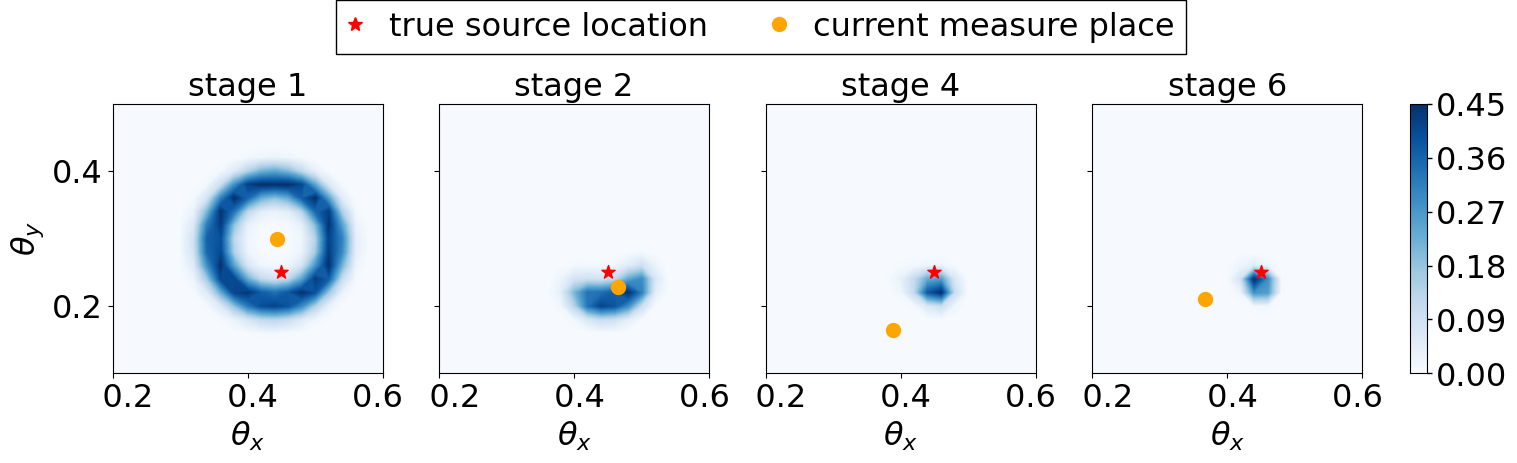

In [49]:
import numpy as np
import jax.numpy as jnp

# 定义文件路径
file_path = "posterior_simple_case_seed_2023_final.npz"

# 读取保存的数组
data = np.load(file_path)

posterior_list = [data[key] for key in ['arr_0', 'arr_1', 'arr_2', 'arr_3', 'arr_4', 'arr_5', 'arr_6']]



design_list = [
    np.array([0.5, 0.5]),
    np.array([0.44343537, 0.3       ]),
    np.array([0.46555826, 0.22801682]),
    np.array([0.40101224, 0.29114088]),
    np.array([0.38813758, 0.16375   ]),
    np.array([0.4379172 , 0.31866187]),
    np.array([0.36696267, 0.20959091]),
    np.array([0.42038932, 0.3137197 ])
]

n_stage =7
local_size = 51
center = jnp.array([0.45,0.25])

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.colors import LinearSegmentedColormap

#fig, axes = plt.subplots(1, 4, figsize=(5*4, 4.25))
fig, axes = plt.subplots(1, 4, figsize=(4.03*4, 3.5))
fig.subplots_adjust(wspace=0.21)

# fig.subplots_adjust(left = 0.05, right = 0.9, wspace=0.3)

grid_x_plot0, grid_y_plot0 = np.meshgrid(np.linspace(0, 1, local_size), np.linspace(0, 1, local_size))

def custom_formatter(x, pos):
    if x == 0.0:
        return '    0.0'  # 向右移动
    elif x == 1.0:
        return '1.0    '  # 向左移动
    else:
        return f'{x:.1f}'
        
fontsize = 23
pic_num=0

# 内置颜色图
cmap = 'Blues'#'PuBu'#'pink'#'GnBu'#'Greens'#
star_color = 'r'#'magenta'#'y'#'#F89054'#


def custom_formatter(x, pos):
    if x == 0.2:
        return '   0.2'  # 向右移动
    elif x == 0.8:
        return '0.8   '  # 向左移动
    elif x == 0.4:
        return ' 0.4'
    elif x == 0.6:
        return '0.6 '
    else:
        return f'{x:.2f}'


for stage in [0,1,3,5]:
    d_start = design_list[stage+1]
    d_start_backup = design_list[stage]
    contour=axes[pic_num].contourf(grid_x_plot0, grid_y_plot0, posterior_list[stage].T, levels=100,cmap=cmap)#plasma' )
    axes[pic_num].scatter(d_start[0], d_start[1], marker='o', s=100, c='orange')
    axes[pic_num].scatter(center[0], center[1], marker='*', s=100, c=star_color)
    #axes[pic_num].plot([d_start[0],d_start_backup[0]],[d_start[1],d_start_backup[1]], c='orangered')
    axes[pic_num].set_title(f'stage {stage+1}', fontsize=fontsize)  # 设置子图的标题
    axes[pic_num].set_xlabel('$\\theta_x$', fontsize=fontsize)  # 设置x轴标签
    axes[pic_num].set_yticks([0, 0.2,0.4,0.6])
    if stage == 0:
        axes[pic_num].set_ylabel('$\\theta_y$', fontsize=fontsize)  # 设置y轴标签
    else:
        axes[pic_num].set_yticklabels([]) 
        
    axes[pic_num].tick_params(axis='both', which='major', labelsize=fontsize)
    axes[pic_num].set_xticks([0.2,0.4,0.6,0.8])
    axes[pic_num].xaxis.set_major_formatter(FuncFormatter(custom_formatter))
    axes[pic_num].set_xlim([0.2,0.6])
    axes[pic_num].set_ylim([0.1,0.5])
    pic_num=pic_num+1

cbar_ax = fig.add_axes([0.93, 0.11, 0.01, 0.77])  # [left, bottom, width, height]
contour_set = plt.cm.ScalarMappable(cmap=cmap)#'plasma')
contour_set.set_array(posterior_list[stage])
contour_set.set_clim(0, 0.45)
ticks = [0, 0.09, 0.18, 0.27, 0.36, 0.45]
cbar = fig.colorbar(contour_set, cax=cbar_ax, orientation='vertical', shrink=0.4, aspect=20, pad=0.06)
cbar.ax.tick_params(labelsize=fontsize, width=1)
cbar.set_ticks(ticks)
cbar.update_ticks()

plt.plot([], [], marker='*', markersize=10, color=star_color, linestyle='None', label='true source location')
plt.plot([], [], marker='o', markersize=10, color='orange', linestyle='None', label='current measure place')
#plt.plot([], [], marker='*', markersize=10, color='magenta', linestyle='None', label='true parameter value')
legend = plt.legend(
    loc='center',
    bbox_to_anchor=(0.527, 1.1),  # 仅调整纵坐标位置，使其离上面远一点，离下面近一点
    ncol=3,
    frameon=True,
    framealpha=1,
    edgecolor='black',
    fontsize=fontsize,
    borderpad=0.05, handlelength=0.5,
    bbox_transform=fig.transFigure  # 将定位转换为相对于整个图形
)
legend.get_frame().set_edgecolor('black')  # 设置边框颜色为黑色
legend.get_frame().set_linewidth(1)  # 设置边框线宽为1
legend.get_frame().set_boxstyle("Square")
plt.savefig('less fig PDF_net_error_correction_update_params.png',bbox_inches='tight')

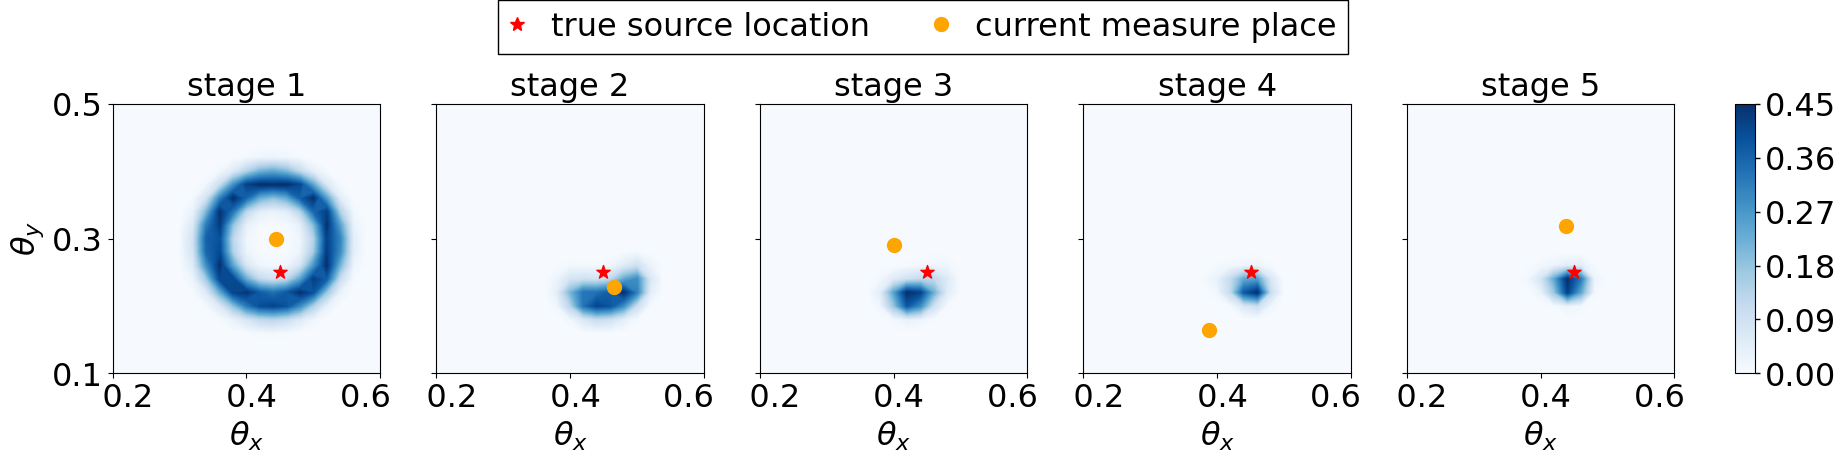

In [54]:
import numpy as np
import jax.numpy as jnp

# 定义文件路径
file_path = "posterior_simple_case_seed_2023_final.npz"

# 读取保存的数组
data = np.load(file_path)

posterior_list = [data[key] for key in ['arr_0', 'arr_1', 'arr_2', 'arr_3', 'arr_4', 'arr_5', 'arr_6']]



design_list = [
    np.array([0.5, 0.5]),
    np.array([0.44343537, 0.3       ]),
    np.array([0.46555826, 0.22801682]),
    np.array([0.40101224, 0.29114088]),
    np.array([0.38813758, 0.16375   ]),
    np.array([0.4379172 , 0.31866187]),
    np.array([0.36696267, 0.20959091]),
    np.array([0.42038932, 0.3137197 ])
]

n_stage =7
local_size = 51
center = jnp.array([0.45,0.25])

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.colors import LinearSegmentedColormap

fig, axes = plt.subplots(1, 5, figsize=(4.03*5, 3.5))
fig.subplots_adjust(wspace=0.21)

# fig.subplots_adjust(left = 0.05, right = 0.9, wspace=0.3)

grid_x_plot0, grid_y_plot0 = np.meshgrid(np.linspace(0, 1, local_size), np.linspace(0, 1, local_size))

        
fontsize = 23
pic_num=0

# 内置颜色图
cmap = 'Blues'#'PuBu'#'pink'#'GnBu'#'Greens'#
star_color = 'r'#'magenta'#'y'#'#F89054'#


def custom_formatter(x, pos):
    if x == 0.2:
        return '   0.2'  # 向右移动
    elif x == 0.6:
        return '0.6   '  # 向左移动
    elif x == 0.4:
        return ' 0.4'
    else:
        return f'{x:.2f}'


for stage in [0,1,2,3,4]:
    d_start = design_list[stage+1]
    d_start_backup = design_list[stage]
    contour=axes[pic_num].contourf(grid_x_plot0, grid_y_plot0, posterior_list[stage].T, levels=100,cmap=cmap)#plasma' )
    axes[pic_num].scatter(d_start[0], d_start[1], marker='o', s=100, c='orange')
    axes[pic_num].scatter(center[0], center[1], marker='*', s=100, c=star_color)
    #axes[pic_num].plot([d_start[0],d_start_backup[0]],[d_start[1],d_start_backup[1]], c='orangered')
    axes[pic_num].set_title(f'stage {stage+1}', fontsize=fontsize)  # 设置子图的标题
    axes[pic_num].set_xlabel('$\\theta_x$', fontsize=fontsize)  # 设置x轴标签
    axes[pic_num].set_yticks([0.1, 0.3,0.5])
    if stage == 0:
        axes[pic_num].set_ylabel('$\\theta_y$', fontsize=fontsize)  # 设置y轴标签
    else:
        axes[pic_num].set_yticklabels([]) 
        
    axes[pic_num].tick_params(axis='both', which='major', labelsize=fontsize)
    axes[pic_num].set_xticks([0.2,0.4,0.6])
    axes[pic_num].xaxis.set_major_formatter(FuncFormatter(custom_formatter))
    axes[pic_num].set_xlim([0.2,0.6])
    axes[pic_num].set_ylim([0.1,0.5])
    pic_num=pic_num+1

cbar_ax = fig.add_axes([0.93, 0.11, 0.01, 0.77])  # [left, bottom, width, height]
contour_set = plt.cm.ScalarMappable(cmap=cmap)#'plasma')
contour_set.set_array(posterior_list[stage])
contour_set.set_clim(0, 0.45)
ticks = [0, 0.09, 0.18, 0.27, 0.36, 0.45]
cbar = fig.colorbar(contour_set, cax=cbar_ax, orientation='vertical', shrink=0.4, aspect=20, pad=0.06)
cbar.ax.tick_params(labelsize=fontsize, width=1)
cbar.set_ticks(ticks)
cbar.update_ticks()

plt.plot([], [], marker='*', markersize=10, color=star_color, linestyle='None', label='true source location')
plt.plot([], [], marker='o', markersize=10, color='orange', linestyle='None', label='current measure place')
#plt.plot([], [], marker='*', markersize=10, color='magenta', linestyle='None', label='true parameter value')
legend = plt.legend(
    loc='center',
    bbox_to_anchor=(0.527, 1.1),  # 仅调整纵坐标位置，使其离上面远一点，离下面近一点
    ncol=3,
    frameon=True,
    framealpha=1,
    edgecolor='black',
    fontsize=fontsize,
    borderpad=0.05, handlelength=0.5,
    bbox_transform=fig.transFigure  # 将定位转换为相对于整个图形
)
legend.get_frame().set_edgecolor('black')  # 设置边框颜色为黑色
legend.get_frame().set_linewidth(1)  # 设置边框线宽为1
legend.get_frame().set_boxstyle("Square")
plt.savefig('simple case.png',bbox_inches='tight')

In [186]:
# 控制center不变

def forward_epistemic_model_from_initial(u,center,params,stage):
    '''
    用于kalmen方法的前进模型
    给定一个时刻的场,输出下一个时刻的场.时刻用stage标记.
    输出一个len=2的tuple.第一个元素是场的tuple,第二个元素是时间
    使用u[0][0].array.data提取数据

    stage是当前阶段的标记，当前阶段的样本x中的场是上一个阶段来的，因此前进模型的开始计算时间是上一个阶段的时间
    '''
    steps = 100*(stage+1)
    
    dt= 0.0005
    grid = cfd.grids.Grid((size, size), domain=((lo_b, up_b), (lo_b, up_b)))
    
    center_x= center[0]
    center_y= center[1]

    rollout_fn = jax.jit(my_funcutils.trajectory(my_equations.implicit_convection_diffusion3(
            density=density, viscosity=viscosity, dt=dt, grid=grid, forcing = my_forcing.exponential_force_adjustable(grid,center_x=center_x, center_y=center_y, theta_s=params)), steps))

    time = 0.0

    last_step, _ = rollout_fn(u,time)
    return last_step[0][0].data

def get_tem_u_f(sample, d_start,center):
    # 这个sample就是状态x
    tem_field = get_tem_field(sample)
    tem_param_dict = get_tem_param_dict(sample)
    return forward_epistemic_model(tem_field, center, tem_param_dict,params)

def get_y_f(tem_u_f, d_start):
    i = (d_start[0] - lo_b) / (up_b - lo_b) * (size - 1)
    j = (d_start[1] - lo_b) / (up_b - lo_b) * (size - 1)
    return jax.scipy.ndimage.map_coordinates(tem_u_f, [i, j], order=1)

def get_tem_field(sample):
    sample_field = sample[:size*size].reshape(size,size)
    return reconstruct_array_to_field(sample_field)

def get_tem_param_dict(sample):
    sample_netparams = sample[size*size:]
    return sample_netparams


def EnKF_process_fixCenter(d_start, estimated_center, observation, ensemble_member, stage, local_step):
    # 进行一次EnKF更新
    # 这个代码是不能够并行的

    # 生成初始状态的场
    # 直接在外面生成一个导入
    # 从这个场，用ensemble menber更新到现在

    # noise_info, lo_b, up_b, size, num_top 是全局变量
    
    ensemble_size_local = ensemble_member.shape[0]


    y_fs = jnp.zeros((ensemble_size_local,1))
    for i in range(ensemble_size_local):
        y_f, _  = sealed_convection_diffusion_exp_parametic(d_start, estimated_center, stage, ensemble_member[i])
        y_fs = y_fs.at[i,0].set(y_f)
    
    y_f_mean = jnp.mean(y_fs)
    P_yy = 1/(ensemble_size_local-1)*jnp.sum((y_fs-y_f_mean)**2)+1e-2#noise_base_scale

    x_f_theta = ensemble_member.reshape(ensemble_size_local,-1)
    x_f_mean = jnp.mean(x_f_theta, axis=0).reshape(1,-1)

    x_f_deviation = x_f_theta - x_f_mean
    y_f_deviation = y_fs - y_f_mean.reshape(1,1)
    P_xy = jnp.matmul(x_f_deviation.T, y_f_deviation) / (ensemble_size_local - 1) 

    K = P_xy * 1.0/P_yy
    x_a = x_f_theta + 0.5*jnp.matmul(K, (observation - y_fs).T).T
    
    x_a_mean = np.mean(x_a, axis=0)
    inflation_factor = 1.1#*0.985**local_step # 或其他合适的值
    x_a = x_a_mean + inflation_factor * (x_a - x_a_mean) # 膨胀因子
    
    theta_samples_updated = x_a[:, -1]
    return theta_samples_updated




data = np.load("theta_s_trajectory_simple_case_seed_2023_final.npz")

# 读取数组
values = data['arr_0']
count_step_list = data['arr_1']
design_list = data['arr_2']
params_at_stage_end_list = data['arr_3']
del data

data = np.load("posterior_simple_case_seed_2023_final.npz")
#data = np.load("posterior_simple_case_seed_812.npz")

# 由于保存时使用了无名参数，加载后的数据将用'arr_0', 'arr_1'等键来访问
loaded_list = [data[f'arr_{i}'] for i in range(n_stage)]
del data

stage = 3

step = 10
sample_size = 30#15
current_params = params_at_stage_end_list[stage]
#ensemble_params = (current_params+jnp.arange(0,sample_size)*jnp.array([0.2])).reshape(sample_size)

d_start = design_list[stage+1]
prior = loaded_list[stage-1]

_, posterior, observation = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], theta_true)
prior = posterior
del posterior


noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]
false_center = jnp.array([1.0,1.0]) - d_start
false_start = jnp.array([0.5, 0.5])
_, output_all  = sealed_convection_diffusion_exp_parametic(false_start, false_center, stage, current_params)
output_all_central_sym = jnp.fliplr(jnp.flipud(output_all))
xb_lo = int((0.0 - lo_b) / (up_b - lo_b) * (size - 1))
xb_up = int((1.0 - lo_b) / (up_b - lo_b) * (size - 1))
output_for_xb = output_all_central_sym[xb_lo:(xb_up+1),xb_lo:(xb_up+1)]
loglikelihood = jax.scipy.stats.norm.logpdf(output_for_xb, loc=observation, scale=noise_base_scale+noise_ratio_scale*observation)
log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
indices = jnp.argpartition(log_evidence_list.ravel(), -15)[-15:]
multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)
average_x = np.mean(multi_indices[0])/50
average_y = np.mean(multi_indices[1])/50
estimated_center = np.array([average_x, average_y])
print('estimated_center is ', estimated_center)

d_start1 = design_list[stage+1]#jnp.array([0.35, 0.15])
d_start2 = jnp.array([0.41, 0.26])
key_ensemble = jax.random.PRNGKey(2023)

for j in range(2):
    if j==0:
        d_start = d_start1
    elif j==1:
        d_start = d_start2
    
    prior = loaded_list[stage-1]
    observation, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
    
    current_params = params_at_stage_end_list[stage]
    ensemble_params = (current_params+jax.random.normal(key_ensemble, shape=(sample_size,))).squeeze()#(jnp.array([1.0])+jnp.arange(0,sample_size)*jnp.array([0.2])).reshape(sample_size)
    
    
    
    params_trajectory = np.zeros((step+1,sample_size))
    params_trajectory[0,:] = ensemble_params
    

    for i in range(step):
        ensemble_params =EnKF_process_fixCenter(d_start, estimated_center, observation, ensemble_params, stage, i)
        params_trajectory[i+1,:]=ensemble_params
        print('-',end='')

    if j==0:
        params_trajectory_bad_design = params_trajectory
    elif j==1:
        params_trajectory_good_design = params_trajectory

    print('|',end='')

estimated_center is  [0.4506667  0.23066667]
----------|----------|

In [180]:
params_at_stage_end_list[stage]

array([[2.0087016]], dtype=float32)

In [203]:
np.savez("EKI_results_simple_case_seed_2023_final.npz", params_trajectory_bad_design, params_trajectory_good_design)
# 可以通过给初始误差乘以2实现其他的图像

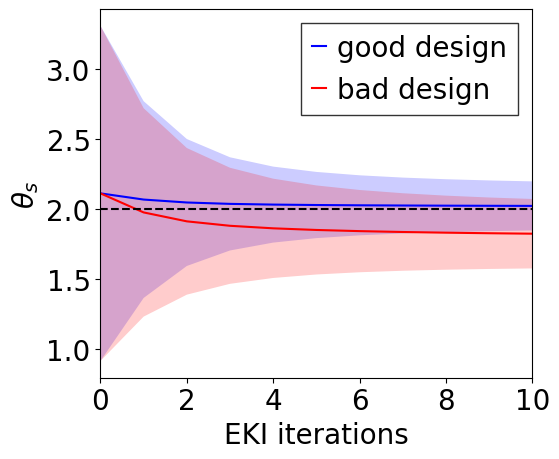

In [187]:
font_size = 20


plt.rc('font', size=font_size)

plt.figure(figsize=(6, 5))
#for i in range(sample_size):
#    axes[0].plot(params_trajectory_bad_design[:,i],color='r',label='bad design')
#    axes[0].plot(params_trajectory_good_design[:,i],color='b',label='good design')
#    if i==0:
#        axes[0].legend()

mean_values_bad_design = np.mean(params_trajectory_bad_design, axis=1)
variance_values_bad_design = np.var(params_trajectory_bad_design, axis=1)
mean_values_good_design = np.mean(params_trajectory_good_design, axis=1)
variance_values_good_design = np.var(params_trajectory_good_design, axis=1)

plt.plot(mean_values_good_design,color='b',label='good design')
plt.fill_between(range(step+1),mean_values_good_design+np.sqrt(variance_values_good_design),mean_values_good_design-np.sqrt(variance_values_good_design),color='b',alpha=0.2, edgecolor='none')
plt.plot(mean_values_bad_design,color='r',label='bad design')
plt.fill_between(range(step+1),mean_values_bad_design+np.sqrt(variance_values_bad_design),mean_values_bad_design-np.sqrt(variance_values_bad_design),color='r',alpha=0.2, edgecolor='none')
plt.xlabel('EKI iterations')
plt.ylabel('$\\theta_s$')
plt.xlim([0,10])

plt.axhline(theta_true, linestyle='--', color='black')
plt.legend(fontsize=font_size,
    frameon=True,
    framealpha=0.8,
    edgecolor='black',
    borderpad=0.4,
    handlelength=0.5,
    fancybox=False,  # 设置图例框为方形
    handletextpad=0.4  # 调整图标和文字之间的距离
)
plt.tight_layout()  # 调整子图间距
#plt.savefig('theta_s_trajactory.png',dpi=300,bbox_inches='tight')
plt.show()

In [6]:
data

NpzFile 'EKI_results_simple_case_seed_2023_final.npz' with keys: arr_0, arr_1

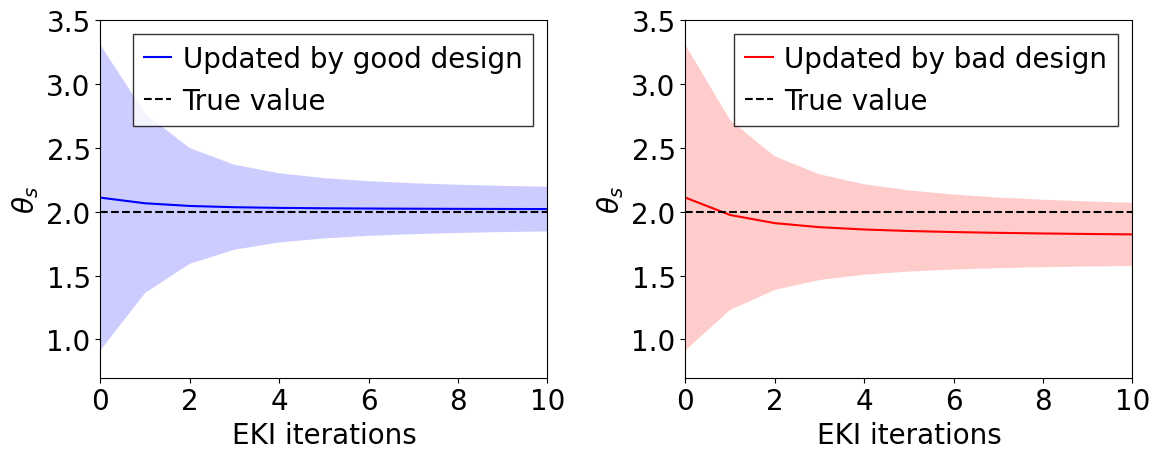

In [16]:
font_size = 20

plt.rc('font', size=font_size)

data = np.load("EKI_results_simple_case_seed_2023_final.npz")
step = 10
theta_true = 2.0

# 读取数组
params_trajectory_bad_design = data['arr_0']
params_trajectory_good_design = data['arr_1']


fig, axes = plt.subplots(1,2,figsize=(12, 5))
#for i in range(sample_size):
#    axes[0].plot(params_trajectory_bad_design[:,i],color='r',label='bad design')
#    axes[0].plot(params_trajectory_good_design[:,i],color='b',label='good design')
#    if i==0:
#        axes[0].legend()

mean_values_bad_design = np.mean(params_trajectory_bad_design, axis=1)
variance_values_bad_design = np.var(params_trajectory_bad_design, axis=1)
mean_values_good_design = np.mean(params_trajectory_good_design, axis=1)
variance_values_good_design = np.var(params_trajectory_good_design, axis=1)

axes[0].plot(mean_values_good_design,color='b',label='Updated by good design')
axes[0].fill_between(range(step+1),mean_values_good_design+np.sqrt(variance_values_good_design),mean_values_good_design-np.sqrt(variance_values_good_design),color='b',alpha=0.2, edgecolor='none')
axes[1].plot(mean_values_bad_design,color='r',label='Updated by bad design')
axes[1].fill_between(range(step+1),mean_values_bad_design+np.sqrt(variance_values_bad_design),mean_values_bad_design-np.sqrt(variance_values_bad_design),color='r',alpha=0.2, edgecolor='none')

axes[0].set_xlabel('EKI iterations')
axes[0].set_ylabel('$\\theta_s$')
axes[0].set_xlim([0,10])
axes[0].set_ylim([0.7,3.5])
axes[1].set_xlabel('EKI iterations')
axes[1].set_ylabel('$\\theta_s$')
axes[1].set_xlim([0,10])
axes[1].set_ylim([0.7,3.5])

axes[0].axhline(theta_true, linestyle='--', color='black', label='True value')
axes[0].legend(fontsize=font_size,
    frameon=True,
    framealpha=0.8,
    edgecolor='black',
    borderpad=0.4,
    handlelength=1.0,
    fancybox=False,  # 设置图例框为方形
    handletextpad=0.4  # 调整图标和文字之间的距离
)
axes[1].axhline(theta_true, linestyle='--', color='black', label='True value')
axes[1].legend(fontsize=font_size,
    frameon=True,
    framealpha=0.8,
    edgecolor='black',
    borderpad=0.4,
    handlelength=1.0,
    fancybox=False,  # 设置图例框为方形
    handletextpad=0.4  # 调整图标和文字之间的距离
)
plt.tight_layout()  # 调整子图间距
plt.savefig('EKI_simple_case.png',dpi=300,bbox_inches='tight')
plt.show()

In [190]:
np.sqrt(variance_values_good_design),np.sqrt(variance_values_bad_design)

(array([1.19529693, 0.70161947, 0.45266049, 0.3322458 , 0.27093872,
        0.23602225, 0.21405929, 0.19921534, 0.18866112, 0.18087855,
        0.17498378]),
 array([1.19529693, 0.74306762, 0.52285524, 0.41385015, 0.35405773,
        0.3175382 , 0.29336476, 0.27642888, 0.26407338, 0.25478893,
        0.24765622]))

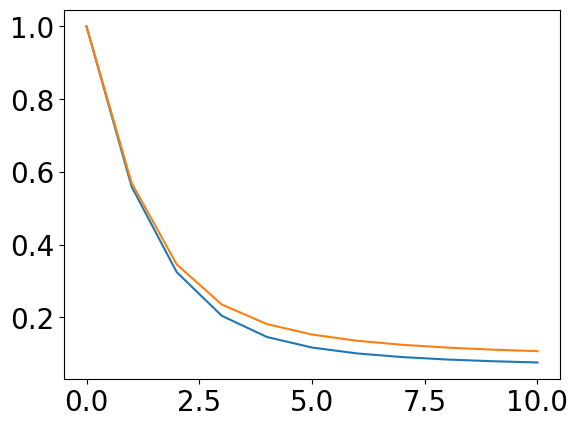

In [168]:
plt.plot(np.sqrt(variance_values_good_design)/np.sqrt(variance_values_good_design)[0])
plt.plot(np.sqrt(variance_values_bad_design)/np.sqrt(variance_values_bad_design)[0])

In [134]:
variance_values_good_design[-1],variance_values_bad_design[-1]

(0.01904657068981472, 0.038997685547403134)

In [101]:
sealed_convection_diffusion_exp_parametic(d_start1, center, stage, theta_true)[0],sealed_convection_diffusion_exp_parametic(d_start1, estimated_center, stage, theta_true)[0]

(Array(0.38188225, dtype=float32), Array(0.42503494, dtype=float32))

In [ ]:
d_start2 = jnp.array([0.39, 0.35])
_,y0 = sealed_convection_diffusion_exp_parametic(d_start2, center, stage, theta_true)
_,y1 = sealed_convection_diffusion_exp_parametic(d_start2, estimated_center, stage, theta_true)
percentage = ((y1[100:151,100:151]-y0[100:151,100:151])/y0[100:151,100:151]).T

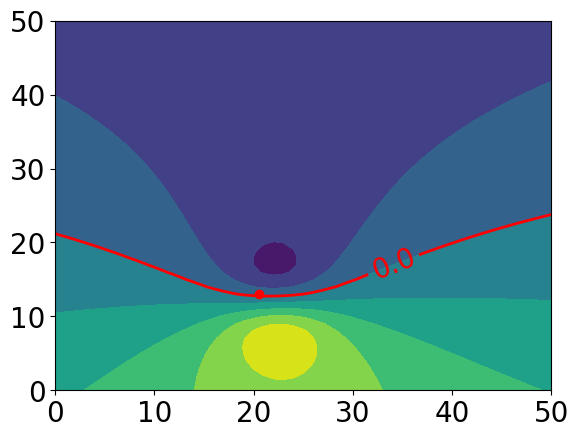

In [129]:
plt.contourf(percentage)
contour = plt.contour(percentage, levels=[-0.5, 0, 0.15], colors='red', linewidths=2)

# 添加等高线的标签 (可选)
plt.clabel(contour, fmt='%1.1f')
d_start2 = jnp.array([0.41, 0.26])*50

plt.scatter(d_start2[0], d_start2[1], marker='o', color='r')

In [132]:
d_start2 = jnp.array([0.41, 0.26])
y0,_ = sealed_convection_diffusion_exp_parametic(d_start2, center, stage, theta_true)
y1,_ = sealed_convection_diffusion_exp_parametic(d_start2, estimated_center, stage, theta_true)
(y1-y0)/y0

Array(-0.00733666, dtype=float32)

In [89]:
estimated_center

array([0.44533336, 0.228     ], dtype=float32)

In [76]:
design_list

[array([0.5, 0.5]),
 array([0.44343537, 0.3       ]),
 array([0.46555826, 0.22801682]),
 array([0.40101224, 0.29114088]),
 array([0.38813758, 0.16375   ]),
 array([0.4379172 , 0.31866187]),
 array([0.36696267, 0.20959091]),
 array([0.42038932, 0.3137197 ])]

In [6]:
numpy_list = [np.array(arr) for arr in posterior_list]

# 保存数组到npz文件
#np.savez("posterior_simple_case_seed_2022.npz", *numpy_list)
np.savez("posterior_simple_case_seed_812.npz", *numpy_list)

In [6]:
data = np.load("posterior_simple_case_seed_2022.npz")
#data = np.load("posterior_simple_case_seed_812.npz")

# 由于保存时使用了无名参数，加载后的数据将用'arr_0', 'arr_1'等键来访问
loaded_list = [data[f'arr_{i}'] for i in range(n_stage)]

In [9]:
params_at_stage_end_list

array([[[3.       ]],

       [[1.8748358]],

       [[1.9140682]],

       [[2.033071 ]],

       [[1.8540454]],

       [[1.9648844]],

       [[1.7766172]],

       [[2.0042126]],

       [[1.7066988]]], dtype=float32)

In [ ]:
# seed = 2022

In [6]:
# 使用ensemble算多个

data = np.load("theta_s_trajectory_simple_case_seed_2022.npz")

# 读取数组
values = data['arr_0']
count_step_list = data['arr_1']
design_list = data['arr_2']
params_at_stage_end_list = data['arr_3']
del data

data = np.load("posterior_simple_case_seed_2022.npz")
#data = np.load("posterior_simple_case_seed_812.npz")

# 由于保存时使用了无名参数，加载后的数据将用'arr_0', 'arr_1'等键来访问
loaded_list = [data[f'arr_{i}'] for i in range(n_stage)]
del data


size = 251  #只需要在 my_equation 里面改尺寸就可以了
local_size = int((size-1)/5+1)
density = 1.
viscosity = 1

lo_b = -2. #也需要在 my_equation 里面改范围
up_b = 3.

max_velocity = 2.0
cfl_safety_factor = 0.5


#key = random.PRNGKey(0)  # 随机数生成器的键
#x_for_shape = random.normal(key, (1, 2))  # 假设输入数据形状为 (batch_size, input_features)，这里是一个样本，两个特征
#model = my_forcing.FullyConnectedNN()  # 创建模型实例
#params = model.init(key, x_for_shape)




# OED settings =================
n_stage = 8
d_start = jnp.array([0.5,0.5])
center = jnp.array([0.45,0.25])

d_change_range = jnp.array([0.2,0.2])

noise_loc = 0
noise_base_scale = 0.05
noise_ratio_scale = 0.05
noise_info = [(noise_loc, noise_base_scale, noise_ratio_scale),]
num_top = 15

num_d = 1.0
radio_d = 0.5

xb_size = int((size - 1)/5+1) #初始化均匀先验
prior_ori = jnp.ones((xb_size,xb_size))
prior = prior_ori/jnp.sum(prior_ori)

for stage in [5]:
    current_params = params_at_stage_end_list[stage]
    d_start = design_list[stage+1]
    output_point, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
    observation = output_point
    print('observation = ', observation)


    # 定义一个ensemble
    ensemble_size = 30
    ensemble_step = 50
    initial_var = 1
    key_ensemble = random.split(key[stage],ensemble_size*ensemble_step+1)
    ensemble_member = current_params + random.normal(key_ensemble[0], (1,ensemble_size))*jnp.sqrt(initial_var)
    ensemble_key_count = 1
    ensemble_trajectory = np.zeros((ensemble_size, ensemble_step+1))
    ensemble_optimizer = optax.chain(
                            optax.adam(learning_rate=0.012),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
                            optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
    )
    
    # 对于每一个元素执行一次更新
    for i in range(ensemble_size):
        ensemble_current_params = ensemble_member[0][i]
        print('|',end='')
        ensemble_trajectory[i,0]=ensemble_current_params
        
        for j in range(ensemble_step):
            ensemble_opt_state = ensemble_optimizer.init(ensemble_current_params)
            
            _, grad_params = jax.value_and_grad(loss_params_average_refine,has_aux=True)(ensemble_current_params, d_start, stage, center, loaded_list[stage], noise_info, num_d, radio_d, key_ensemble[ensemble_key_count], theta_true, num_top, observation)
            updates, ensemble_opt_state = ensemble_optimizer.update(grad_params, ensemble_opt_state, params=ensemble_current_params)
            
            updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
            if updates_contain_nans:
                break
            else:
                ensemble_current_params = optax.apply_updates(ensemble_current_params, updates)
                ensemble_trajectory[i,j+1]=ensemble_current_params
                print('.',end='')
            
            ensemble_key_count += 1 # for key updating
            
    ensemble_trajectory_list.append(ensemble_trajectory)
    if stage == 0:
        np.savez("ensemble_trajectory_simple_case_seed_2022_stage0_lr_0p012.npz", **{f"trajectory_{i}": arr for i, arr in enumerate(ensemble_trajectory_list)})
    elif stage == 1:
        np.savez("ensemble_trajectory_simple_case_seed_2022_stage1_lr_0p012.npz", **{f"trajectory_{i}": arr for i, arr in enumerate(ensemble_trajectory_list)})
    elif stage == 2:
        np.savez("ensemble_trajectory_simple_case_seed_2022_stage2_lr_0p012.npz", **{f"trajectory_{i}": arr for i, arr in enumerate(ensemble_trajectory_list)})
    elif stage == 3:
        np.savez("ensemble_trajectory_simple_case_seed_2022_stage3_lr_0p012.npz", **{f"trajectory_{i}": arr for i, arr in enumerate(ensemble_trajectory_list)})
    elif stage == 4:
        np.savez("ensemble_trajectory_simple_case_seed_2022_stage4_lr_0p012.npz", **{f"trajectory_{i}": arr for i, arr in enumerate(ensemble_trajectory_list)})
    elif stage == 5:
        np.savez("ensemble_trajectory_simple_case_seed_2022_stage5_lr_0p012.npz", **{f"trajectory_{i}": arr for i, arr in enumerate(ensemble_trajectory_list)})
    elif stage == 6:
        np.savez("ensemble_trajectory_simple_case_seed_2022_stage6_lr_0p012.npz", **{f"trajectory_{i}": arr for i, arr in enumerate(ensemble_trajectory_list)})
    elif stage == 7:
        np.savez("ensemble_trajectory_simple_case_seed_2022_stage7_lr_0p012.npz", **{f"trajectory_{i}": arr for i, arr in enumerate(ensemble_trajectory_list)})
    elif stage == 8:
        np.savez("ensemble_trajectory_simple_case_seed_2022_stage8_lr_0p012.npz", **{f"trajectory_{i}": arr for i, arr in enumerate(ensemble_trajectory_list)})
            
    del ensemble_opt_state
    del ensemble_optimizer

observation =  0.21618816
|..................................................|..................................................|..................................................|..................................................|..................................................|..................................................|..................................................|..................................................|..................................................|..................................................|..................................................|..................................................|..................................................|..................................................||..................................................|..................................................|..................................................|..................................................|..................................................|...

In [19]:
ensemble_values = np.zeros(ensemble_size)
ensemble_values[0]

0.0

In [48]:
# 使用ensemble的目的是为了比较不同theta_s的统计方法。对于每个theta_s进行梯度下降法，找到局部最小值。此时其他参数全部是不变的，没必要进行多次运行pde，直接用网格办法计算多个theta_s，然后插值就可以了。

data = np.load("theta_s_trajectory_simple_case_seed_2022.npz")

# 读取数组
values = data['arr_0']
count_step_list = data['arr_1']
design_list = data['arr_2']
params_at_stage_end_list = data['arr_3']
del data

data = np.load("posterior_simple_case_seed_2022.npz")
#data = np.load("posterior_simple_case_seed_812.npz")

# 由于保存时使用了无名参数，加载后的数据将用'arr_0', 'arr_1'等键来访问
loaded_list = [data[f'arr_{i}'] for i in range(n_stage)]
del data


size = 251  #只需要在 my_equation 里面改尺寸就可以了
local_size = int((size-1)/5+1)
density = 1.
viscosity = 1

lo_b = -2. #也需要在 my_equation 里面改范围
up_b = 3.

max_velocity = 2.0
cfl_safety_factor = 0.5


#key = random.PRNGKey(0)  # 随机数生成器的键
#x_for_shape = random.normal(key, (1, 2))  # 假设输入数据形状为 (batch_size, input_features)，这里是一个样本，两个特征
#model = my_forcing.FullyConnectedNN()  # 创建模型实例
#params = model.init(key, x_for_shape)




# OED settings =================
n_stage = 8
d_start = jnp.array([0.5,0.5])
center = jnp.array([0.45,0.25])

d_change_range = jnp.array([0.2,0.2])

noise_loc = 0
noise_base_scale = 0.05
noise_ratio_scale = 0.05
noise_info = [(noise_loc, noise_base_scale, noise_ratio_scale),]
num_top = 15

num_d = 1.0
radio_d = 0.5

xb_size = int((size - 1)/5+1) #初始化均匀先验
prior_ori = jnp.ones((xb_size,xb_size))

posterior_sample_list =[]

for stage in [3]:
    current_params = params_at_stage_end_list[stage]
    d_start = design_list[stage+1]
    output_point, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
    observation = output_point
    print('observation = ', observation)


    # 定义一个ensemble
    ensemble_size = 101
    ensemble_step = 50
    initial_var = 1
    key_ensemble = random.split(key[stage],ensemble_size*ensemble_step+1)
    
    # 不要随机生成数据，均匀的生成，用于网格绘制
    ensemble_member = current_params + jnp.linspace(-1,1,ensemble_size)
    
    ensemble_key_count = 1
    ensemble_negtive_likelihood_values = np.zeros(ensemble_size)


    prior = loaded_list[stage-1]
    
    _, posterior = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], theta_true)
    del prior
    prior = posterior

    # 对于每一个元素 计算一个似然 直接绘制 因此不需要步数的循环
    for j in range(ensemble_size):
        ensemble_current_params = ensemble_member[0,j]
        (likelihood, posterior_sample), grad_params = jax.value_and_grad(loss_params_average_refine_unperturbed,has_aux=True)(ensemble_current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_ensemble[ensemble_key_count], theta_true, num_top, observation)
        ensemble_negtive_likelihood_values[j] = likelihood
        posterior_sample_list.append(posterior_sample)
        print('.',end='')
        ensemble_key_count += 1 # for key updating

observation =  0.40165386
.....................................................................................................

In [53]:
len(x_coords)

101

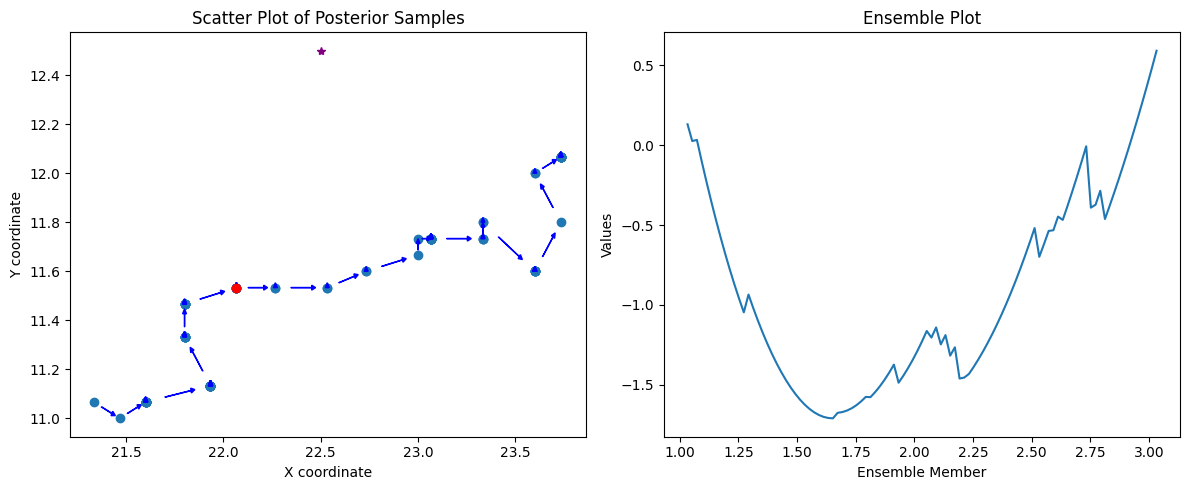

[0.3875192  0.17286941]


In [56]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# 第一幅图：散点图
x_coords = [point[0] for point in posterior_sample_list]
y_coords = [point[1] for point in posterior_sample_list]
ax[0].scatter(x_coords, y_coords)

ax[0].set_title('Scatter Plot of Posterior Samples')
ax[0].set_xlabel('X coordinate')
ax[0].set_ylabel('Y coordinate')

ax[0].plot(center[0]*50,center[1]*50,'*',color='purple')
ax[0].plot(x_coords[50],y_coords[50],'o',color='r')

arrow_length_factor = 0.3  # 调整因子，控制箭头离点的距离
for i in range(len(x_coords) - 1):
    dx = x_coords[i+1] - x_coords[i]
    dy = y_coords[i+1] - y_coords[i]
    start_x = x_coords[i] + arrow_length_factor * dx
    start_y = y_coords[i] + arrow_length_factor * dy
    ax[0].arrow(start_x, start_y, dx - 2 * arrow_length_factor * dx, dy - 2 * arrow_length_factor * dy,
                head_width=0.02, head_length=0.02, fc='blue', ec='blue')


# 第二幅图：折线图
ax[1].plot(ensemble_member[0], ensemble_values)
ax[1].set_title('Ensemble Plot')
ax[1].set_xlabel('Ensemble Member')
ax[1].set_ylabel('Values')

# 显示图形
plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
plt.show()

# 打印数据开始信息
print(d_start)

In [18]:
# 对于不同的design，绘制云图

data = np.load("theta_s_trajectory_simple_case_seed_2022.npz")

# 读取数组
values = data['arr_0']
count_step_list = data['arr_1']
design_list = data['arr_2']
params_at_stage_end_list = data['arr_3']
del data

data = np.load("posterior_simple_case_seed_2022.npz")
#data = np.load("posterior_simple_case_seed_812.npz")

# 由于保存时使用了无名参数，加载后的数据将用'arr_0', 'arr_1'等键来访问
loaded_list = [data[f'arr_{i}'] for i in range(n_stage)]
del data


size = 251  #只需要在 my_equation 里面改尺寸就可以了
local_size = int((size-1)/5+1)
density = 1.
viscosity = 1

lo_b = -2. #也需要在 my_equation 里面改范围
up_b = 3.

max_velocity = 2.0
cfl_safety_factor = 0.5


#key = random.PRNGKey(0)  # 随机数生成器的键
#x_for_shape = random.normal(key, (1, 2))  # 假设输入数据形状为 (batch_size, input_features)，这里是一个样本，两个特征
#model = my_forcing.FullyConnectedNN()  # 创建模型实例
#params = model.init(key, x_for_shape)




# OED settings =================
n_stage = 8
d_start = jnp.array([0.5,0.5])
center = jnp.array([0.45,0.25])

d_change_range = jnp.array([0.2,0.2])

noise_loc = 0
noise_base_scale = 0.05
noise_ratio_scale = 0.05
noise_info = [(noise_loc, noise_base_scale, noise_ratio_scale),]
num_top = 15

num_d = 1.0
radio_d = 0.5

xb_size = int((size - 1)/5+1) #初始化均匀先验
prior_ori = jnp.ones((xb_size,xb_size))

posterior_sample_list =[]

for stage in [3]:
    current_params = params_at_stage_end_list[stage]
    
    x_min, x_max, x_step = 0.2, 0.6, 0.1
    y_min, y_max, y_step = 0.1, 0.3, 0.1
    #x_min, x_max, x_step = 0.2, 0.6, 0.02
    #y_min, y_max, y_step = 0.05, 0.45, 0.02
    
    # 生成x和y的坐标值
    x_values = np.arange(x_min, x_max + x_step, x_step)
    y_values = np.arange(y_min, y_max + y_step, y_step)
    total_points = len(x_values) * len(y_values)
    
    # 生成网格点
    xx, yy = np.meshgrid(x_values, y_values)

    theta_s_list = np.zeros((len(y_values),len(x_values)))
    
    # 遍历网格点
    for (i, j), x in np.ndenumerate(xx):
        y = yy[i, j]
        # 将当前点坐标加入到d_start数组
        d_start = jnp.array([x, y])
        output_point, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
        observation = output_point
        print('observation = ', observation)
    
    
        # 定义一个ensemble
        ensemble_size = 101
        ensemble_step = 3
        initial_var = 1
        key_ensemble = random.split(key[stage],ensemble_size*ensemble_step+1)
        
        # 不要随机生成数据，均匀的生成，用于网格绘制
        ensemble_member = current_params + jnp.linspace(-1,1,ensemble_size)
        
        ensemble_key_count = 1
        ensemble_negtive_likelihood_values = np.zeros(ensemble_size)
    
    
        prior = loaded_list[stage-1]
        
        _, posterior = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], theta_true)
        del prior
        prior = posterior
    
        # 对于每一个元素 计算一个似然 直接绘制 因此不需要步数的循环
        for k in range(ensemble_size):
            ensemble_current_params = ensemble_member[0,k]
            likelihood, _ = loss_params_average_refine_unperturbed(ensemble_current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_ensemble[k+1], theta_true, num_top, observation)
            ensemble_negtive_likelihood_values[k] = likelihood
            #posterior_sample_list.append(posterior_sample)
            print('.',end='')
            ensemble_key_count += 1 # for key updating

        values_theta_s = np.min(ensemble_negtive_likelihood_values) # 找到了优化的结果
        min_index = np.argmin(ensemble_negtive_likelihood_values)

        _, posterior_position = loss_params_average_refine_unperturbed(ensemble_current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_ensemble[min_index+1], theta_true, num_top, observation)
        posterior_sample_list.append(posterior_position)

        theta_s_list[i,j]=values_theta_s

observation =  0.11139446
.....................................................................................................observation =  0.17861366
.....................................................................................................observation =  0.26846066
.....................................................................................................observation =  0.3142976
.....................................................................................................observation =  0.28718293
.....................................................................................................observation =  0.14974654
.....................................................................................................observation =  0.26779532
.....................................................................................................observation =  0.49528265
......................................................................................

In [ ]:
# 增加了断点恢复的计算
# 第一次算错了，保存的是likelihood而不是thetas，数据保存在backup中。似乎是在0.37，0.4进行测量的话，得到的thetas应该是偏差最小的。但是不一定是2。

import os
import numpy as np
import jax.numpy as jnp
import jax.random as random
import pickle

# 对于不同的design，绘制云图

data = np.load("theta_s_trajectory_simple_case_seed_2022_modifyLikelihood.npz")

# 读取数组
values = data['arr_0']
count_step_list = data['arr_1']
design_list = data['arr_2']
params_at_stage_end_list = data['arr_3']
del data

data = np.load("posterior_simple_case_seed_2022_modifyLikelihood.npz")
#data = np.load("posterior_simple_case_seed_812.npz")

# 由于保存时使用了无名参数，加载后的数据将用'arr_0', 'arr_1'等键来访问
loaded_list = [data[f'arr_{i}'] for i in range(n_stage)]
del data


size = 251  #只需要在 my_equation 里面改尺寸就可以了
local_size = int((size-1)/5+1)
density = 1.
viscosity = 1

lo_b = -2. #也需要在 my_equation 里面改范围
up_b = 3.

max_velocity = 2.0
cfl_safety_factor = 0.5


#key = random.PRNGKey(0)  # 随机数生成器的键
#x_for_shape = random.normal(key, (1, 2))  # 假设输入数据形状为 (batch_size, input_features)，这里是一个样本，两个特征
#model = my_forcing.FullyConnectedNN()  # 创建模型实例
#params = model.init(key, x_for_shape)




# OED settings =================
n_stage = 8
d_start = jnp.array([0.5,0.5])
center = jnp.array([0.45,0.25])

d_change_range = jnp.array([0.2,0.2])

noise_loc = 0
noise_base_scale = 0.05
noise_ratio_scale = 0.05
noise_info = [(noise_loc, noise_base_scale, noise_ratio_scale),]
num_top = 15

num_d = 1.0
radio_d = 0.5

xb_size = int((size - 1)/5+1) #初始化均匀先验
prior_ori = jnp.ones((xb_size,xb_size))


# 检查点保存路径
checkpoint_dir = './checkpoints/stage3_newLikelihood'  # =================================== 在这里修改文件名
os.makedirs(checkpoint_dir, exist_ok=True)

def save_checkpoint(stage, i, j, theta_s_list, posterior_sample_list):
    checkpoint = {
        'stage': stage,
        'i': i,
        'j': j,
        'theta_s_list': theta_s_list,
        'posterior_sample_list': posterior_sample_list
    }
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_stage_{stage}_i_{i}_j_{j}.pkl')
    with open(checkpoint_path, 'wb') as f:
        pickle.dump(checkpoint, f)

def load_checkpoint():
    checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith('.pkl')])
    if checkpoint_files:
        latest_checkpoint = checkpoint_files[-1]
        checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
        with open(checkpoint_path, 'rb') as f:
            checkpoint = pickle.load(f)
        return checkpoint
    return None

# 尝试加载检查点
checkpoint = load_checkpoint()
if checkpoint:
    stage = checkpoint['stage']
    start_i = checkpoint['i']
    start_j = checkpoint['j']
    theta_s_list = checkpoint['theta_s_list']
    posterior_sample_list = checkpoint['posterior_sample_list']
else:
    stage = 3  # 假设是从stage 3开始  # =================================== 在这里修改stage数
    x_min, x_max, x_step = 0.2, 0.6, 0.02
    y_min, y_max, y_step = 0.05, 0.45, 0.02
    x_values = np.arange(x_min, x_max + x_step, x_step)
    y_values = np.arange(y_min, y_max + y_step, y_step)
    start_i, start_j = 0, 0
    theta_s_list = np.zeros((len(y_values), len(x_values)))
    posterior_sample_list = []

current_params = params_at_stage_end_list[stage]
x_min, x_max, x_step = 0.2, 0.6, 0.02
y_min, y_max, y_step = 0.05, 0.45, 0.02
x_values = np.arange(x_min, x_max + x_step, x_step)
y_values = np.arange(y_min, y_max + y_step, y_step)
total_points = len(x_values) * len(y_values)
xx, yy = np.meshgrid(x_values, y_values)

for i in range(start_i, len(y_values)):
    for j in range(start_j if i == start_i else 0, len(x_values)):
        x = xx[i, j]
        y = yy[i, j]
        d_start = jnp.array([x, y])
        output_point, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
        observation = output_point
        print('observation = ', observation)
    
        ensemble_size = 101
        ensemble_step = 3
        initial_var = 1
        key_ensemble = random.split(key[stage], ensemble_size*ensemble_step+1)
        ensemble_member = current_params + jnp.linspace(-1, 1, ensemble_size)
        ensemble_key_count = 1
        ensemble_negtive_likelihood_values = np.zeros(ensemble_size)
    
        prior = loaded_list[stage-1]
        _, posterior = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], theta_true)
        del prior
        prior = posterior
    
        for k in range(ensemble_size):
            ensemble_current_params = ensemble_member[0, k]
            likelihood, _ = loss_params_average_refine_unperturbed(ensemble_current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_ensemble[k+1], theta_true, num_top, observation)
            ensemble_negtive_likelihood_values[k] = likelihood
            print('.', end='')
            ensemble_key_count += 1
    
        #values_min_likelihood = np.min(ensemble_negtive_likelihood_values)
        min_index = np.argmin(ensemble_negtive_likelihood_values)
        _, posterior_position = loss_params_average_refine_unperturbed(ensemble_current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_ensemble[min_index+1], theta_true, num_top, observation)
        posterior_sample_list.append(posterior_position)
        theta_s_list[i, j] = ensemble_member[0,min_index]
    
        # 定期保存检查点
        if (i * len(x_values) + j) % 10 == 0:
            save_checkpoint(stage, i, j, theta_s_list, posterior_sample_list)

# 最后保存检查点
save_checkpoint(stage, len(y_values), len(x_values), theta_s_list, posterior_sample_list)


In [30]:
likelihood, _ = loss_params_average_refine_unperturbed(theta_true, d_start, stage, center, prior, noise_info, num_d, radio_d, key_ensemble[k+1], theta_true, num_top, observation)
likelihood

Array(-1.6544005, dtype=float32)

In [53]:
np.min(np.abs(theta_s_list-2))

0.006928920745849609

In [15]:
import os
import pickle

def load_latest_checkpoint(checkpoint_dir='./checkpoints'):
    # 获取检查点目录下所有的.pkl文件
    checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith('.pkl')])
    if checkpoint_files:
        # 获取最新的检查点文件
        latest_checkpoint = checkpoint_files[-1]
        checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
        with open(checkpoint_path, 'rb') as f:
            checkpoint = pickle.load(f)
        return checkpoint
    else:
        print("No checkpoint files found.")
        return None
        
## 调用函数，读取数据
#latest_checkpoint_data = load_latest_checkpoint()
#if latest_checkpoint_data:
#    # 打印加载的数据以进行验证
#    print("Loaded checkpoint data:", latest_checkpoint_data)
#else:
#    print("Failed to load data.")


def load_specific_checkpoint(filename, checkpoint_dir='./checkpoints'):
    # 构建完整的文件路径
    checkpoint_path = os.path.join(checkpoint_dir, filename)
    # 检查文件是否存在
    if os.path.exists(checkpoint_path):
        with open(checkpoint_path, 'rb') as f:
            checkpoint = pickle.load(f)
        return checkpoint
    else:
        print("Checkpoint file does not exist.")
        return None


#filename = 'stage7/checkpoint_stage_7_i_20_j_20.pkl'  # 修改这里以匹配你想查看的具体文件名
#checkpoint_data = load_specific_checkpoint(filename)
#if checkpoint_data:
#    # 打印加载的数据以进行验证
#    print("Loaded checkpoint data:", checkpoint_data)
#else:
#    print("Failed to load data.")

In [87]:
type(checkpoint_data)

NoneType

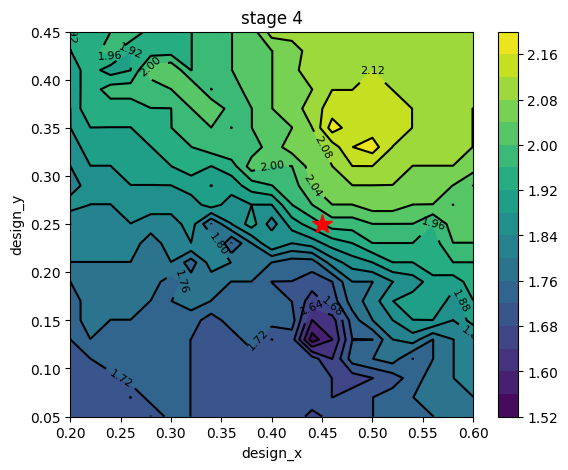

In [17]:
# 更换了likelihood中观测值和预测值的顺序，检查有多少区别
filename = 'stage3_newLikelihood/checkpoint_stage_3_i_21_j_21.pkl'
checkpoint_data = load_specific_checkpoint(filename)
plt.figure(figsize=(6.5,5))
#plt.contourf(xx,yy,theta_s_list,levels=20)

contour = plt.contourf(xx, yy, checkpoint_data['theta_s_list'], levels=20)

# 添加颜色条
plt.colorbar()
contours = plt.contour(xx, yy, checkpoint_data['theta_s_list'], levels=20, colors='black')
plt.clabel(contours, inline=True, fontsize=8)

plt.plot(center[0],center[1],'*',color='r',markersize=15)

plt.xlabel('design_x')
plt.ylabel('design_y')
plt.title('stage 4')
plt.show()

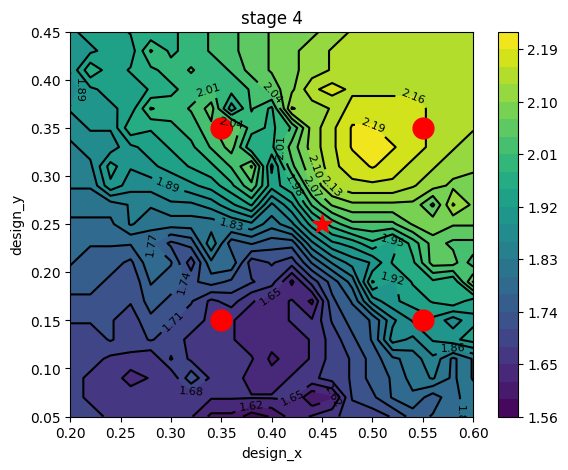

In [126]:
filename = 'stage3/checkpoint_stage_3_i_21_j_21.pkl'
checkpoint_data = load_specific_checkpoint(filename)

plt.figure(figsize=(6.5,5))
#plt.contourf(xx,yy,theta_s_list,levels=20)
x_min, x_max, x_step = 0.2, 0.6, 0.02
y_min, y_max, y_step = 0.05, 0.45, 0.02
x_values = np.arange(x_min, x_max + x_step, x_step)
y_values = np.arange(y_min, y_max + y_step, y_step)
total_points = len(x_values) * len(y_values)
xx, yy = np.meshgrid(x_values, y_values)

contour = plt.contourf(xx, yy, checkpoint_data['theta_s_list'], levels=20)

# 添加颜色条
plt.colorbar()
contours = plt.contour(xx, yy,checkpoint_data['theta_s_list'], levels=20, colors='black')
plt.clabel(contours, inline=True, fontsize=8)

plt.plot(center[0],center[1],'*',color='r',markersize=15)

plt.plot(0.35,0.15,'o',color='r',markersize=15)
plt.plot(0.35,0.35,'o',color='r',markersize=15)
plt.plot(0.55,0.15,'o',color='r',markersize=15)
plt.plot(0.55,0.35,'o',color='r',markersize=15)


plt.xlabel('design_x')
plt.ylabel('design_y')
plt.title('stage 4')
plt.show()

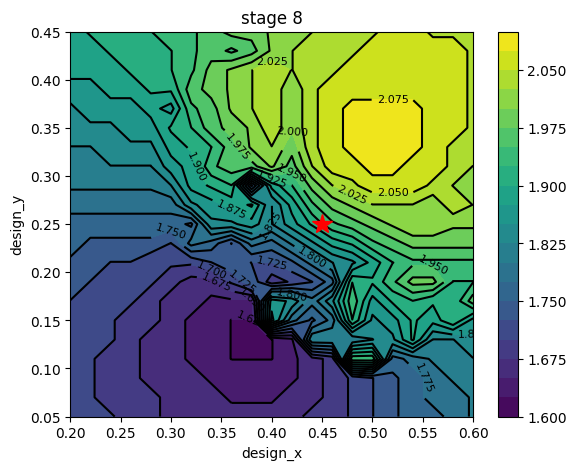

In [110]:
#filename = 'stage7/checkpoint_stage_7_i_21_j_21.pkl'  # 修改这里以匹配你想查看的具体文件名
filename = 'stage7/checkpoint_stage_7_i_20_j_20.pkl'
checkpoint_data = load_specific_checkpoint(filename)
plt.figure(figsize=(6.5,5))
#plt.contourf(xx,yy,theta_s_list,levels=20)

contour = plt.contourf(xx, yy, checkpoint_data['theta_s_list'], levels=20)

# 添加颜色条
plt.colorbar()
contours = plt.contour(xx, yy, checkpoint_data['theta_s_list'], levels=20, colors='black')
plt.clabel(contours, inline=True, fontsize=8)

plt.plot(center[0],center[1],'*',color='r',markersize=15)
plt.xlabel('design_x')
plt.ylabel('design_y')
plt.title('stage 8')
plt.show()

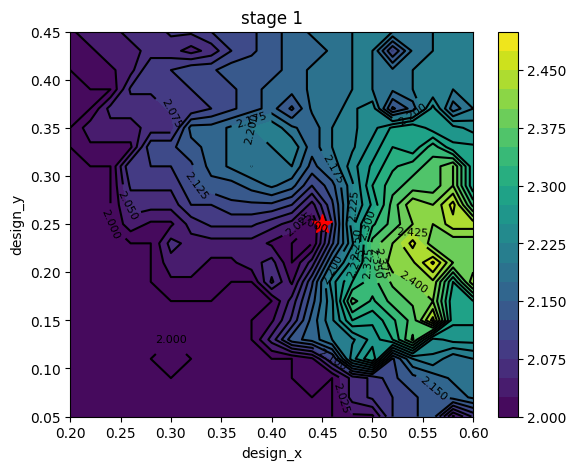

In [109]:
#filename = 'stage7/checkpoint_stage_7_i_21_j_21.pkl'  # 修改这里以匹配你想查看的具体文件名
filename = 'stage0/checkpoint_stage_0_i_21_j_21.pkl'
checkpoint_data = load_specific_checkpoint(filename)
plt.figure(figsize=(6.5,5))
#plt.contourf(xx,yy,theta_s_list,levels=20)

contour = plt.contourf(xx, yy, checkpoint_data['theta_s_list'], levels=20)

# 添加颜色条
plt.colorbar()
contours = plt.contour(xx, yy, checkpoint_data['theta_s_list'], levels=20, colors='black')
plt.clabel(contours, inline=True, fontsize=8)

plt.plot(center[0],center[1],'*',color='r',markersize=15)

plt.xlabel('design_x')
plt.ylabel('design_y')
plt.title('stage 1')
plt.show()

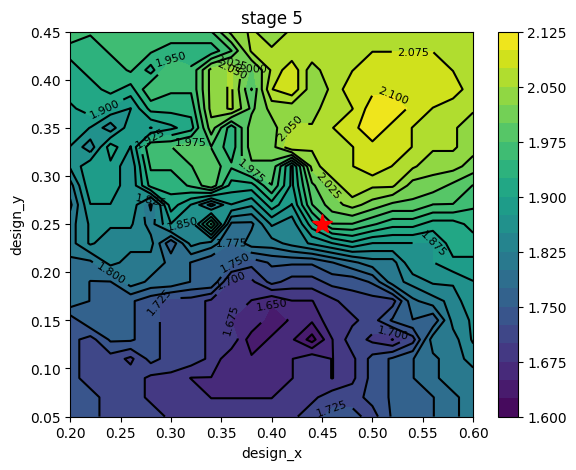

In [111]:
filename = 'stage4/checkpoint_stage_4_i_21_j_21.pkl'
checkpoint_data = load_specific_checkpoint(filename)

plt.figure(figsize=(6.5,5))
#plt.contourf(xx,yy,theta_s_list,levels=20)

contour = plt.contourf(xx, yy, checkpoint_data['theta_s_list'], levels=20)

# 添加颜色条
plt.colorbar()
contours = plt.contour(xx, yy, checkpoint_data['theta_s_list'], levels=20, colors='black')
plt.clabel(contours, inline=True, fontsize=8)

plt.plot(center[0],center[1],'*',color='r',markersize=15)
plt.xlabel('design_x')
plt.ylabel('design_y')
plt.title('stage 5')
plt.show()

In [184]:
# 算出每一个design的observation，算出最大likelihood对应的theta_s下应该的测量值，


def loss_params_average_refine_unperturbed(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, theta_true, num_top, observation):
    # 找到了evidence最大的几个点，然后把他们的index取平均值，在loglikelihood中插值
    # 在前面进行测量，这里只进行模拟就行
    
    loglikelihood = calculate_loglikelihood_refine(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, theta_true, observation)
    log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
    indices = jnp.argpartition(log_evidence_list.ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)

    # 计算平均坐标
    average_x = np.mean(multi_indices[0])
    average_y = np.mean(multi_indices[1])
    
    # 直接使用平均坐标
    selected_loglikelihoods = jax.scipy.ndimage.map_coordinates(loglikelihood,[average_x,average_y],1)

    list_local = [average_x, average_y]
    return -selected_loglikelihoods, list_local


def calculate_loglikelihood_refine(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, theta_true, observation):
    '''
    参数：
    stage: 当前的阶段。用于决定forward模拟的步数
    center: 污染源的中心
    current_params: 网络的参数
    d_start: 测量点
    prior: 先验
    noise_info: 测量误差设置
    num_d: 计算后验时使用的点数
    radio_d: 在测量点附近多选几个点测量，本质上可以理解为多次测量消除误差，可以考虑直接舍弃误差

    说明：
    1，假设数据量是300*300，计算范围是3*3
    应该是需要数据尺寸是3的倍数，否则到时候后验那里也会费劲
    也可以不是3的倍数，只要后验矩阵和数据矩阵匹配就行
    2，运用了等效的原则。主要起作用的是测量点和center的相对位置
    这里突然想到nn应该需要四个参数，当前的坐标和center，而不是仅当前坐标。
    '''
    noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]
    if num_d == 1.0:
        # 给一个函数，从所有的输出中找到关心的点
        false_center = jnp.array([1.0,1.0]) - d_start
        false_start = jnp.array([0.5, 0.5])
        #_, output_all = sealed_convection_diffusion_nn(current_params, false_start, false_center, stage, model)
        _, output_all  = sealed_convection_diffusion_exp_parametic(false_start, false_center, stage, current_params)
        #output_all_central_sym = output_all.T
        output_all_central_sym = jnp.fliplr(jnp.flipud(output_all))
        # 取出[0,1]^2之间的矩阵
        xb_lo = int((0.0 - lo_b) / (up_b - lo_b) * (size - 1))
        xb_up = int((1.0 - lo_b) / (up_b - lo_b) * (size - 1))
        output_for_xb = output_all_central_sym[xb_lo:(xb_up+1),xb_lo:(xb_up+1)]
        # 针对于每一个数字求likelihood
        loglikelihood = jax.scipy.stats.norm.logpdf(output_for_xb, loc=observation, scale=noise_base_scale+noise_ratio_scale*observation)
    return loglikelihood
    

data = np.load("theta_s_trajectory_simple_case_seed_2022.npz")

# 读取数组
values = data['arr_0']
count_step_list = data['arr_1']
design_list = data['arr_2']
params_at_stage_end_list = data['arr_3']
del data

data = np.load("posterior_simple_case_seed_2022.npz")
#data = np.load("posterior_simple_case_seed_812.npz")

# 由于保存时使用了无名参数，加载后的数据将用'arr_0', 'arr_1'等键来访问
loaded_list = [data[f'arr_{i}'] for i in range(n_stage)]
del data


size = 251  #只需要在 my_equation 里面改尺寸就可以了
local_size = int((size-1)/5+1)
density = 1.
viscosity = 1

lo_b = -2. #也需要在 my_equation 里面改范围
up_b = 3.

max_velocity = 2.0
cfl_safety_factor = 0.5


#key = random.PRNGKey(0)  # 随机数生成器的键
#x_for_shape = random.normal(key, (1, 2))  # 假设输入数据形状为 (batch_size, input_features)，这里是一个样本，两个特征
#model = my_forcing.FullyConnectedNN()  # 创建模型实例
#params = model.init(key, x_for_shape)




# OED settings =================
n_stage = 8
d_start = jnp.array([0.5,0.5])
center = jnp.array([0.45,0.25])

d_change_range = jnp.array([0.2,0.2])

noise_loc = 0
noise_base_scale = 0.05
noise_ratio_scale = 0.05
noise_info = [(noise_loc, noise_base_scale, noise_ratio_scale),]
num_top = 15

num_d = 1.0
radio_d = 0.5

xb_size = int((size - 1)/5+1) #初始化均匀先验
prior_ori = jnp.ones((xb_size,xb_size))

posterior_sample_list =[]

for stage in [3]:
    current_params = params_at_stage_end_list[stage]
    
    x_min, x_max, x_step = 0.35, 0.5, 0.1
    y_min, y_max, y_step = 0.15, 0.3, 0.1
    #x_min, x_max, x_step = 0.2, 0.6, 0.02
    #y_min, y_max, y_step = 0.05, 0.45, 0.02
    
    # 生成x和y的坐标值
    x_values = np.arange(x_min, x_max + x_step, x_step)
    y_values = np.arange(y_min, y_max + y_step, y_step)
    total_points = len(x_values) * len(y_values)
    
    # 生成网格点
    xx, yy = np.meshgrid(x_values, y_values)

    theta_s_list = np.zeros((len(y_values),len(x_values)))

    y_f_list = np.zeros((len(x_values),len(y_values),ensemble_size))
    observation_list = np.zeros((len(x_values),len(y_values)))
    ensemble_negtive_likelihood_values = np.zeros((len(x_values),len(y_values),ensemble_size))
    ensemble_negtive_likelihood_values_reverse = np.zeros((len(x_values),len(y_values),ensemble_size))
    posterior_sample_list = np.zeros((len(x_values),len(y_values),ensemble_size,2))
    
    # 遍历网格点
    for (i, j), x in np.ndenumerate(xx):
        y = yy[i, j]
        # 将当前点坐标加入到d_start数组
        d_start = jnp.array([x, y])
        print('design = ', d_start)

        # 对于每一个d，有一个测量值。
        output_point, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
        observation = output_point
        print('observation = ', observation)
        observation_list[i,j]=observation
        
    
        # 定义一个ensemble
        ensemble_size = 101
        ensemble_step = 3
        initial_var = 1
        
        #y_f_list = np.zeros(ensemble_size) # 每一个theta s都对应了一个预测值 记录下来
        observation_array = np.arange(0.0,0.9,0.02) # 生成一串的likelihood用于绘图
        likelihood_contour = np.zeros((ensemble_size, observation_array.shape[0])) # 保存所有步的likelihood，用于画图
        posterior_coordinate_list = np.zeros((ensemble_size,2)) # 保存估计的后验点的位置
    
        key_ensemble = random.split(key[stage],ensemble_size*ensemble_step+1)
        
        # 不要随机生成数据，均匀的生成，用于网格绘制
        ensemble_member = current_params + jnp.linspace(-1,1,ensemble_size)
        
        #ensemble_key_count = 1
        #ensemble_negtive_likelihood_values = np.zeros(ensemble_size)
        #ensemble_negtive_likelihood_values_reverse = np.zeros(ensemble_size)
    
    
        prior = loaded_list[stage-1]
        
        _, posterior = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], theta_true)
        del prior
        prior = posterior
    
        # 对于每一个元素 计算一个似然 直接绘制 因此不需要步数的循环
        for k in range(ensemble_size):
            ensemble_current_params = ensemble_member[0,k]
            likelihood, posterior_position = loss_params_average_refine_unperturbed(ensemble_current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_ensemble[k+1], theta_true, num_top, observation)
            # 估计的后验中心
            posterior_coordinate = jnp.array([posterior_position[0]/50,posterior_position[1]/50])
            # 求出预测值
            forecast, _  = sealed_convection_diffusion_exp_parametic(d_start, posterior_coordinate, stage, ensemble_current_params)
            loglikelihood = jax.scipy.stats.norm.logpdf(observation, loc=forecast, scale=noise_base_scale+noise_ratio_scale*forecast)
            #loglikelihood_array = jax.scipy.stats.norm.logpdf(observation_array, loc=forecast, scale=noise_base_scale+noise_ratio_scale*forecast)
            #likelihood_contour[k,:]=loglikelihood_array

            y_f_list[i,j,k]=forecast
            ensemble_negtive_likelihood_values[i,j,k] = likelihood
            ensemble_negtive_likelihood_values_reverse[i,j,k] = -loglikelihood
            #print(f'observation = {observation}, forecast is {forecast}')
            #print(f'likelihood = {likelihood}, reverse likelihood = {-loglikelihood}')
            posterior_sample_list[i,j,k,:]=posterior_coordinate
            print('.',end='')
            #print(f'for theta_s = {ensemble_current_params}, forecast at {posterior_coordinate} is {forecast}')
            #ensemble_key_count += 1 # for key updating

        values_theta_s = np.min(ensemble_negtive_likelihood_values) # 找到了优化的结果
        min_index = np.argmin(ensemble_negtive_likelihood_values)

        #_, posterior_position = loss_params_average_refine_unperturbed(ensemble_current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_ensemble[min_index+1], theta_true, num_top, observation)
        #posterior_sample_list.append(posterior_position)

        theta_s_list[i,j]=values_theta_s

design =  [0.35 0.15]
observation =  0.2920078
.....................................................................................................design =  [0.45 0.15]
observation =  0.42524874
.....................................................................................................design =  [0.55 0.15]
observation =  0.39907724
.....................................................................................................design =  [0.35 0.25]
observation =  0.4234314
.....................................................................................................design =  [0.45 0.25]
observation =  0.68848634
.....................................................................................................design =  [0.55 0.25]
observation =  0.5734683
.....................................................................................................design =  [0.35 0.35]
observation =  0.39682886
.............................................................

In [6]:
# 测试梯度下降法和网格搜索的结果是不是一样

# 算出每一个design的observation，算出最大likelihood对应的theta_s下应该的测量值，


def loss_params_average_refine_unperturbed(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, theta_true, num_top, observation):
    # 找到了evidence最大的几个点，然后把他们的index取平均值，在loglikelihood中插值
    # 在前面进行测量，这里只进行模拟就行
    
    loglikelihood = calculate_loglikelihood_refine(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, theta_true, observation)
    log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
    indices = jnp.argpartition(log_evidence_list.ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)

    # 计算平均坐标
    average_x = np.mean(multi_indices[0])
    average_y = np.mean(multi_indices[1])
    
    # 直接使用平均坐标
    selected_loglikelihoods = jax.scipy.ndimage.map_coordinates(loglikelihood,[average_x,average_y],1)

    list_local = [average_x, average_y]
    return -selected_loglikelihoods, list_local


def calculate_loglikelihood_refine(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, theta_true, observation):
    '''
    参数：
    stage: 当前的阶段。用于决定forward模拟的步数
    center: 污染源的中心
    current_params: 网络的参数
    d_start: 测量点
    prior: 先验
    noise_info: 测量误差设置
    num_d: 计算后验时使用的点数
    radio_d: 在测量点附近多选几个点测量，本质上可以理解为多次测量消除误差，可以考虑直接舍弃误差

    说明：
    1，假设数据量是300*300，计算范围是3*3
    应该是需要数据尺寸是3的倍数，否则到时候后验那里也会费劲
    也可以不是3的倍数，只要后验矩阵和数据矩阵匹配就行
    2，运用了等效的原则。主要起作用的是测量点和center的相对位置
    这里突然想到nn应该需要四个参数，当前的坐标和center，而不是仅当前坐标。
    '''
    noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]
    if num_d == 1.0:
        # 给一个函数，从所有的输出中找到关心的点
        false_center = jnp.array([1.0,1.0]) - d_start
        false_start = jnp.array([0.5, 0.5])
        #_, output_all = sealed_convection_diffusion_nn(current_params, false_start, false_center, stage, model)
        _, output_all  = sealed_convection_diffusion_exp_parametic(false_start, false_center, stage, current_params)
        #output_all_central_sym = output_all.T
        output_all_central_sym = jnp.fliplr(jnp.flipud(output_all))
        # 取出[0,1]^2之间的矩阵
        xb_lo = int((0.0 - lo_b) / (up_b - lo_b) * (size - 1))
        xb_up = int((1.0 - lo_b) / (up_b - lo_b) * (size - 1))
        output_for_xb = output_all_central_sym[xb_lo:(xb_up+1),xb_lo:(xb_up+1)]
        # 针对于每一个数字求likelihood
        loglikelihood = jax.scipy.stats.norm.logpdf(output_for_xb, loc=observation, scale=noise_base_scale+noise_ratio_scale*observation)
    return loglikelihood
    

data = np.load("theta_s_trajectory_simple_case_seed_2022.npz")

# 读取数组
values = data['arr_0']
count_step_list = data['arr_1']
design_list = data['arr_2']
params_at_stage_end_list = data['arr_3']
del data

data = np.load("posterior_simple_case_seed_2022.npz")
#data = np.load("posterior_simple_case_seed_812.npz")

# 由于保存时使用了无名参数，加载后的数据将用'arr_0', 'arr_1'等键来访问
loaded_list = [data[f'arr_{i}'] for i in range(n_stage)]
del data


size = 251  #只需要在 my_equation 里面改尺寸就可以了
local_size = int((size-1)/5+1)
density = 1.
viscosity = 1

lo_b = -2. #也需要在 my_equation 里面改范围
up_b = 3.

max_velocity = 2.0
cfl_safety_factor = 0.5


#key = random.PRNGKey(0)  # 随机数生成器的键
#x_for_shape = random.normal(key, (1, 2))  # 假设输入数据形状为 (batch_size, input_features)，这里是一个样本，两个特征
#model = my_forcing.FullyConnectedNN()  # 创建模型实例
#params = model.init(key, x_for_shape)




# OED settings =================
n_stage = 8
d_start = jnp.array([0.5,0.5])
center = jnp.array([0.45,0.25])

d_change_range = jnp.array([0.2,0.2])

noise_loc = 0
noise_base_scale = 0.05
noise_ratio_scale = 0.05
noise_info = [(noise_loc, noise_base_scale, noise_ratio_scale),]
num_top = 15

num_d = 1.0
radio_d = 0.5

xb_size = int((size - 1)/5+1) #初始化均匀先验
prior_ori = jnp.ones((xb_size,xb_size))

ensemble_size = 101
posterior_sample_list =[]

for stage in [3]:
    current_params = params_at_stage_end_list[stage]
    
    x_min, x_max, x_step = 0.35, 0.3, 0.1
    y_min, y_max, y_step = 0.35, 0.3, 0.1
    #x_min, x_max, x_step = 0.2, 0.6, 0.02
    #y_min, y_max, y_step = 0.05, 0.45, 0.02
    
    # 生成x和y的坐标值
    x_values = np.arange(x_min, x_max + x_step, x_step)
    y_values = np.arange(y_min, y_max + y_step, y_step)
    total_points = len(x_values) * len(y_values)
    
    # 生成网格点
    xx, yy = np.meshgrid(x_values, y_values)

    theta_s_list = np.zeros((len(y_values),len(x_values)))

    y_f_list = np.zeros((len(x_values),len(y_values),ensemble_size))
    observation_list = np.zeros((len(x_values),len(y_values)))
    ensemble_negtive_likelihood_values = np.zeros((len(x_values),len(y_values),ensemble_size))
    ensemble_negtive_likelihood_values_reverse = np.zeros((len(x_values),len(y_values),ensemble_size))
    posterior_sample_list = np.zeros((len(x_values),len(y_values),ensemble_size,2))
    
    # 遍历网格点
    for (i, j), x in np.ndenumerate(xx):
        y = yy[i, j]
        # 将当前点坐标加入到d_start数组
        d_start = jnp.array([x, y])
        print('design = ', d_start)

        # 对于每一个d，有一个测量值。
        output_point, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
        observation = output_point
        print('observation = ', observation)
        observation_list[i,j]=observation
        
    
        # 定义一个ensemble
        ensemble_size = 101
        ensemble_step = 3
        initial_var = 1
        
        #y_f_list = np.zeros(ensemble_size) # 每一个theta s都对应了一个预测值 记录下来
        observation_array = np.arange(0.0,0.9,0.02) # 生成一串的likelihood用于绘图
        likelihood_contour = np.zeros((ensemble_size, observation_array.shape[0])) # 保存所有步的likelihood，用于画图
        posterior_coordinate_list = np.zeros((ensemble_size,2)) # 保存估计的后验点的位置
    
        key_ensemble = random.split(key[stage],ensemble_size*ensemble_step+1)
        
        # 不要随机生成数据，均匀的生成，用于网格绘制
        ensemble_member = current_params + jnp.linspace(-1,1,ensemble_size)
        
        #ensemble_key_count = 1
        #ensemble_negtive_likelihood_values = np.zeros(ensemble_size)
        #ensemble_negtive_likelihood_values_reverse = np.zeros(ensemble_size)
    
    
        prior = loaded_list[stage-1]
        
        _, posterior = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], theta_true)
        del prior
        prior = posterior
    
        # 对于每一个元素 计算一个似然 直接绘制 因此不需要步数的循环
        for k in range(ensemble_size):
            ensemble_current_params = ensemble_member[0,k]
            likelihood, posterior_position = loss_params_average_refine_unperturbed(ensemble_current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_ensemble[k+1], theta_true, num_top, observation)
            # 估计的后验中心
            posterior_coordinate = jnp.array([posterior_position[0]/50,posterior_position[1]/50])
            # 求出预测值
            forecast, _  = sealed_convection_diffusion_exp_parametic(d_start, posterior_coordinate, stage, ensemble_current_params)
            loglikelihood = jax.scipy.stats.norm.logpdf(observation, loc=forecast, scale=noise_base_scale+noise_ratio_scale*forecast)
            #loglikelihood_array = jax.scipy.stats.norm.logpdf(observation_array, loc=forecast, scale=noise_base_scale+noise_ratio_scale*forecast)
            #likelihood_contour[k,:]=loglikelihood_array

            y_f_list[i,j,k]=forecast
            ensemble_negtive_likelihood_values[i,j,k] = likelihood
            ensemble_negtive_likelihood_values_reverse[i,j,k] = -loglikelihood
            #print(f'observation = {observation}, forecast is {forecast}')
            #print(f'likelihood = {likelihood}, reverse likelihood = {-loglikelihood}')
            posterior_sample_list[i,j,k,:]=posterior_coordinate
            print('.',end='')
            #print(f'for theta_s = {ensemble_current_params}, forecast at {posterior_coordinate} is {forecast}')
            #ensemble_key_count += 1 # for key updating

        values_theta_s = np.min(ensemble_negtive_likelihood_values) # 找到了优化的结果
        min_index = np.argmin(ensemble_negtive_likelihood_values)

        #_, posterior_position = loss_params_average_refine_unperturbed(ensemble_current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_ensemble[min_index+1], theta_true, num_top, observation)
        #posterior_sample_list.append(posterior_position)

        theta_s_list[i,j]=values_theta_s

design =  [0.35 0.35]
observation =  0.39682886
.....................................................................................................

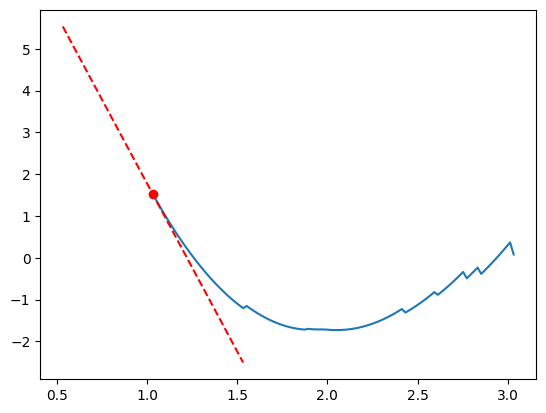

In [27]:
current_params = 1.0
params_grad,_ = jax.grad(loss_params_average_refine_unperturbed,has_aux=True)(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_ensemble[k+1], theta_true, num_top, observation)

index = np.argmin(np.abs(ensemble_member[0] - current_params))
x0 = ensemble_member[0][index]
y0 = ensemble_negtive_likelihood_values[0,0,:][index]

# 定义切线的x范围
delta_x = 0.5
x_tangent = np.linspace(x0 - delta_x, x0 + delta_x, 100)
y_tangent = params_grad * (x_tangent - x0) + y0

# 绘制原曲线
plt.plot(ensemble_member[0], ensemble_negtive_likelihood_values[0,0,:], label='Original Curve')

# 绘制切线
plt.plot(x_tangent, y_tangent, 'r--', label='Tangent at x={}'.format(current_params))

# 标记切线点
plt.scatter([x0], [y0], color='red')


Text(0, 0.5, 'negetive likelihood')

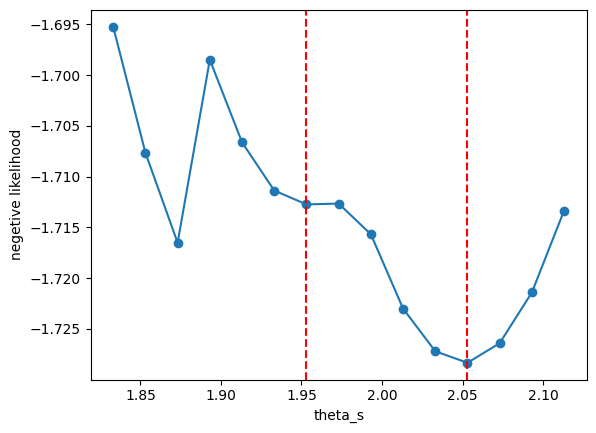

In [37]:
plt.plot(ensemble_member[0][40:55], ensemble_negtive_likelihood_values[0,0,40:55],linestyle='-', marker='o')
plt.axvline(ensemble_member[0][46],linestyle='--',color='r')
plt.axvline(ensemble_member[0][51],linestyle='--',color='r')
plt.xlabel('theta_s')
plt.ylabel('negetive likelihood')

In [ ]:
# 对于某一个design，进行ensemble gradient descent

In [7]:
step = 100
sample_size = 15 # 这里不用前面的ensemble size=101是因为只需要少量的member，不要和前面参数冲突
params_list = np.zeros((sample_size, step))

for i in range(sample_size):
    
    optimizer = optax.sgd(learning_rate=0.01)
    current_params = jnp.array([1.0])+i*jnp.array([0.2])
    opt_state = optimizer.init(current_params)
    
    for j in range(step):
        # 计算梯度
        params_grad, _ = jax.grad(loss_params_average_refine_unperturbed, has_aux=True)(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_ensemble[k+1], theta_true, num_top, observation)
        
        # 使用优化器更新参数
        updates, opt_state = optimizer.update(params_grad, opt_state, current_params)
        current_params = optax.apply_updates(current_params, updates)
        params_list[i,j]=current_params.item()
        print('.',end='')
        
    print('|',end='')

....................................................................................................|....................................................................................................|....................................................................................................|....................................................................................................|....................................................................................................|....................................................................................................|....................................................................................................|....................................................................................................|....................................................................................................|...........................................................................................

1.951114535331726 2.050525665283203


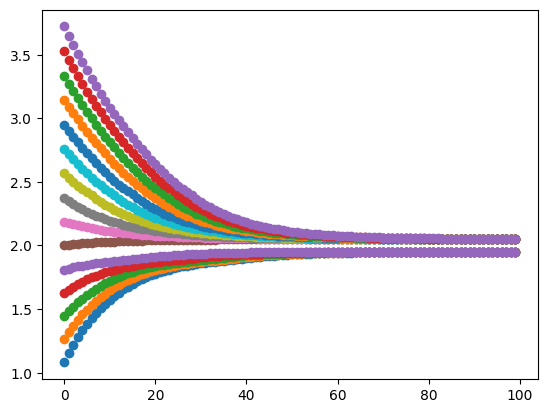

In [12]:
for i in range(params_list.shape[0]):
    plt.plot(params_list[i,:],'o')

print(params_list[4,-1],params_list[6,-1])

....................................................................................................|....................................................................................................|....................................................................................................|....................................................................................................|....................................................................................................|....................................................................................................|....................................................................................................|....................................................................................................|....................................................................................................|...........................................................................................

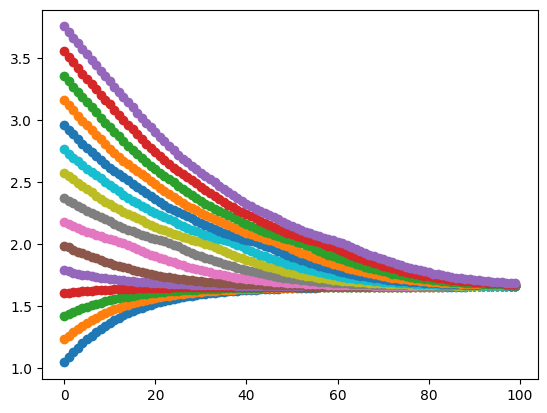

In [9]:
step = 100
sample_size = 15
params_list = np.zeros((sample_size, step))

for i in range(sample_size):
    
    optimizer = optax.sgd(learning_rate=0.01)
    current_params = jnp.array([1.0])+i*jnp.array([0.2])
    opt_state = optimizer.init(current_params)
    
    for j in range(step):
        # 计算梯度
        params_grad, _ = jax.grad(loss_params_average_refine_unperturbed, has_aux=True)(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_ensemble[k+1], theta_true, num_top, observation)
        
        # 使用优化器更新参数
        updates, opt_state = optimizer.update(params_grad, opt_state, current_params)
        current_params = optax.apply_updates(current_params, updates)
        params_list[i.j]=current_params
        print('.',end='')
        
    print('|',end='')

for i in range(params_list.shape[0]):
    plt.plot(params_list[i,:],'o')

print(params_list[4,-1],params_list[6,-1])

In [40]:
# 对于某一个design，进行EnKF

# 调整的策略：对于不同的theta_s，直接从0时刻生成u_f，再进行EnKF。forward model 计算代价是 ensemble_size * forward_step。但是这只是一步的EnKF。
# 如果保存每一步的状态，从上一时刻生成u_f,再进行EnKF。forward model 计算代价是 ensemble_size * forward_step/stage。
# 选取哪一步的状态作为初始状态？

# 比较ensemble gradient descent，forward model 计算代价是 ensemble_size * forward_step，不确定

def forward_epistemic_model_from_initial(u,center,params,stage):
    '''
    用于kalmen方法的前进模型
    给定一个时刻的场,输出下一个时刻的场.时刻用stage标记.
    输出一个len=2的tuple.第一个元素是场的tuple,第二个元素是时间
    使用u[0][0].array.data提取数据

    stage是当前阶段的标记，当前阶段的样本x中的场是上一个阶段来的，因此前进模型的开始计算时间是上一个阶段的时间
    '''
    steps = 100*(stage+1)
    
    dt= 0.0005
    grid = cfd.grids.Grid((size, size), domain=((lo_b, up_b), (lo_b, up_b)))
    
    center_x= center[0]
    center_y= center[1]

    rollout_fn = jax.jit(my_funcutils.trajectory(my_equations.implicit_convection_diffusion3(
            density=density, viscosity=viscosity, dt=dt, grid=grid, forcing = my_forcing.exponential_force_adjustable(grid,center_x=center_x, center_y=center_y, theta_s=params)), steps))

    time = 0.0

    last_step, _ = rollout_fn(u,time)
    return last_step[0][0].data

def get_tem_u_f(sample, d_start,center):
    # 这个sample就是状态x
    tem_field = get_tem_field(sample)
    tem_param_dict = get_tem_param_dict(sample)
    return forward_epistemic_model(tem_field, center, tem_param_dict,params)

def get_y_f(tem_u_f, d_start):
    i = (d_start[0] - lo_b) / (up_b - lo_b) * (size - 1)
    j = (d_start[1] - lo_b) / (up_b - lo_b) * (size - 1)
    return jax.scipy.ndimage.map_coordinates(tem_u_f, [i, j], order=1)

def get_tem_field(sample):
    sample_field = sample[:size*size].reshape(size,size)
    return reconstruct_array_to_field(sample_field)

def get_tem_param_dict(sample):
    sample_netparams = sample[size*size:]
    return sample_netparams


def EnKF_process(d_start, observation, ensemble_member, sudo_center, stage, G0):
    # 进行一次EnKF更新

    # 生成初始状态的场
    # 直接在外面生成一个导入
    # 从这个场，用ensemble menber更新到现在
    ensemble_size_local = ensemble_member.shape[0]
    tem_u_fs = jax.vmap(forward_epistemic_model_from_initial, in_axes=(None, None, 0, None))(G0,sudo_center,ensemble_member,stage)
    
    y_fs = jax.vmap(get_y_f, in_axes=(0, None))(tem_u_fs, d_start).reshape(-1, 1)

    y_f_mean = jnp.mean(y_fs)
    P_yy = 1/(ensemble_size_local-1)*jnp.sum((y_fs-y_f_mean)**2)+noise_base_scale

    tem_u_fs_array = tem_u_fs.reshape(ensemble_size_local,-1)
    x_f = jnp.concatenate([tem_u_fs_array, ensemble_member.reshape(ensemble_size_local,-1)], axis=1)
    x_f_mean = jnp.mean(x_f, axis=0).reshape(1,-1)

    x_f_deviation = x_f - x_f_mean
    y_f_deviation = y_fs - y_f_mean.reshape(1,1)
    P_xy = jnp.matmul(x_f_deviation.T, y_f_deviation) / (ensemble_size_local - 1) 

    K = P_xy * 1.0/P_yy
    x_a = x_f + jnp.matmul(K, (observation - y_fs).T).T
    
    theta_samples_updated = x_a[:, -1]
    return theta_samples_updated


def EnKF_process_correct(d_start, observation, ensemble_member, stage, prior, G0, num_top=15):
    # 进行一次EnKF更新
    # 这个代码是不能够并行的

    # 生成初始状态的场
    # 直接在外面生成一个导入
    # 从这个场，用ensemble menber更新到现在

    # noise_info, lo_b, up_b, size, num_top 是全局变量
    
    ensemble_size_local = ensemble_member.shape[0]


    y_fs = jnp.zeros((ensemble_size_local,1))
    for i in range(ensemble_size_local):
        noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]
        false_center = jnp.array([1.0,1.0]) - d_start
        false_start = jnp.array([0.5, 0.5])
        _, output_all  = sealed_convection_diffusion_exp_parametic(false_start, false_center, stage, ensemble_member[i])
        output_all_central_sym = jnp.fliplr(jnp.flipud(output_all))
        xb_lo = int((0.0 - lo_b) / (up_b - lo_b) * (size - 1))
        xb_up = int((1.0 - lo_b) / (up_b - lo_b) * (size - 1))
        output_for_xb = output_all_central_sym[xb_lo:(xb_up+1),xb_lo:(xb_up+1)]
        loglikelihood = jax.scipy.stats.norm.logpdf(output_for_xb, loc=observation, scale=noise_base_scale+noise_ratio_scale*observation)
        log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
        indices = jnp.argpartition(log_evidence_list.ravel(), -num_top)[-num_top:]
        multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)

        average_x = np.mean(multi_indices[0])
        average_y = np.mean(multi_indices[1])
        
        y_f = jax.scipy.ndimage.map_coordinates(output_for_xb,[average_x,average_y],1)
        y_fs = y_fs.at[i,0].set(y_f)
    
    y_f_mean = jnp.mean(y_fs)
    P_yy = 1/(ensemble_size_local-1)*jnp.sum((y_fs-y_f_mean)**2)+1e-2#noise_base_scale

    x_f_theta = ensemble_member.reshape(ensemble_size_local,-1)
    x_f_mean = jnp.mean(x_f_theta, axis=0).reshape(1,-1)

    x_f_deviation = x_f_theta - x_f_mean
    y_f_deviation = y_fs - y_f_mean.reshape(1,1)
    P_xy = jnp.matmul(x_f_deviation.T, y_f_deviation) / (ensemble_size_local - 1) 

    K = P_xy * 1.0/P_yy
    x_a = x_f_theta + jnp.matmul(K, (observation - y_fs).T).T
    
    x_a_mean = np.mean(x_a, axis=0)
    inflation_factor = 1.05 # 或其他合适的值
    x_a = x_a_mean + inflation_factor * (x_a - x_a_mean) # 膨胀因子
    
    theta_samples_updated = x_a[:, -1]
    return theta_samples_updated




data = np.load("theta_s_trajectory_simple_case_seed_2022.npz")

# 读取数组
values = data['arr_0']
count_step_list = data['arr_1']
design_list = data['arr_2']
params_at_stage_end_list = data['arr_3']
del data

data = np.load("posterior_simple_case_seed_2022.npz")
#data = np.load("posterior_simple_case_seed_812.npz")

# 由于保存时使用了无名参数，加载后的数据将用'arr_0', 'arr_1'等键来访问
loaded_list = [data[f'arr_{i}'] for i in range(n_stage)]
del data

stage = 5

step = 10
sample_size = 30#15
#current_params = params_at_stage_end_list[stage]
#ensemble_params = (current_params+jnp.arange(0,sample_size)*jnp.array([0.2])).reshape(sample_size)

for j in range(2):
    if j==0:
        d_start = jnp.array([0.35, 0.15])
    elif j==1:
        d_start = jnp.array([0.35, 0.35])
    
    prior = loaded_list[stage-1]
    observation, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
    
    ensemble_params = (jnp.array([1.0])+jnp.arange(0,sample_size)*jnp.array([0.2])).reshape(sample_size)
    
    _, posterior = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], theta_true)
    prior = posterior
    del posterior
    
    params_list = np.zeros((sample_size, step))
    
    grid = cfd.grids.Grid((size, size), domain=((lo_b, up_b), (lo_b, up_b)))
    bc = cfd.boundaries.neumann_boundary_conditions(2)
    grid_array = cfd.grids.GridArray(jnp.zeros((size,size)), offset=grid.cell_center, grid=grid)
    v0 = cfd.grids.GridVariable(grid_array, bc)
    G0=(v0,v0)
    
    
    params_trajectory = np.zeros((step+1,sample_size))
    params_trajectory[0,:] = ensemble_params
    

    for i in range(step):
        ensemble_params =EnKF_process_correct(d_start, observation, ensemble_params, stage, prior, G0)
        params_trajectory[i+1,:]=ensemble_params
        print('-',end='')

    if j==0:
        params_trajectory_bad_design = params_trajectory
    elif j==1:
        params_trajectory_good_design = params_trajectory

    print('|',end='')

----------|----------|

In [15]:
ensemble_size_local = ensemble_params.shape[0]
y_fs = jnp.zeros((ensemble_size_local,1))
for i in range(ensemble_size_local):
    noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]
    false_center = jnp.array([1.0,1.0]) - d_start
    false_start = jnp.array([0.5, 0.5])
    _, output_all  = sealed_convection_diffusion_exp_parametic(false_start, false_center, stage, ensemble_params[i])
    output_all_central_sym = jnp.fliplr(jnp.flipud(output_all))
    xb_lo = int((0.0 - lo_b) / (up_b - lo_b) * (size - 1))
    xb_up = int((1.0 - lo_b) / (up_b - lo_b) * (size - 1))
    output_for_xb = output_all_central_sym[xb_lo:(xb_up+1),xb_lo:(xb_up+1)]
    loglikelihood = jax.scipy.stats.norm.logpdf(output_for_xb, loc=observation, scale=noise_base_scale+noise_ratio_scale*observation)
    log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
    indices = jnp.argpartition(log_evidence_list.ravel(), -15)[-15:]
    multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)
    average_x = np.mean(multi_indices[0])
    average_y = np.mean(multi_indices[1])
    
    y_f = jax.scipy.ndimage.map_coordinates(output_for_xb,[average_x,average_y],1)
    y_fs = y_fs.at[i,0].set(y_f)

y_f_mean = jnp.mean(y_fs)
P_yy = 1/(ensemble_size_local-1)*jnp.sum((y_fs-y_f_mean)**2)+noise_base_scale
x_f_theta = ensemble_params.reshape(ensemble_size_local,-1)
x_f_mean = jnp.mean(x_f_theta, axis=0).reshape(1,-1)
x_f_deviation = x_f_theta - x_f_mean
y_f_deviation = y_fs - y_f_mean.reshape(1,1)
P_xy = jnp.matmul(x_f_deviation.T, y_f_deviation) / (ensemble_size_local - 1) 
K = P_xy * 1.0/P_yy
x_a = x_f_theta + jnp.matmul(K, (observation - y_fs).T).T
    
theta_samples_updated = x_a[:, -1]

In [33]:
output_for_xb.shape

(51, 51)

In [44]:
average_x,average_y, 1/(ensemble_size_local-1)*jnp.sum((y_fs-y_f_mean)**2), center*50

(Array(22.6, dtype=float32),
 Array(11.400001, dtype=float32),
 Array(0.0109351, dtype=float32),
 Array([22.5, 12.5], dtype=float32))

In [31]:
stage = 5

step = 30
sample_size = 15

np.savez(f'simplecase_EnKF_params_trajectories_stage_{stage}.npz', bad=params_trajectory_bad_design, good=params_trajectory_good_design) #theta_s_trajectory_simple_case_seed_2022.npz

In [10]:
params_trajectory_good_design.shape

(31, 15)

In [197]:
ensemble_params = (jnp.array([1.0])+jnp.arange(0,sample_size)*jnp.array([0.2])).reshape(sample_size)
params_trajectory_bad_design = np.concatenate([ensemble_params.reshape(1, -1), params_trajectory_bad_design], axis=0)

In [ ]:
# 加载 .npz 文件
data = np.load('simplecase_EnKF_params_trajectories_stage_5.npz')

# 访问保存的数组
params_trajectory_bad_design = data['bad']
params_trajectory_good_design = data['good']


Text(0.5, 0, 'EKI iterations')

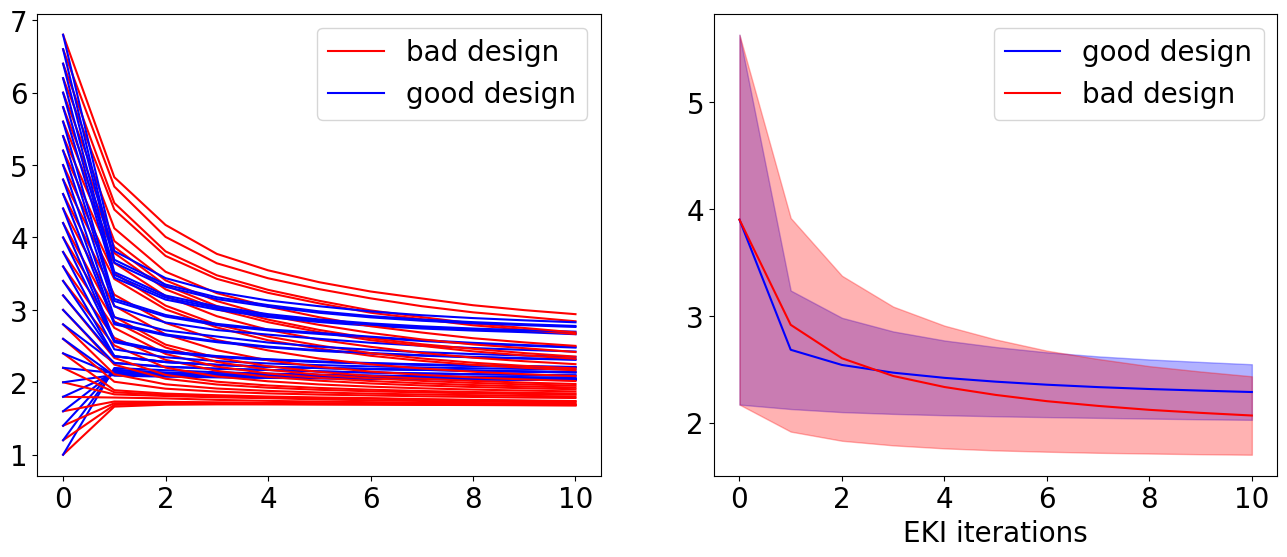

In [41]:
font_size = 20


plt.rc('font', size=font_size)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for i in range(sample_size):
    axes[0].plot(params_trajectory_bad_design[:,i],color='r',label='bad design')
    axes[0].plot(params_trajectory_good_design[:,i],color='b',label='good design')
    if i==0:
        axes[0].legend()

mean_values_bad_design = np.mean(params_trajectory_bad_design, axis=1)
variance_values_bad_design = np.var(params_trajectory_bad_design, axis=1)
mean_values_good_design = np.mean(params_trajectory_good_design, axis=1)
variance_values_good_design = np.var(params_trajectory_good_design, axis=1)

axes[1].plot(mean_values_good_design,color='b',label='good design')
axes[1].fill_between(range(step+1),mean_values_good_design+np.sqrt(variance_values_good_design),mean_values_good_design-np.sqrt(variance_values_good_design),color='b',alpha=0.3)
axes[1].plot(mean_values_bad_design,color='r',label='bad design')
axes[1].fill_between(range(step+1),mean_values_bad_design+np.sqrt(variance_values_bad_design),mean_values_bad_design-np.sqrt(variance_values_bad_design),color='r',alpha=0.3)
axes[1].legend(fontsize=font_size)
axes[1].set_xlabel('EKI iterations')

In [46]:
print('observation = ', observation)

false_center = jnp.array([1.0,1.0]) - d_start
false_start = jnp.array([0.5, 0.5])
_, output_all  = sealed_convection_diffusion_exp_parametic(false_start, false_center, stage,mean_values_good_design[-1])
output_all_central_sym = jnp.fliplr(jnp.flipud(output_all))
xb_lo = int((0.0 - lo_b) / (up_b - lo_b) * (size - 1))
xb_up = int((1.0 - lo_b) / (up_b - lo_b) * (size - 1))
output_for_xb = output_all_central_sym[xb_lo:(xb_up+1),xb_lo:(xb_up+1)]
loglikelihood = jax.scipy.stats.norm.logpdf(output_for_xb, loc=observation, scale=noise_base_scale+noise_ratio_scale*observation)
log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
indices = jnp.argpartition(log_evidence_list.ravel(), -15)[-15:]
multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)
average_x = np.mean(multi_indices[0])
average_y = np.mean(multi_indices[1])

print('center of good design =', np.array([average_x, average_y])/50)
print('theta_s of good design = ',mean_values_good_design[-1])
print('result of good design = ',jax.scipy.ndimage.map_coordinates(output_for_xb,[average_x,average_y],1))

_, output_all  = sealed_convection_diffusion_exp_parametic(false_start, false_center, stage,mean_values_bad_design[-1])
output_all_central_sym = jnp.fliplr(jnp.flipud(output_all))
xb_lo = int((0.0 - lo_b) / (up_b - lo_b) * (size - 1))
xb_up = int((1.0 - lo_b) / (up_b - lo_b) * (size - 1))
output_for_xb = output_all_central_sym[xb_lo:(xb_up+1),xb_lo:(xb_up+1)]
loglikelihood = jax.scipy.stats.norm.logpdf(output_for_xb, loc=observation, scale=noise_base_scale+noise_ratio_scale*observation)
log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
indices = jnp.argpartition(log_evidence_list.ravel(), -15)[-15:]
multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)
average_x = np.mean(multi_indices[0])
average_y = np.mean(multi_indices[1])

print('center of bad design =', np.array([average_x, average_y])/50)
print('theta_s of bad design = ',mean_values_bad_design[-1])
print('result of bad design = ',jax.scipy.ndimage.map_coordinates(output_for_xb,[average_x,average_y],1))

observation =  0.3007918
center of good design = [0.45466667 0.22666667]
theta_s of good design =  2.2862855195999146
result of good design =  0.3187188
center of bad design = [0.45200002 0.22800002]
theta_s of bad design =  2.0665767153104144
result of bad design =  0.29369783


In [ ]:
# 控制center不变

def forward_epistemic_model_from_initial(u,center,params,stage):
    '''
    用于kalmen方法的前进模型
    给定一个时刻的场,输出下一个时刻的场.时刻用stage标记.
    输出一个len=2的tuple.第一个元素是场的tuple,第二个元素是时间
    使用u[0][0].array.data提取数据

    stage是当前阶段的标记，当前阶段的样本x中的场是上一个阶段来的，因此前进模型的开始计算时间是上一个阶段的时间
    '''
    steps = 100*(stage+1)
    
    dt= 0.0005
    grid = cfd.grids.Grid((size, size), domain=((lo_b, up_b), (lo_b, up_b)))
    
    center_x= center[0]
    center_y= center[1]

    rollout_fn = jax.jit(my_funcutils.trajectory(my_equations.implicit_convection_diffusion3(
            density=density, viscosity=viscosity, dt=dt, grid=grid, forcing = my_forcing.exponential_force_adjustable(grid,center_x=center_x, center_y=center_y, theta_s=params)), steps))

    time = 0.0

    last_step, _ = rollout_fn(u,time)
    return last_step[0][0].data

def get_tem_u_f(sample, d_start,center):
    # 这个sample就是状态x
    tem_field = get_tem_field(sample)
    tem_param_dict = get_tem_param_dict(sample)
    return forward_epistemic_model(tem_field, center, tem_param_dict,params)

def get_y_f(tem_u_f, d_start):
    i = (d_start[0] - lo_b) / (up_b - lo_b) * (size - 1)
    j = (d_start[1] - lo_b) / (up_b - lo_b) * (size - 1)
    return jax.scipy.ndimage.map_coordinates(tem_u_f, [i, j], order=1)

def get_tem_field(sample):
    sample_field = sample[:size*size].reshape(size,size)
    return reconstruct_array_to_field(sample_field)

def get_tem_param_dict(sample):
    sample_netparams = sample[size*size:]
    return sample_netparams


def EnKF_process_fixCenter(d_start, estimated_center, observation, ensemble_member, stage, local_step):
    # 进行一次EnKF更新
    # 这个代码是不能够并行的

    # 生成初始状态的场
    # 直接在外面生成一个导入
    # 从这个场，用ensemble menber更新到现在

    # noise_info, lo_b, up_b, size, num_top 是全局变量
    
    ensemble_size_local = ensemble_member.shape[0]


    y_fs = jnp.zeros((ensemble_size_local,1))
    for i in range(ensemble_size_local):
        y_f, _  = sealed_convection_diffusion_exp_parametic(d_start, estimated_center, stage, ensemble_member[i])
        y_fs = y_fs.at[i,0].set(y_f)
    
    y_f_mean = jnp.mean(y_fs)
    P_yy = 1/(ensemble_size_local-1)*jnp.sum((y_fs-y_f_mean)**2)+1e-2#noise_base_scale

    x_f_theta = ensemble_member.reshape(ensemble_size_local,-1)
    x_f_mean = jnp.mean(x_f_theta, axis=0).reshape(1,-1)

    x_f_deviation = x_f_theta - x_f_mean
    y_f_deviation = y_fs - y_f_mean.reshape(1,1)
    P_xy = jnp.matmul(x_f_deviation.T, y_f_deviation) / (ensemble_size_local - 1) 

    K = P_xy * 1.0/P_yy
    x_a = x_f_theta + 0.7*jnp.matmul(K, (observation - y_fs).T).T
    
    x_a_mean = np.mean(x_a, axis=0)
    inflation_factor = 1.1#*0.985**local_step # 或其他合适的值
    x_a = x_a_mean + inflation_factor * (x_a - x_a_mean) # 膨胀因子
    
    theta_samples_updated = x_a[:, -1]
    return theta_samples_updated




data = np.load("theta_s_trajectory_simple_case_seed_2022.npz")

# 读取数组
values = data['arr_0']
count_step_list = data['arr_1']
design_list = data['arr_2']
params_at_stage_end_list = data['arr_3']
del data

data = np.load("posterior_simple_case_seed_2022.npz")
#data = np.load("posterior_simple_case_seed_812.npz")

# 由于保存时使用了无名参数，加载后的数据将用'arr_0', 'arr_1'等键来访问
loaded_list = [data[f'arr_{i}'] for i in range(n_stage)]
del data

stage = 5

step = 10
sample_size = 30#15
current_params = params_at_stage_end_list[stage]
#ensemble_params = (current_params+jnp.arange(0,sample_size)*jnp.array([0.2])).reshape(sample_size)

d_start = design_list[stage+1]
prior = loaded_list[stage-1]

_, posterior, observation = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], theta_true)
prior = posterior
del posterior

noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]
false_center = jnp.array([1.0,1.0]) - d_start
false_start = jnp.array([0.5, 0.5])
_, output_all  = sealed_convection_diffusion_exp_parametic(false_start, false_center, stage, current_params)
output_all_central_sym = jnp.fliplr(jnp.flipud(output_all))
xb_lo = int((0.0 - lo_b) / (up_b - lo_b) * (size - 1))
xb_up = int((1.0 - lo_b) / (up_b - lo_b) * (size - 1))
output_for_xb = output_all_central_sym[xb_lo:(xb_up+1),xb_lo:(xb_up+1)]
loglikelihood = jax.scipy.stats.norm.logpdf(output_for_xb, loc=observation, scale=noise_base_scale+noise_ratio_scale*observation)
log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
indices = jnp.argpartition(log_evidence_list.ravel(), -15)[-15:]
multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)
average_x = np.mean(multi_indices[0])/50
average_y = np.mean(multi_indices[1])/50
estimated_center = np.array([average_x, average_y])
print('estimated_center is ', estimated_center)

d_start1 = jnp.array([0.35, 0.15])
d_start2 = jnp.array([0.35, 0.35])
key_ensemble = jax.random.PRNGKey(2023)

for j in range(2):
    if j==0:
        d_start = d_start1
    elif j==1:
        d_start = d_start2
    
    prior = loaded_list[stage-1]
    observation, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
    
    ensemble_params = (current_params+1+2*jax.random.normal(key_ensemble, shape=(sample_size,))).squeeze()#(jnp.array([1.0])+jnp.arange(0,sample_size)*jnp.array([0.2])).reshape(sample_size)
    
    
    
    params_trajectory = np.zeros((step+1,sample_size))
    params_trajectory[0,:] = ensemble_params
    

    for i in range(step):
        ensemble_params =EnKF_process_fixCenter(d_start, estimated_center, observation, ensemble_params, stage, i)
        params_trajectory[i+1,:]=ensemble_params
        print('-',end='')

    if j==0:
        params_trajectory_bad_design = params_trajectory
    elif j==1:
        params_trajectory_good_design = params_trajectory

    print('|',end='')

In [ ]:
font_size = 20


plt.rc('font', size=font_size)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for i in range(sample_size):
    axes[0].plot(params_trajectory_bad_design[:,i],color='r',label='bad design')
    axes[0].plot(params_trajectory_good_design[:,i],color='b',label='good design')
    if i==0:
        axes[0].legend()

mean_values_bad_design = np.mean(params_trajectory_bad_design, axis=1)
variance_values_bad_design = np.var(params_trajectory_bad_design, axis=1)
mean_values_good_design = np.mean(params_trajectory_good_design, axis=1)
variance_values_good_design = np.var(params_trajectory_good_design, axis=1)

axes[1].plot(mean_values_good_design,color='b',label='good design')
axes[1].fill_between(range(step+1),mean_values_good_design+np.sqrt(variance_values_good_design),mean_values_good_design-np.sqrt(variance_values_good_design),color='b',alpha=0.3)
axes[1].plot(mean_values_bad_design,color='r',label='bad design')
axes[1].fill_between(range(step+1),mean_values_bad_design+np.sqrt(variance_values_bad_design),mean_values_bad_design-np.sqrt(variance_values_bad_design),color='r',alpha=0.3)
axes[1].legend(fontsize=font_size)
axes[1].set_xlabel('EKI iterations')

axes[1].axhline(theta_true, linestyle='--', color='y')

In [108]:
print('observation = ', observation)

_, u0 = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)

y1, u1  = sealed_convection_diffusion_exp_parametic(d_start1, estimated_center, stage, mean_values_good_design[-1])
error1 = np.sum((u0-u1)**2)
print('theta_s of good design = ',mean_values_good_design[-1])
print('result of good design = ', y1)
print('total loss of good design = ', error1)

y2, u2  = sealed_convection_diffusion_exp_parametic(d_start2, estimated_center, stage, mean_values_bad_design[-1])
error2 = np.sum((u0-u2)**2)
print('theta_s of bad design = ',mean_values_bad_design[-1])
print('result of bad design = ', y2)
print('total loss of bad design = ', error2)

observation =  0.3007918
theta_s of good design =  2.0562639514605205
result of good design =  0.22734016
total loss of good design =  0.50091934
theta_s of bad design =  1.8629190723101299
result of bad design =  0.28707504
total loss of bad design =  1.4302826


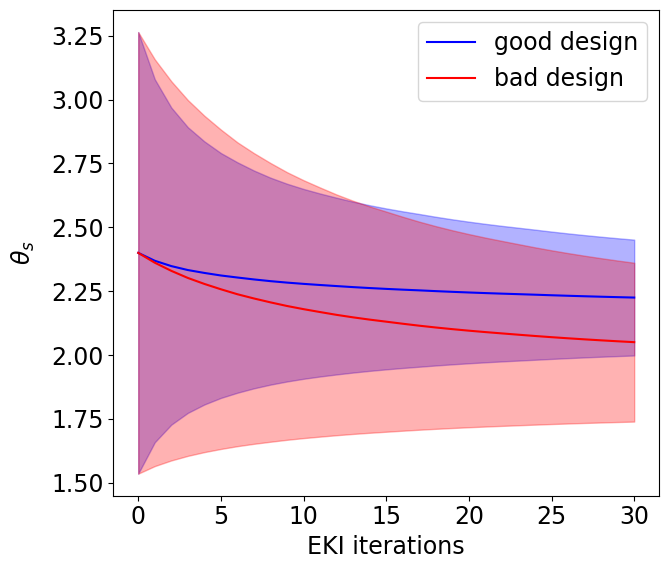

In [61]:
font_size = 17


plt.rc('font', size=font_size)

plt.figure(figsize=(7, 6))

mean_values_bad_design = np.mean(params_trajectory_bad_design, axis=1)
variance_values_bad_design = np.var(params_trajectory_bad_design, axis=1)
mean_values_good_design = np.mean(params_trajectory_good_design, axis=1)
variance_values_good_design = np.var(params_trajectory_good_design, axis=1)

plt.plot(mean_values_good_design,color='b',label='good design')
plt.fill_between(range(step+1),mean_values_good_design+np.sqrt(variance_values_good_design),mean_values_good_design-np.sqrt(variance_values_good_design),color='b',alpha=0.3)
plt.plot(mean_values_bad_design,color='r',label='bad design')
plt.fill_between(range(step+1),mean_values_bad_design+np.sqrt(variance_values_bad_design),mean_values_bad_design-np.sqrt(variance_values_bad_design),color='r',alpha=0.3)
plt.legend()
plt.xlabel('EKI iterations')
plt.ylabel('$\\theta_s$',labelpad=10)
plt.tight_layout()
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.savefig('EnKF_simpleCase.png',dpi=300,bbox_inches='tight')

[0.35 0.35]


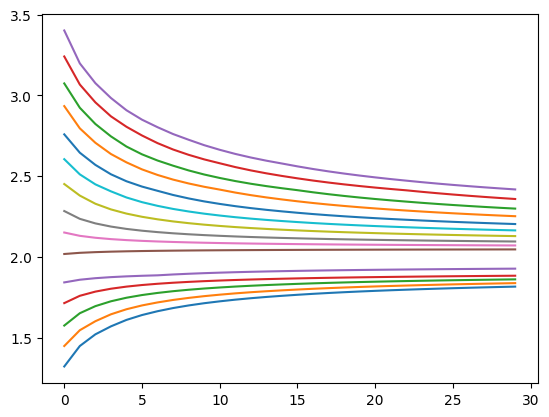

In [176]:
print(d_start)
for i in range(sample_size):
    plt.plot(params_trajectory[:,i])

params_trajectory_good_design = params_trajectory

[0.35 0.15]


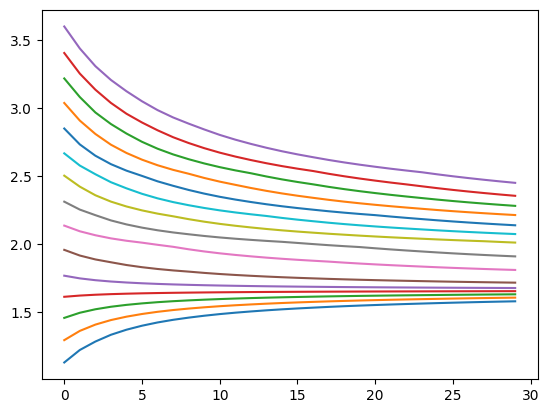

In [178]:
print(d_start)
for i in range(sample_size):
    plt.plot(params_trajectory[:,i])

params_trajectory_bad_design = params_trajectory

In [138]:
jnp.array([1.0])+jnp.arange(0,sample_size)*jnp.array([0.2])

Array([1. , 1.2, 1.4], dtype=float32)

In [114]:
tem_u_fs.reshape(3,-1).shape,ensemble_member.shape,jnp.concatenate([tem_u_fs.reshape(3,-1), ensemble_member.reshape(3,-1)], axis=1).shape

((3, 63001), (3,), (3, 63002))

In [155]:
stage = 3
ensemble_member = jnp.array([2.0,3.0,1.0])
sample_size = 3
tem_u_fs = jax.vmap(forward_epistemic_model_from_initial, in_axes=(None, None, 0, None))(G0,center,ensemble_member,stage)
y_fs = jax.vmap(get_y_f, in_axes=(0, None))(tem_u_fs, d_start).reshape(-1, 1)

y_f_mean = jnp.mean(y_fs)
P_yy = 1/(ensemble_size-1)*jnp.sum((y_fs-y_f_mean)**2)+noise_base_scale

tem_u_fs_array = tem_u_fs.reshape(sample_size,-1) # 要把预测数据和参数拼接在一起，需要调整尺寸
x_f = jnp.concatenate([tem_u_fs_array, ensemble_member.reshape(sample_size,-1)], axis=1)
x_f_mean = jnp.mean(x_f, axis=0).reshape(1,-1)
x_f_deviation = x_f - x_f_mean
y_f_deviation = y_fs - y_f_mean.reshape(1,1)
P_xy = jnp.matmul(x_f_deviation.T, y_f_deviation) / (ensemble_size - 1) 

K = P_xy * 1.0/P_yy
x_a = x_f + jnp.matmul(K, (observation - y_fs).T).T

theta_samples_updated = x_a[:, -1]
print(theta_samples_updated)

def EnKF_process(d_start, observation, ensemble_member, center, stage, G0):
    # 进行一次更新

    # 生成初始状态的场
    # 直接在外面生成一个导入
    # 从这个场，用ensemble menber更新到现在
    ensemble_size_local = ensemble_member.shape[0]
    
    tem_u_fs = jax.vmap(forward_epistemic_model_from_initial, in_axes=(None, None, 0, None))(G0,center,ensemble_member,stage)
    y_fs = jax.vmap(get_y_f, in_axes=(0, None))(tem_u_fs, d_start).reshape(-1, 1)

    y_f_mean = jnp.mean(y_fs)
    P_yy = 1/(ensemble_size_local-1)*jnp.sum((y_fs-y_f_mean)**2)+noise_base_scale

    tem_u_fs_array = tem_u_fs.reshape(ensemble_size_local,-1)
    x_f = jnp.concatenate([tem_u_fs_array, ensemble_member.reshape(ensemble_size_local,-1)], axis=1)
    x_f_mean = jnp.mean(x_f, axis=0).reshape(1,-1)

    x_f_deviation = x_f - x_f_mean
    y_f_deviation = y_fs - y_f_mean.reshape(1,1)
    P_xy = jnp.matmul(x_f_deviation.T, y_f_deviation) / (ensemble_size_local - 1) 

    K = P_xy * 1.0/P_yy
    x_a = x_f + jnp.matmul(K, (observation - y_fs).T).T
    
    theta_samples_updated = x_a[:, -1]
    return theta_samples_updated

EnKF_process(d_start, observation, ensemble_member, center, stage, G0)

def EnKF_process_correct(d_start, observation, ensemble_member, stage, G0):
    # 进行一次EnKF更新
    # 这个代码是不能够并行的

    # 生成初始状态的场
    # 直接在外面生成一个导入
    # 从这个场，用ensemble menber更新到现在
    ensemble_size_local = ensemble_member.shape[0]


    y_fs = jnp.zeros((ensemble_size_local,1))
    for i in range(ensemble_size_local):
        noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]
        false_center = jnp.array([1.0,1.0]) - d_start
        false_start = jnp.array([0.5, 0.5])
        _, output_all  = sealed_convection_diffusion_exp_parametic(false_start, false_center, stage, ensemble_member[i])
        output_all_central_sym = jnp.fliplr(jnp.flipud(output_all))
        xb_lo = int((0.0 - lo_b) / (up_b - lo_b) * (size - 1))
        xb_up = int((1.0 - lo_b) / (up_b - lo_b) * (size - 1))
        output_for_xb = output_all_central_sym[xb_lo:(xb_up+1),xb_lo:(xb_up+1)]
        loglikelihood = jax.scipy.stats.norm.logpdf(output_for_xb, loc=observation, scale=noise_base_scale+noise_ratio_scale*observation)
        log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
        indices = jnp.argpartition(log_evidence_list.ravel(), -num_top)[-num_top:]
        multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)

        average_x = np.mean(multi_indices[0])
        average_y = np.mean(multi_indices[1])
        
        y_f = jax.scipy.ndimage.map_coordinates(output_for_xb,[average_x,average_y],1)
        y_fs = y_fs.at[i,0].set(y_f)
    
    y_f_mean = jnp.mean(y_fs)
    P_yy = 1/(ensemble_size_local-1)*jnp.sum((y_fs-y_f_mean)**2)+noise_base_scale

    x_f_theta = ensemble_member.reshape(ensemble_size_local,-1)
    x_f_mean = jnp.mean(x_f_theta, axis=0).reshape(1,-1)

    x_f_deviation = x_f - x_f_mean
    y_f_deviation = y_fs - y_f_mean.reshape(1,1)
    P_xy = jnp.matmul(x_f_deviation.T, y_f_deviation) / (ensemble_size_local - 1) 

    K = P_xy * 1.0/P_yy
    x_a = x_f + jnp.matmul(K, (observation - y_fs).T).T
    
    theta_samples_updated = x_a[:, -1]
    return theta_samples_updated

EnKF_process_correct(d_start, observation, ensemble_member, stage, G0)

[1.9993297 2.5584373 1.4402219]


Array([2.0214798, 2.7036633, 1.3936322], dtype=float32)

In [150]:
ensemble_size_local = ensemble_member.shape[0]


y_fs = jnp.zeros(ensemble_size_local)
for i in range(ensemble_size_local):
    noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]
    false_center = jnp.array([1.0,1.0]) - d_start
    false_start = jnp.array([0.5, 0.5])
    _, output_all  = sealed_convection_diffusion_exp_parametic(false_start, false_center, stage, ensemble_member[i])
    output_all_central_sym = jnp.fliplr(jnp.flipud(output_all))
    xb_lo = int((0.0 - lo_b) / (up_b - lo_b) * (size - 1))
    xb_up = int((1.0 - lo_b) / (up_b - lo_b) * (size - 1))
    output_for_xb = output_all_central_sym[xb_lo:(xb_up+1),xb_lo:(xb_up+1)]
    loglikelihood = jax.scipy.stats.norm.logpdf(output_for_xb, loc=observation, scale=noise_base_scale+noise_ratio_scale*observation)
    log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
    indices = jnp.argpartition(log_evidence_list.ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)

    average_x = np.mean(multi_indices[0])
    average_y = np.mean(multi_indices[1])
    
    y_f = jax.scipy.ndimage.map_coordinates(output_for_xb,[average_x,average_y],1)
    y_fs = y_fs.at[i].set(y_f)

y_f_mean = jnp.mean(y_fs)
P_yy = 1/(ensemble_size_local-1)*jnp.sum((y_fs-y_f_mean)**2)+noise_base_scale

x_f_theta = ensemble_member.reshape(ensemble_size_local,-1)
x_f_mean = jnp.mean(x_f_theta, axis=0).reshape(1,-1)

x_f_deviation = x_f_theta - x_f_mean
y_f_deviation = y_fs - y_f_mean.reshape(1,1)

In [151]:
x_f_theta, x_f_mean, x_f_deviation, y_f_deviation

(Array([[2.],
        [3.],
        [1.]], dtype=float32),
 Array([[2.]], dtype=float32),
 Array([[ 0.],
        [ 1.],
        [-1.]], dtype=float32),
 Array([[ 0.00852436,  0.15810394, -0.16662832]], dtype=float32))

In [154]:
x_f_deviation.T.shape, y_f_deviation.shape

((1, 3), (1, 3))

In [ ]:
P_xy = jnp.matmul(x_f_deviation.T, y_f_deviation) / (ensemble_size_local - 1) 

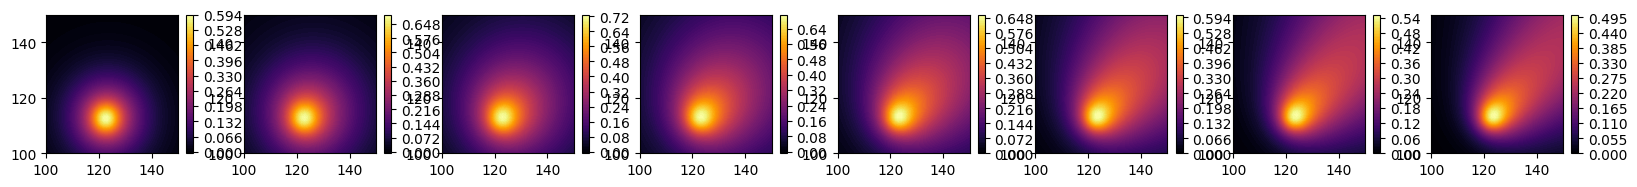

In [67]:
fig, axes = plt.subplots(1, 8, figsize=(20, 1.8))

for i in range(8):
    stage = i
    tem_u = forward_epistemic_model_from_initial(G0,center,2.0,stage)
    contour = axes[i].contourf(tem_u[0][0].data.T, levels=100, cmap='inferno')
    axes[i].set_xlim([100,150])
    axes[i].set_ylim([100,150])
    fig.colorbar(contour, ax=axes[i])

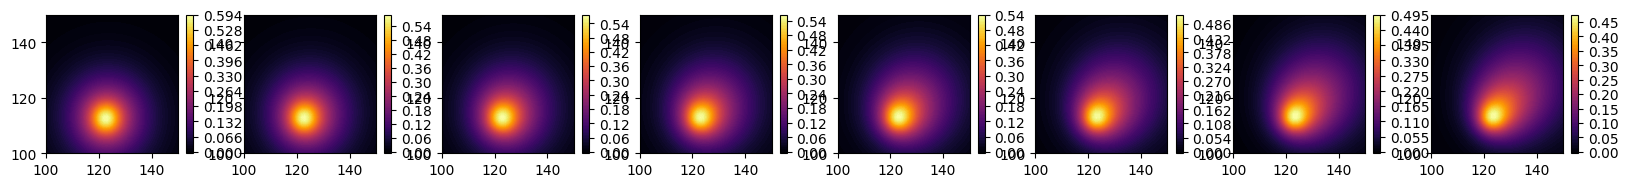

In [66]:
fig, axes = plt.subplots(1, 8, figsize=(20, 1.8))

for i in range(8):
    stage = i
    tem_u = forward_epistemic_model(G0,center,2.0,stage)
    contour = axes[i].contourf(tem_u[0][0].data.T, levels=100, cmap='inferno')
    axes[i].set_xlim([100,150])
    axes[i].set_ylim([100,150])
    fig.colorbar(contour, ax=axes[i])

In [40]:
current_params = jnp.arange(jnp.array([1.0]), jnp.array([1.0]) + 0.2 * sample_size, 0.2)
current_params

ValueError: jax.numpy.arange: arguments must be scalars; got start=[1.]

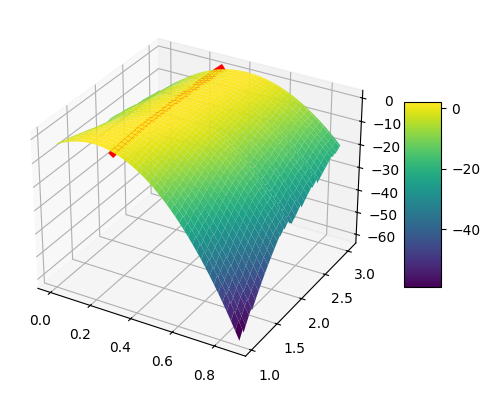

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# 创建 x 和 y 的网格
y = ensemble_member[0]
x = observation_array
X, Y = np.meshgrid(x, y)

# 创建一个新的图形和 3D 轴
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 使用 plot_surface 绘制 3D 表面图
surf = ax.plot_surface(X, Y, likelihood_contour, cmap='viridis')

# 添加 colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

x_index = np.argmin(np.abs(x - observation))
ax.plot([observation]*len(y), y, likelihood_contour[:, x_index], color='r', linewidth=5)


# 显示图形
plt.show()

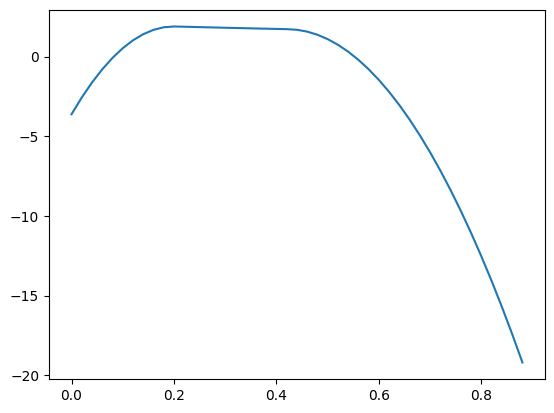

In [76]:
max_along_rows = np.max(likelihood_contour, axis=0)
plt.plot(observation_array, max_along_rows)

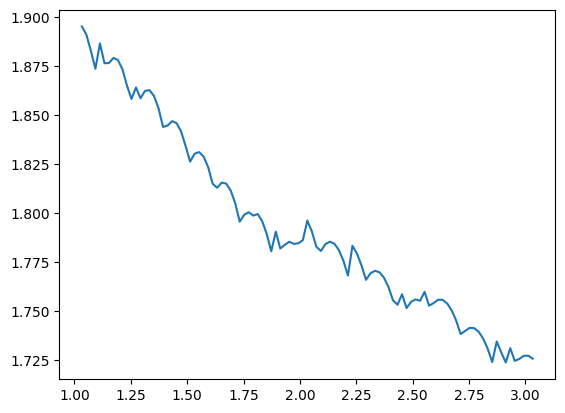

In [74]:
max_along_columns = np.max(likelihood_contour, axis=1)
plt.plot(ensemble_member[0],max_along_columns)

# 对于不同theta——s，不同的测量值能够使它们各自得到不同的likelihood。这可能是由于坟墓中是forecast导致的，这个图像没有实际的物理意义

current design is (0.35, 0.15)
optimized theta_s is 1.633070945739746
max log likelihood is 1.8000495433807373


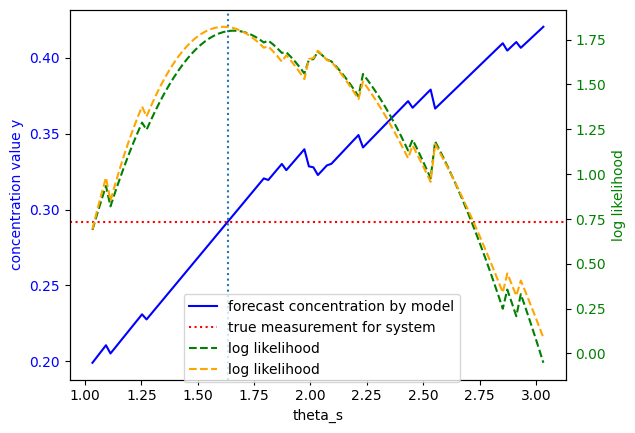

theta_oed is [0.43866667 0.22266668], distance is 0.03866663575172424


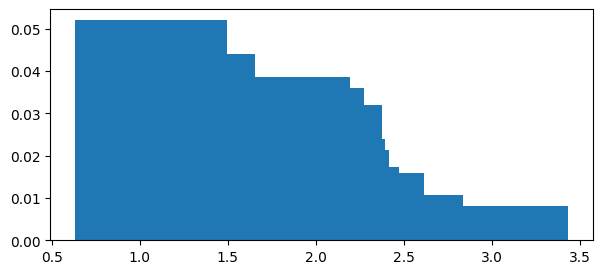

In [289]:
fig, ax1 = plt.subplots()

i_to_plot = 0
j_to_plot = 0

x_min, x_max, x_step = 0.35, 0.5, 0.1
y_min, y_max, y_step = 0.15, 0.3, 0.1
x_values = np.arange(x_min, x_max + x_step, x_step)
y_values = np.arange(y_min, y_max + y_step, y_step)

print(f'current design is {x_values[j_to_plot],y_values[i_to_plot]}')

# 在第一个 y 轴上绘制 'forecast concentration by model' 和 'true measurement for system'
ax1.plot(ensemble_member[0], y_f_list[i_to_plot,j_to_plot,:], 'b', label='forecast concentration by model')
ax1.set_xlabel('theta_s')
ax1.set_ylabel('concentration value y', color='b')
ax1.axhline(observation_list[i_to_plot,j_to_plot], linestyle=':', color='r', label='true measurement for system')

# 设置 ax1 y 轴的颜色
ax1.tick_params(axis='y', labelcolor='b')

# 创建第二个 y 轴共享 x 轴
ax2 = ax1.twinx()
ax2.plot(ensemble_member[0], -ensemble_negtive_likelihood_values[i_to_plot,j_to_plot,:], linestyle='--',label='log likelihood', color='g')
ax2.plot(ensemble_member[0], -ensemble_negtive_likelihood_values_reverse[i_to_plot,j_to_plot,:], linestyle='--',label='log likelihood', color='orange')

# 设置第二个 y 轴的标签
ax2.set_ylabel('log likelihood', color='g')

# 设置 ax2 y 轴的颜色
ax2.tick_params(axis='y', labelcolor='g')

# 添加图例
fig.legend(bbox_to_anchor=(0.8,0.25), bbox_transform=ax1.transAxes)

indices = np.where(np.abs(y_f_list[i_to_plot, j_to_plot, :] - observation_list[i_to_plot,j_to_plot]) <= 0.005)[0][1]
ax1.axvline(ensemble_member[0][indices],linestyle=':')

print(f'optimized theta_s is {ensemble_member[0][indices]}')
print(f'max log likelihood is {np.max(-ensemble_negtive_likelihood_values[i_to_plot,j_to_plot,:])}')
#print(f'max reverse log likelihood is {np.max(-ensemble_negtive_likelihood_values_reverse[i_to_plot,j_to_plot,:])}')

# 显示图形
plt.show()

plt.figure(figsize=(7,3))
distance = np.zeros(ensemble_size)
for i in range(ensemble_size):
    distance[i] = np.sqrt(np.sum(posterior_sample_list[i_to_plot,j_to_plot,i,:] - center)**2)

plt.bar(ensemble_member[0], distance)
print(f'theta_oed is {posterior_sample_list[i_to_plot,j_to_plot,indices,:]}, distance is {distance[indices]}')

In [258]:
def print_info(d_start, posterior_sample, theta_s):
    distance_sample = np.sqrt(np.sum(posterior_sample - center)**2)
    y,_ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, 2)
    y_f,_ = sealed_convection_diffusion_exp_parametic(d_start, posterior_sample, stage, theta_s)
    print(f'for design = {d_start}, distance = {distance_sample}, y = {y}, y_f = {y_f}, y-y_f = {y-y_f}, (y-y_f)/y = {(y-y_f)/y}')
    print(f'log likelihood is {jax.scipy.stats.norm.logpdf(y_f, loc=y, scale=noise_base_scale+noise_ratio_scale*y)}, reverse log likelihood is {jax.scipy.stats.norm.logpdf(y, loc=y_f, scale=noise_base_scale+noise_ratio_scale*y_f)},')

posterior_sample = jnp.array([0.42,0.22])
theta_s = jnp.array([1.8])
d_start = jnp.array([0.55,0.35])
print_info(d_start, posterior_sample, theta_s)

d_start = jnp.array([0.35,0.35])
print_info(d_start, posterior_sample, theta_s)

d_start = jnp.array([0.35,0.15])
print_info(d_start, posterior_sample, theta_s)
# 对u有同一个theta_s,更好的design使得likelihood更大，可以据此优化design

for design = [0.55 0.35], distance = 0.06000000238418579, y = 0.5436253547668457, y_f = 0.44103333353996277, y-y_f = 0.10259202122688293, (y-y_f)/y = 0.18871824443340302
log likelihood is 0.7592275142669678, reverse log likelihood is 0.697733998298645,
for design = [0.35 0.35], distance = 0.06000000238418579, y = 0.39682888984680176, y_f = 0.38040781021118164, y-y_f = 0.016421079635620117, (y-y_f)/y = 0.041380755603313446
log likelihood is 1.7149485349655151, reverse log likelihood is 1.726112723350525,
for design = [0.35 0.15], distance = 0.06000000238418579, y = 0.29200780391693115, y_f = 0.36213216185569763, y-y_f = -0.07012435793876648, (y-y_f)/y = -0.2401454895734787
log likelihood is 1.2314305305480957, reverse log likelihood is 1.2376773357391357,


In [274]:
d_start = jnp.array([0.55,0.35])

posterior_sample = jnp.array([0.42,0.22])
theta_s = jnp.array([1.8])
print_info(d_start, posterior_sample, theta_s)

posterior_sample = jnp.array([0.42,0.2])
theta_s = jnp.array([1.862])
print_info(d_start, posterior_sample, theta_s)

posterior_sample = jnp.array([0.45,0.25])
theta_s = jnp.array([2])
print_info(d_start, posterior_sample, theta_s)

for design = [0.55 0.35], distance = 0.06000000238418579, y = 0.5436253547668457, y_f = 0.44103333353996277, y-y_f = 0.10259202122688293, (y-y_f)/y = 0.18871824443340302
log likelihood is 0.7592275142669678, reverse log likelihood is 0.697733998298645,
for design = [0.55 0.35], distance = 0.07999999821186066, y = 0.5436253547668457, y_f = 0.4409645199775696, y-y_f = 0.10266083478927612, (y-y_f)/y = 0.18884481489658356
log likelihood is 0.75804203748703, reverse log likelihood is 0.6963245868682861,
for design = [0.55 0.35], distance = 0.0, y = 0.5436253547668457, y_f = 0.5436252951622009, y-y_f = 5.960464477539063e-08, (y-y_f)/y = 1.0964286900616571e-07
log likelihood is 1.6426600217819214, reverse log likelihood is 1.6426600217819214,


In [283]:
posterior_sample = jnp.array([0.45,0.2])
theta_s = jnp.array([2.275])
print_info(d_start, posterior_sample, theta_s)

posterior_sample = jnp.array([0.45,0.22])
theta_s = jnp.array([2.275])
print_info(d_start, posterior_sample, theta_s)

posterior_sample = jnp.array([0.45,0.25])
theta_s = jnp.array([2])
print_info(d_start, posterior_sample, theta_s)

for design = [0.55 0.35], distance = 0.04999999701976776, y = 0.5436253547668457, y_f = 0.5573119521141052, y-y_f = -0.013686597347259521, (y-y_f)/y = -0.025176525115966797
log likelihood is 1.626936912536621, reverse log likelihood is 1.618384599685669,
for design = [0.55 0.35], distance = 0.030000001192092896, y = 0.5436253547668457, y_f = 0.5820690989494324, y-y_f = -0.03844374418258667, (y-y_f)/y = -0.07071734964847565
log likelihood is 1.5186097621917725, reverse log likelihood is 1.4999655485153198,
for design = [0.55 0.35], distance = 0.0, y = 0.5436253547668457, y_f = 0.5436252951622009, y-y_f = 5.960464477539063e-08, (y-y_f)/y = 1.0964286900616571e-07
log likelihood is 1.6426600217819214, reverse log likelihood is 1.6426600217819214,


0 0 [0.35 0.15]
0 1 [0.45 0.15]
0 2 [0.55 0.15]
1 0 [0.35 0.25]
1 1 [0.45 0.25]
1 2 [0.55 0.25]
2 0 [0.35 0.35]
2 1 [0.45 0.35]
2 2 [0.55 0.35]


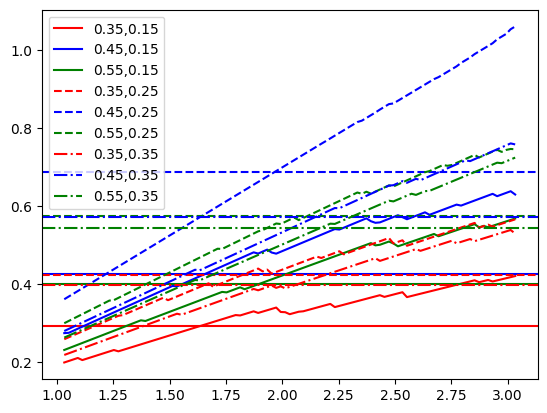

In [255]:
# 画出不同design时候各个theta_s得到的预测值

for (i, j), x in np.ndenumerate(xx):
    y = yy[i, j]
    if i==0:
        linestyle='-'
    if i==1:
        linestyle='--'
    if i==2:
        linestyle='-.'
    if j==0:
        color = 'r'
    if j==1:
        color = 'b'
    if j==2:
        color = 'g'
        
    d_start = jnp.array([x, y])
    print(i,j,d_start)
    plt.plot(ensemble_member[0],y_f_list[i,j,:],linestyle=linestyle,color = color,label=f'{x:.2f},{y:.2f}')
    plt.axhline(observation_list[i,j], linestyle=linestyle, color=color)

plt.legend()

In [177]:
np.where(np.abs(y_f_list[i_to_plot, j_to_plot, :] - observation_list[i_to_plot,j_to_plot]) <= 0.005)[0]

array([56, 57])

In [479]:
# 对于给定的design和theta_oed，优化theta_s


data = np.load("theta_s_trajectory_simple_case_seed_2022.npz")

# 读取数组
values = data['arr_0']
count_step_list = data['arr_1']
design_list = data['arr_2']
params_at_stage_end_list = data['arr_3']
del data

data = np.load("posterior_simple_case_seed_2022.npz")
#data = np.load("posterior_simple_case_seed_812.npz")

loaded_list = [data[f'arr_{i}'] for i in range(n_stage)]
del data

stage = 3
prior = loaded_list[stage-1]
current_params = params_at_stage_end_list[stage]
d_start = design_list[stage+1]


_, posterior = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], theta_true)
del prior
prior = posterior


indices = jnp.argpartition(prior.ravel(), -num_top)[-num_top:]
multi_indices = jnp.unravel_index(indices, prior.shape)
# 计算平均坐标
average_x = np.mean(multi_indices[0])
average_y = np.mean(multi_indices[1])
posterior_sample = jnp.array([average_x/50,average_y/50])
print(d_start)

[0.3875192  0.17286941]


In [465]:
#d_start = jnp.array([0.45,0.35])
y,_ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, 2)
theta_s = 1.635#stage=2 2.052
y_f,_ = sealed_convection_diffusion_exp_parametic(d_start, posterior_sample, stage, theta_s)
print(posterior_sample)
print(y,y_f)

[0.43866667 0.22266668]
0.4016539 0.40219986


In [ ]:
# 通过enumerate方法做优化

In [435]:
def optimize_d(d_start, posterior_sample, stage, current_params, y):
    y_f,_ = sealed_convection_diffusion_exp_parametic(d_start, posterior_sample, stage, current_params)
    return (y - y_f)**2
    
y_measure,_ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, 2)

x_min, x_max, x_step = 0.2, 0.6, 0.02
y_min, y_max, y_step = 0.05, 0.45, 0.02
x_values = np.arange(x_min, x_max + x_step, x_step)
y_values = np.arange(y_min, y_max + y_step, y_step)
total_points = len(x_values) * len(y_values)
xx, yy = np.meshgrid(x_values, y_values)

loss_matrix = np.zeros((len(x_values),len(y_values)))

for i in range(start_i, len(y_values)):
    for j in range(start_j if i == start_i else 0, len(x_values)):
        x = xx[i, j]
        y = yy[i, j]
        d_start = jnp.array([x, y])
        loss_matrix[i,j]=optimize_d(d_start, posterior_sample, stage, current_params, y_measure)
        print('.',end='')

.........................................................................................................................................................................................................................................................................................................................................................................................................................................................

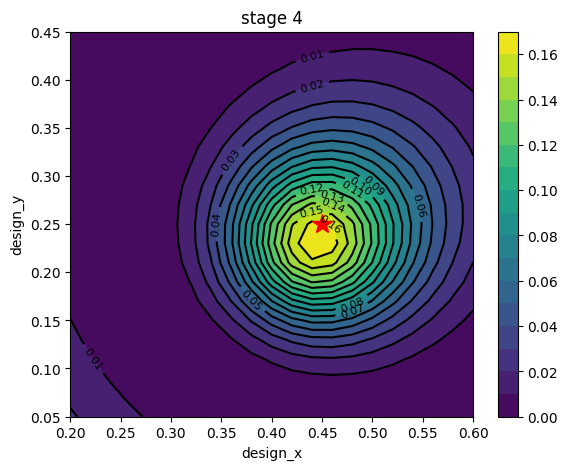

In [478]:
# 说明优化这个是不行的
plt.figure(figsize=(6.5,5))


contour = plt.contourf(xx, yy, loss_matrix, levels=20)

# 添加颜色条
plt.colorbar()
contours = plt.contour(xx, yy, loss_matrix, levels=20, colors='black')
plt.clabel(contours, inline=True, fontsize=8)

plt.plot(center[0],center[1],'*',color='r',markersize=15)
plt.xlabel('design_x')
plt.ylabel('design_y')
plt.title(f'stage {stage+1}')
plt.show()

In [466]:
# 梯度下降优化，结果基本一样
def loss_function(d, posterior_sample, stage, current_params, y):
    y_f, _ = sealed_convection_diffusion_exp_parametic(d, posterior_sample, stage, current_params)
    return jnp.sum((y - y_f)**2)

def optimize_d(d_start, posterior_sample, stage, current_params, y, num_steps=100):
    # 初始化 Optax 优化器（例如 Adam）
    optimizer = optax.adam(learning_rate=0.01)
    opt_state = optimizer.init(d_start)

    # 定义单步优化函数
    @jax.jit
    def step(d, opt_state):
        loss, grads = jax.value_and_grad(loss_function)(d, posterior_sample, stage, current_params, y)
        updates, opt_state = optimizer.update(grads, opt_state)
        d = optax.apply_updates(d, updates)
        return d, opt_state, loss

    # 进行多步优化
    d = d_start
    for _ in range(num_steps):
        d, opt_state, loss = step(d, opt_state)

    return d

# 示例使用
d_start = design_list[stage+1]  # 初始 d_start 值
y, _ = sealed_convection_diffusion_exp_parametic(d_start, posterior_sample, stage, 2)

# 优化 d_start
optimized_d = optimize_d(d_start, posterior_sample, stage, current_params, y)

In [467]:
optimized_d

Array([0.38672706, 0.17040864], dtype=float32)

In [436]:
current_params

array([[1.9140682]], dtype=float32)

In [445]:
min_value = np.min(loss_matrix)

# 找到最小值所在的位置
min_position = np.where(loss_matrix == min_value)
min_value, min_position,(xx[4, 5],yy[4, 5])

(8.983874977275264e-07, (array([4]), array([5])), (0.29999999999999993, 0.13))

In [468]:
d_start = jnp.array([0.437,0.234])
y_f,_ = sealed_convection_diffusion_exp_parametic(d_start, posterior_sample, stage, current_params)
print(y,y_f)
d_start = jnp.array([0.45,0.26])
y_f,_ = sealed_convection_diffusion_exp_parametic(d_start, posterior_sample, stage, current_params)
print(y,y_f)
d_start = jnp.array([0.45,0.3])
y_f,_ = sealed_convection_diffusion_exp_parametic(d_start, posterior_sample, stage, current_params)
print(y,y_f)
d_start = jnp.array([0.45,0.35])
y_f,_ = sealed_convection_diffusion_exp_parametic(d_start, posterior_sample, stage, current_params)
print(y,y_f)
d_start = jnp.array([0.5,0.35])
y_f,_ = sealed_convection_diffusion_exp_parametic(d_start, posterior_sample, stage, current_params)
print(y,y_f)
d_start = jnp.array([0.38,0.17])
y_f,_ = sealed_convection_diffusion_exp_parametic(d_start, posterior_sample, stage, current_params)
print(y,y_f)
d_start = jnp.array([0.3,0.13])
y_f,_ = sealed_convection_diffusion_exp_parametic(d_start, posterior_sample, stage, current_params)
print(y,y_f)

0.49198756 0.70669675
0.49198756 0.70416784
0.49198756 0.6354848
0.49198756 0.53585005
0.49198756 0.54318964
0.49198756 0.474852
0.49198756 0.2486671


In [473]:
d_start = jnp.array([0.3,0.13])
_, posterior = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], theta_true)

num_top = 15
indices = jnp.argpartition(posterior.ravel(), -num_top)[-num_top:]
multi_indices = jnp.unravel_index(indices, posterior.shape)
# 计算平均坐标
average_x = np.mean(multi_indices[0])
average_y = np.mean(multi_indices[1])
posterior_sample = jnp.array([average_x/50,average_y/50])
print(posterior_sample)
y,_ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, 2)
y_f,_ = sealed_convection_diffusion_exp_parametic(d_start, posterior_sample, stage, 1.73)
print(y,y_f)

[0.444 0.224]
0.20453241 0.2042243


In [396]:
0.365/2,0.167/2

(0.1825, 0.0835)

In [291]:
params_at_stage_end_list

array([[[3.       ]],

       [[1.8748358]],

       [[1.9140682]],

       [[2.033071 ]],

       [[1.8540454]],

       [[1.9648844]],

       [[1.7766172]],

       [[2.0042126]],

       [[1.7066988]]], dtype=float32)

In [150]:
index=45
ensemble_member[0][index], y_f_list[i_to_plot,j_to_plot,index]

(Array(1.933071, dtype=float32), 0.4078954756259918)

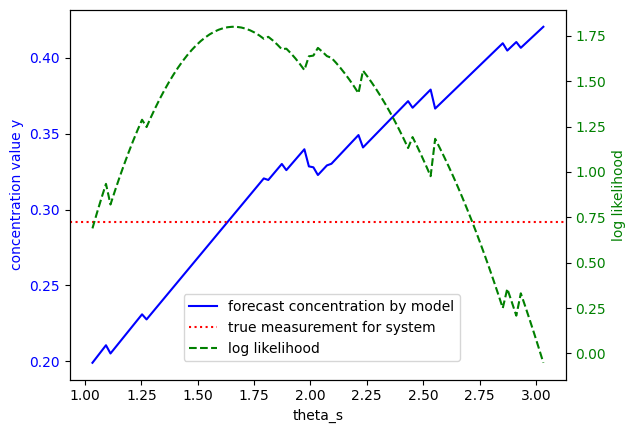

In [103]:
fig, ax1 = plt.subplots()

# 在第一个 y 轴上绘制 'forecast concentration by model' 和 'true measurement for system'
ax1.plot(ensemble_member[0], y_f_list, 'b', label='forecast concentration by model')
ax1.set_xlabel('theta_s')
ax1.set_ylabel('concentration value y', color='b')
ax1.axhline(observation, linestyle=':', color='r', label='true measurement for system')

# 设置 ax1 y 轴的颜色
ax1.tick_params(axis='y', labelcolor='b')

# 创建第二个 y 轴共享 x 轴
ax2 = ax1.twinx()
ax2.plot(ensemble_member[0], -ensemble_negtive_likelihood_values, linestyle='--',label='log likelihood', color='g')

# 设置第二个 y 轴的标签
ax2.set_ylabel('log likelihood', color='g')

# 设置 ax2 y 轴的颜色
ax2.tick_params(axis='y', labelcolor='g')

# 添加图例
fig.legend(bbox_to_anchor=(0.8,0.25), bbox_transform=ax1.transAxes)

# 显示图形
plt.show()

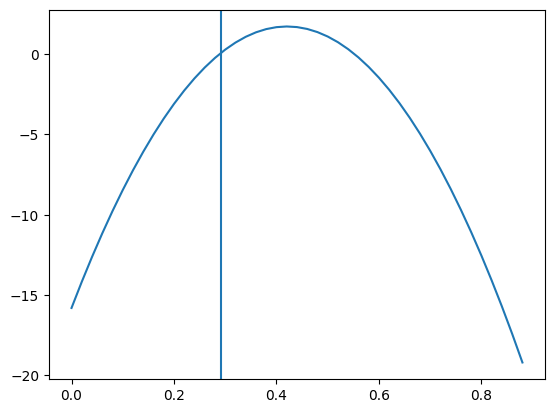

In [79]:
plt.plot(observation_array,loglikelihood_array)
plt.axvline(observation)
# 这个图是同一thetas得到的forecast下，不同的测量值各自对应的likelihood

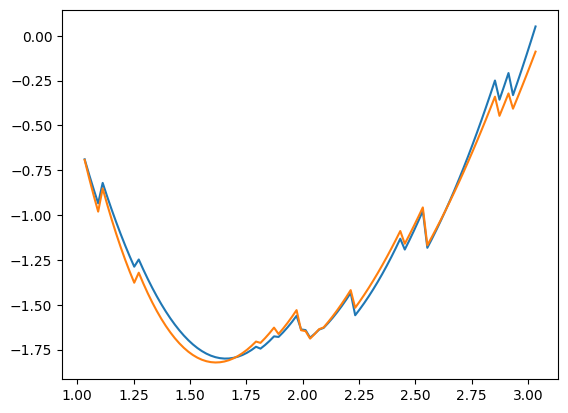

In [38]:
plt.plot(ensemble_member[0],ensemble_negtive_likelihood_values)
plt.plot(ensemble_member[0],ensemble_negtive_likelihood_values_reverse)
# 这个图像说明了把谁放在计算likelihood的后面不是决定性的因素

In [28]:
x_min, x_max, x_step = 0.2, 0.15, 0.1
y_min, y_max, y_step = 0.1, 0.05, 0.1
#x_min, x_max, x_step = 0.2, 0.6, 0.02
#y_min, y_max, y_step = 0.05, 0.45, 0.02

# 生成x和y的坐标值
x_values = np.arange(x_min, x_max + x_step, x_step)
y_values = np.arange(y_min, y_max + y_step, y_step)
total_points = len(x_values) * len(y_values)
total_points

1

In [4]:
a=jnp.array([[1,2],[3,4]])
b=jnp.array([3])
jax.scipy.stats.norm.logpdf(a, loc=b, scale=0.05+0.05*b),jax.scipy.stats.norm.logpdf(b, loc=a, scale=0.05+0.05*a)

(Array([[-49.309498  , -11.8095    ],
        [  0.69049937, -11.8095    ]], dtype=float32),
 Array([[-198.61633   ,  -21.24404   ],
        [   0.69049937,   -7.5326443 ]], dtype=float32))

In [130]:
print(jax.scipy.stats.norm.logpdf(1.0, loc=1.5, scale=noise_base_scale+noise_ratio_scale*1.5))
print(jax.scipy.stats.norm.logpdf(1.5, loc=1.0, scale=noise_base_scale+noise_ratio_scale*1.0))

-6.839497
-11.116352


In [19]:
xx,yy,theta_s_list

(array([[0.2, 0.3, 0.4, 0.5, 0.6],
        [0.2, 0.3, 0.4, 0.5, 0.6],
        [0.2, 0.3, 0.4, 0.5, 0.6],
        [0.2, 0.3, 0.4, 0.5, 0.6]]),
 array([[0.1, 0.1, 0.1, 0.1, 0.1],
        [0.2, 0.2, 0.2, 0.2, 0.2],
        [0.3, 0.3, 0.3, 0.3, 0.3],
        [0.4, 0.4, 0.4, 0.4, 0.4]]),
 array([[-1.96603405, -1.8976469 , -1.80890906, -1.77877116, -1.81686521],
        [-1.93141806, -1.82274151, -1.65057278, -1.60253084, -1.70081627],
        [-1.90671647, -1.79374409, -1.6022824 , -1.55616868, -1.6566813 ],
        [-1.90493083, -1.81337798, -1.71069443, -1.66601646, -1.69349611]]))

In [15]:
for (i, j), x in np.ndenumerate(xx):
    print(i,j)

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4


In [44]:
x_min, x_max, x_step = 0, 1, 0.1
y_min, y_max, y_step = 0, 1, 0.1

# 生成x和y的坐标值
x_values = np.arange(x_min, x_max + x_step, x_step)
y_values = np.arange(y_min, y_max + y_step, y_step)

# 生成网格点
xx, yy = np.meshgrid(x_values, y_values)

# 初始化d_start数组
d_start = np.empty((0, 2))

# 遍历网格点
for x, y in zip(xx.flatten(), yy.flatten()):
    # 将当前点坐标加入到d_start数组
    d_start = jnp.array([x, y])
    print(d_start)
    break

[0. 0.]


In [18]:
count_step_list

array([200, 200, 200,  70, 200, 200, 200, 200])

In [25]:
data = np.load("ensemble_trajectory_simple_case_seed_2022_stage2_lr_0p012.npz")
print(list(data.keys()))
array = data['trajectory_0']
array[:,-1]

['trajectory_0']


array([0.78536385, 2.04590487, 0.        , 1.99549007, 2.01715684,
       0.        , 1.9704144 , 2.00552392, 1.9607749 , 2.02572536,
       2.01540184, 1.6227634 , 0.        , 2.28170037, 2.00498748,
       2.02777553, 1.46011496, 2.00858307, 3.10362387, 2.00943613,
       1.49684799, 1.9965235 , 2.91638446, 2.01310849, 2.44680071,
       1.6456809 , 1.73559916, 2.37962914, 0.        , 2.02760673])

kld between initial and fina :  0.31456109702729806
statistic of initial samples at stage 0 : 
{'Mean': 3.29213665682694, 'Median': 3.1348612308502197, 'Max': 4.573028087615967, 'Min': 1.5516105890274048, 'Standard Deviation': 0.7561994687355855, 'Coefficient of Variation': 0.2296986873760074, '25th Percentile (Q1)': 2.737640619277954, '75th Percentile (Q3)': 3.958454132080078, 'Interquartile Range (IQR)': 1.220813512802124}
statistic of final samples at stage 0 : 
{'Mean': 2.7378590929097144, 'Median': 2.5490877628326416, 'Max': 3.994462728500366, 'Min': 1.819507360458374, 'Standard Deviation': 0.7046835001247117, 'Coefficient of Variation': 0.2573848675958686, '25th Percentile (Q1)': 2.149876594543457, '75th Percentile (Q3)': 3.3768086433410645, 'Interquartile Range (IQR)': 1.2269320487976074}
kld between initial and fina :  1.255053387945774
statistic of initial samples at stage 1 : 
{'Mean': 2.016665949424108, 'Median': 2.116304039955139, 'Max': 3.3988449573516846, 'Min': 0.4919897

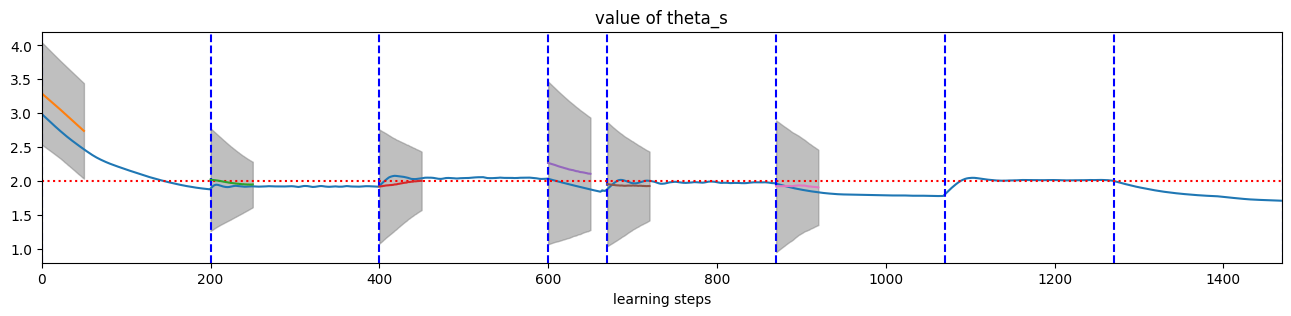

In [2]:
data = np.load("theta_s_trajectory_simple_case_seed_2022.npz")
values = data['arr_0']
count_step_list = data['arr_1']
design_list = data['arr_2']
params_at_stage_end_list = data['arr_3']
del data

plt.figure(figsize=(16, 3))
plt.plot(values)
plt.axvline(x=0, color='b', linestyle='dashed')
x_value_accum=0
for x_value in count_step_list:
    x_value_accum = x_value_accum+x_value
    plt.axvline(x=x_value_accum, color='b', linestyle='dashed')
    
plt.plot([0,x_value_accum],[2,2],color='r',linestyle=':')

plt.xlabel('learning steps')
#plt.ylabel('theta_s')
plt.xlim([0,len(values)])
plt.title('value of theta_s')


def calculate_kld(mu1, var1, mu2, var2):
    sigma1 = np.sqrt(var1)
    sigma2 = np.sqrt(var2)
    kld = np.log(sigma2 / sigma1) + (var1 + (mu1 - mu2) ** 2) / (2 * var2) - 0.5
    return kld
    
def remove_rows_with_zeros(matrix, tol=1e-3):
    # 初始化一个布尔数组，用于标记需要保留的行
    keep_rows = np.ones(len(matrix), dtype=bool)
    
    # 遍历每一行，检查最后三个元素
    for index, row in enumerate(matrix):
        # 检查最后三个元素是否每个都小于等于容差
        if np.all(np.abs(row[-3:]) <= tol):
            keep_rows[index] = False  # 标记不保留这一行
    
    # 使用布尔索引返回需要保留的行
    return matrix[keep_rows]


def summarize_statistics(data):
    """Summarize statistics including mean, median, max, min, standard deviation, coefficient of variation, and quartiles for a numpy array."""
    summary = {
        'Mean': np.mean(data),
        'Median': np.median(data),
        'Max': np.max(data),
        'Min': np.min(data),
        'Standard Deviation': np.std(data),
        'Coefficient of Variation': np.std(data) / np.mean(data) if np.mean(data) != 0 else np.inf,
        '25th Percentile (Q1)': np.percentile(data, 25),
        '75th Percentile (Q3)': np.percentile(data, 75),
        'Interquartile Range (IQR)': np.percentile(data, 75) - np.percentile(data, 25)
    }
    return summary


# 绘图



#for i in range(ensemble_size):
#    length_to_plot = len(ensemble_tractory)
#    plt.plot(ensemble_tractory[i,:])

x_value_accum=0
for stage, x_value in enumerate(count_step_list[0:6]):
    if stage == 0:
        data = np.load("ensemble_trajectory_simple_case_seed_2022_stage0_lr_0p012.npz")
    elif stage == 1:
        data = np.load("ensemble_trajectory_simple_case_seed_2022_stage1_lr_0p012.npz")
    elif stage == 2:
        data = np.load("ensemble_trajectory_simple_case_seed_2022_stage2_lr_0p012.npz")
    elif stage == 3:
        data = np.load("ensemble_trajectory_simple_case_seed_2022_stage3_lr_0p012.npz")
    elif stage == 4:
        data = np.load("ensemble_trajectory_simple_case_seed_2022_stage4_lr_0p012.npz")
    elif stage == 5:
        data = np.load("ensemble_trajectory_simple_case_seed_2022_stage5_lr_0p012.npz")
        

    ensemble_tractory = remove_rows_with_zeros(data['trajectory_0'])
    length_to_plot = ensemble_tractory.shape[1]
    ensemble_mean = np.mean(ensemble_tractory,axis=0)
    ensemble_var = np.var(ensemble_tractory,axis=0)
    ensemble_std = np.std(ensemble_tractory,axis=0)
    plt.plot(np.arange(length_to_plot)+x_value_accum,ensemble_mean)
    #plt.plot(np.arange(length_to_plot)+x_value_accum,ensemble_mean+np.sqrt(ensemble_var)/2)
    #plt.plot(np.arange(length_to_plot)+x_value_accum,ensemble_mean-np.sqrt(ensemble_var)/2)
    plt.fill_between(np.arange(length_to_plot) + x_value_accum, ensemble_mean - ensemble_std , ensemble_mean + ensemble_std , color='gray', alpha=0.5, label='1 std dev')
    x_value_accum = x_value_accum+x_value
    
    mu1 = np.mean(ensemble_tractory[:,0])
    mu2 = np.mean(ensemble_tractory[:,-1])
    var1 = np.var(ensemble_tractory[:,0])
    var2 = np.var(ensemble_tractory[:,-1])
    
    
    print('kld between initial and fina : ', calculate_kld(mu1, var1, mu2, var2))
    print(f'statistic of initial samples at stage {stage} : ')
    print(summarize_statistics(ensemble_tractory[:,0]))
    print(f'statistic of final samples at stage {stage} : ')
    print(summarize_statistics(ensemble_tractory[:,-1]))

#plt.xlim([599,668])
plt.show()

In [8]:
ensemble_tractory[:,0]

array([2.99258614, 2.40891957, 3.13486123, 2.73764062, 4.14842749,
       3.93535233, 3.33753157, 2.54190183, 3.39218092, 2.62035775,
       3.00400567, 2.78763127, 4.45445156, 2.95587635, 2.42720628,
       4.57302809, 4.17433071, 3.13631129, 3.95845413, 3.94810677,
       3.07633471, 2.44926739, 2.6382823 , 3.27516723, 2.9555285 ,
       4.33713245, 4.41600943, 1.55161059, 4.10346889])

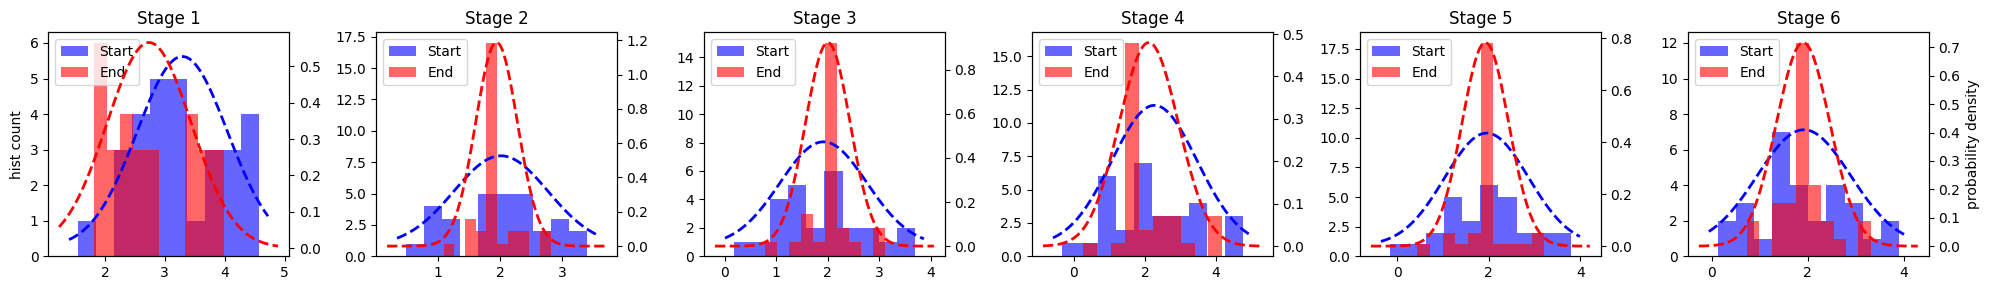

In [35]:
from scipy.stats import norm

fig, axes = plt.subplots(1, 6, figsize=(20, 3)) 

for stage, ax in enumerate(axes.flatten()[:6]):
    if stage == 0:
        data = np.load("ensemble_trajectory_simple_case_seed_2022_stage0_lr_0p012.npz")
    elif stage == 1:
        data = np.load("ensemble_trajectory_simple_case_seed_2022_stage1_lr_0p012.npz")
    elif stage == 2:
        data = np.load("ensemble_trajectory_simple_case_seed_2022_stage2_lr_0p012.npz")
    elif stage == 3:
        data = np.load("ensemble_trajectory_simple_case_seed_2022_stage3_lr_0p012.npz")
    elif stage == 4:
        data = np.load("ensemble_trajectory_simple_case_seed_2022_stage4_lr_0p012.npz")
    elif stage == 5:
        data = np.load("ensemble_trajectory_simple_case_seed_2022_stage5_lr_0p012.npz")
        

    ensemble_trajectory = remove_rows_with_zeros(data['trajectory_0'])
    ax.hist(ensemble_trajectory[:,0], bins=10, color='blue', alpha=0.6, label='Start')
    ax.hist(ensemble_trajectory[:,-1], bins=10, color='red', alpha=0.6, label='End')
    
    ax2 = ax.twinx()

    for col, color in zip([0, -1], ['blue', 'red']):
        mu, std = norm.fit(ensemble_trajectory[:, col])
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        ax2.plot(x, p, color=color, linewidth=2, linestyle='dashed')  # 线型设为虚线以便区分

    ax.set_title(f"Stage {stage+1}")
    ax.legend(loc='upper left')
    #ax2.legend(['Start Fit', 'End Fit'], loc='upper right')
    if stage == 0:
        ax.set_ylabel('hist count')
    elif stage == 5:
        ax2.set_ylabel('probability density')

plt.tight_layout()  # 调整子图布局
plt.show() 

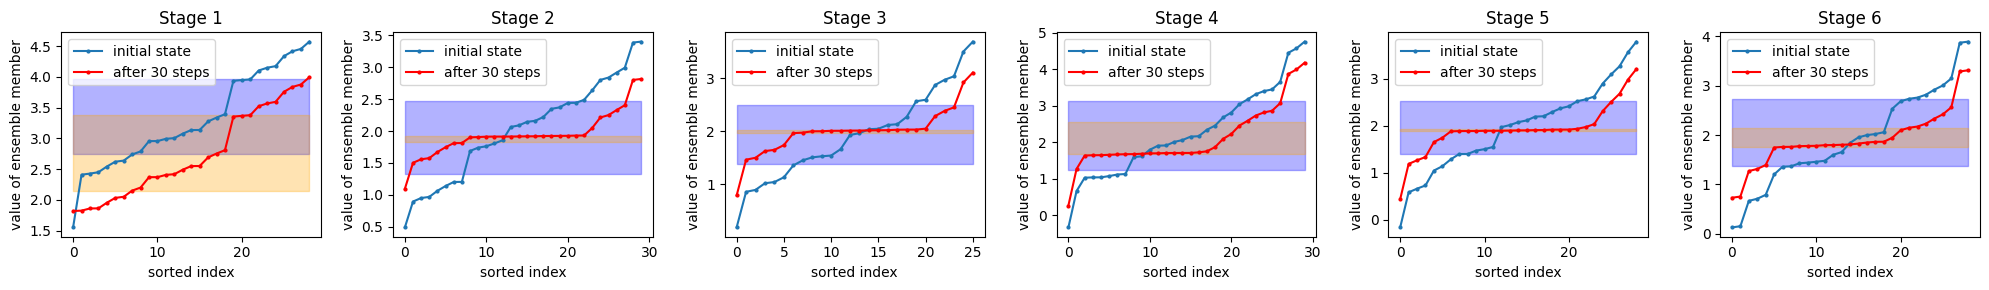

In [37]:
fig, axes = plt.subplots(1, 6, figsize=(20, 3))

for stage, ax in enumerate(axes.flatten()):
    if stage == 0:
        data = np.load("ensemble_trajectory_simple_case_seed_2022_stage0_lr_0p012.npz")
    elif stage == 1:
        data = np.load("ensemble_trajectory_simple_case_seed_2022_stage1_lr_0p012.npz")
    elif stage == 2:
        data = np.load("ensemble_trajectory_simple_case_seed_2022_stage2_lr_0p012.npz")
    elif stage == 3:
        data = np.load("ensemble_trajectory_simple_case_seed_2022_stage3_lr_0p012.npz")
    elif stage == 4:
        data = np.load("ensemble_trajectory_simple_case_seed_2022_stage4_lr_0p012.npz")
    elif stage == 5:
        data = np.load("ensemble_trajectory_simple_case_seed_2022_stage5_lr_0p012.npz")
        
    ensemble_trajectory = remove_rows_with_zeros(data['trajectory_0'])
    
    sorted_data = np.sort(ensemble_trajectory[:,0])  # 排序数据
    ax.plot(sorted_data, marker='o', linestyle='-', markersize=2, label = 'initial state')
    
    # 计算四分位数并绘制虚线
    q1 = np.percentile(sorted_data, 25)
    q3 = np.percentile(sorted_data, 75)
    ax.fill_between(range(len(ensemble_trajectory)), q1, q3, 
                    color='blue', alpha=0.3, interpolate=True)
    
    
    sorted_data = np.sort(ensemble_trajectory[:,-1])  # 排序数据
    ax.plot(sorted_data, marker='o', color='r', linestyle='-', markersize=2,label='after 30 steps')
    
    # 计算四分位数并绘制虚线
    q1 = np.percentile(sorted_data, 25)
    q3 = np.percentile(sorted_data, 75)
    ax.fill_between(range(len(ensemble_trajectory)), q1, q3, 
                    color='orange', alpha=0.3, interpolate=True)
    
    ax.set_title(f"Stage {stage+1}")
    ax.set_xlabel('sorted index')
    ax.set_ylabel('value of ensemble member')
    ax.legend()

plt.tight_layout()
plt.show()


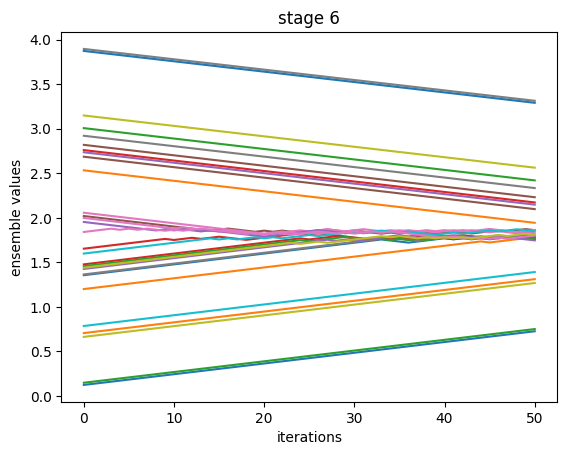

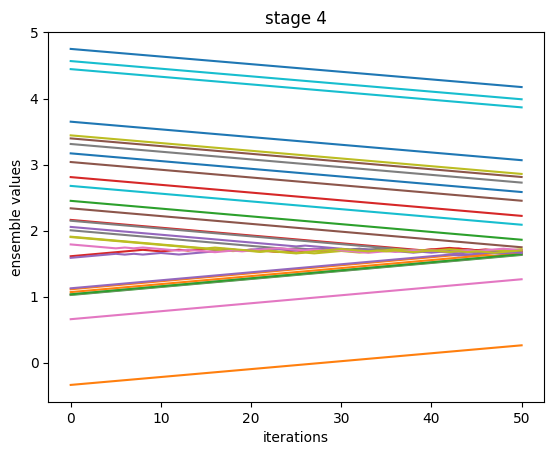

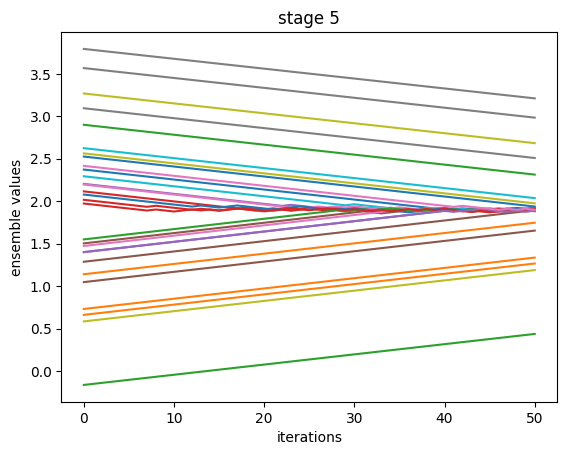

In [12]:
data = np.load("ensemble_trajectory_simple_case_seed_2022_stage5_lr_0p012.npz")
ensemble_tractory = remove_rows_with_zeros(data['trajectory_0'])

for i in range(ensemble_tractory.shape[0]):
    plt.plot(ensemble_tractory[i,:])
plt.xlabel('iterations')
plt.ylabel('ensemble values')
plt.title('stage 6')
plt.show()

data = np.load("ensemble_trajectory_simple_case_seed_2022_stage3_lr_0p012.npz")
ensemble_tractory = remove_rows_with_zeros(data['trajectory_0'])

for i in range(ensemble_tractory.shape[0]):
    plt.plot(ensemble_tractory[i,:])
plt.xlabel('iterations')
plt.ylabel('ensemble values')
plt.title('stage 4')
plt.show()

data = np.load("ensemble_trajectory_simple_case_seed_2022_stage4_lr_0p012.npz")
ensemble_tractory = remove_rows_with_zeros(data['trajectory_0'])

for i in range(ensemble_tractory.shape[0]):
    plt.plot(ensemble_tractory[i,:])
plt.xlabel('iterations')
plt.ylabel('ensemble values')
plt.title('stage 5')
plt.show()

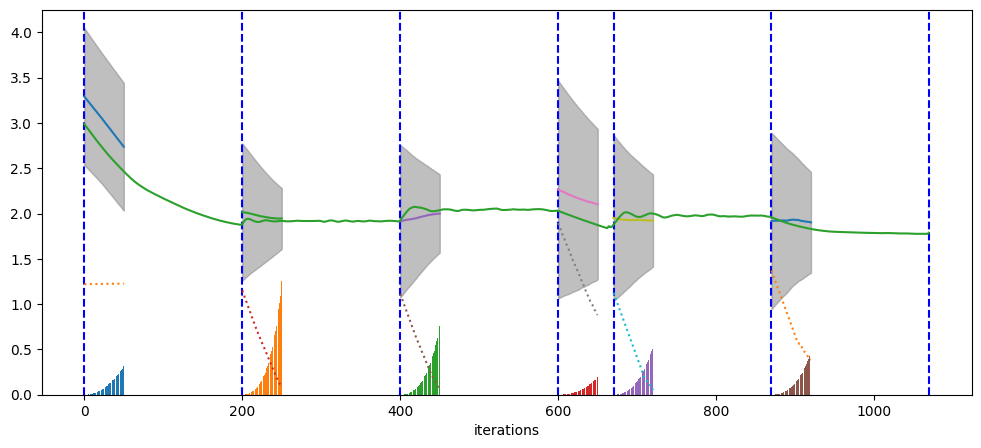

In [27]:
plt.figure(figsize=(12,5))


x_value_accum=0
plt.axvline(x=x_value_accum, color='b', linestyle='dashed')
for stage, x_value in enumerate(count_step_list[0:6]):
    if stage == 0:
        data = np.load("ensemble_trajectory_simple_case_seed_2022_stage0_lr_0p012.npz")
    elif stage == 1:
        data = np.load("ensemble_trajectory_simple_case_seed_2022_stage1_lr_0p012.npz")
    elif stage == 2:
        data = np.load("ensemble_trajectory_simple_case_seed_2022_stage2_lr_0p012.npz")
    elif stage == 3:
        data = np.load("ensemble_trajectory_simple_case_seed_2022_stage3_lr_0p012.npz")
    elif stage == 4:
        data = np.load("ensemble_trajectory_simple_case_seed_2022_stage4_lr_0p012.npz")
    elif stage == 5:
        data = np.load("ensemble_trajectory_simple_case_seed_2022_stage5_lr_0p012.npz")

    ensemble_tractory = remove_rows_with_zeros(data['trajectory_0'])
    length_to_plot = ensemble_tractory.shape[1]
    ensemble_mean = np.mean(ensemble_tractory,axis=0)
    ensemble_var = np.var(ensemble_tractory,axis=0)
    ensemble_std = np.std(ensemble_tractory,axis=0)
    plt.plot(np.arange(length_to_plot)+x_value_accum,ensemble_mean)
    #plt.plot(np.arange(length_to_plot)+x_value_accum,ensemble_mean+np.sqrt(ensemble_var)/2)
    #plt.plot(np.arange(length_to_plot)+x_value_accum,ensemble_mean-np.sqrt(ensemble_var)/2)
    plt.fill_between(np.arange(length_to_plot) + x_value_accum, ensemble_mean - ensemble_std , ensemble_mean + ensemble_std , color='gray', alpha=0.5, label='1 std dev')

    kld_trajectory = []
    iqr_trajectory = []
    mu1 = np.mean(ensemble_tractory[:,0])
    var1 = np.var(ensemble_tractory[:,0])
    for j in range(length_to_plot):
        mu2 = np.mean(ensemble_tractory[:,j])
        var2 = np.var(ensemble_tractory[:,j])
        kld_trajectory.append(calculate_kld(mu1, var1, mu2, var2))
        iqr_trajectory.append(summarize_statistics(ensemble_tractory[:,j])['Interquartile Range (IQR)'])
        
    plt.bar(np.arange(length_to_plot)+ x_value_accum,kld_trajectory)
    plt.plot(np.arange(length_to_plot)+ x_value_accum, iqr_trajectory,linestyle=':')
    x_value_accum = x_value_accum+x_value
    plt.axvline(x=x_value_accum, color='b', linestyle='dashed')


plt.plot(values[0:x_value_accum])
plt.xlabel('iterations')
plt.show()

In [11]:
design_list

array([[0.5       , 0.5       ],
       [0.4440282 , 0.3       ],
       [0.46126467, 0.2237932 ],
       [0.41602552, 0.28675115],
       [0.3875192 , 0.17286941],
       [0.42133167, 0.30463505],
       [0.31953496, 0.22170521],
       [0.42341912, 0.316074  ],
       [0.43725258, 0.17330147]], dtype=float32)

In [ ]:
measure on design point [0.5 0.5] is 0.5263859033584595
measure on design point [0.4440282 0.3      ] is 0.65467768907547
measure on design point [0.46126467 0.2237932 ] is 0.6416658163070679
measure on design point [0.41602552 0.28675115] is 0.40165385603904724
measure on design point [0.3875192  0.17286941] is 0.5718757510185242
measure on design point [0.42133167 0.30463505] is 0.21618816256523132
measure on design point [0.31953496 0.22170521] is 0.4468940794467926
measure on design point [0.42341912 0.316074  ] is 0.2671109437942505

In [ ]:
current_params=3

ensemble_size = 30
ensemble_step = 10
initial_var = 1
key_ensemble = random.split(key[stage],ensemble_size*ensemble_step+1)
ensemble_member = current_params + random.normal(key_ensemble[0], (1,ensemble_size))*jnp.sqrt(initial_var)
ensemble_updated_list = []
ensemble_key_count = 1
ensemble_tractory = np.zeros((ensemble_size, ensemble_step+1))
ensemble_optimizer = optax.adam(learning_rate=learning_rate2[stage])
tx2 = optax.chain(
        optax.adam(learning_rate=0.1),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
        optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
)

for i in range(ensemble_size):
    ensemble_current_params = ensemble_member[0][i]
    print('|',end='')
    ensemble_tractory[i,0]=ensemble_current_params
    
    for j in range(ensemble_step):
        opt_state2 = tx2.init(ensemble_current_params)
        
        loss_return, grad_params = jax.value_and_grad(loss_params_average_refine,has_aux=True)(ensemble_current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_ensemble[ensemble_key_count], theta_true, num_top, observation)
        updates, opt_state2 = tx2.update(grad_params, opt_state2, params=ensemble_current_params)
        
        updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
        if updates_contain_nans:
            break
        else:
            ensemble_current_params = optax.apply_updates(ensemble_current_params, updates)
            ensemble_tractory[i,j+1]=ensemble_current_params
            print('.',end='')
        
        ensemble_key_count += 1 # for key updating

In [9]:
# 使用字典推导式为每个数组创建一个键
#np.savez("ensemble_trajectory_simple_case_seed_2022_lr_0p012.npz", **{f"trajectory_{i}": arr for i, arr in enumerate(ensemble_trajectory_list)})
np.savez("ensemble_trajectory_simple_case_seed_812_lr_0p012.npz", **{f"trajectory_{i}": arr for i, arr in enumerate(ensemble_trajectory_list)})

In [12]:
#data = np.load("ensemble_trajectory_simple_case_seed_2022_lr_0p1.npz")
#data = np.load("ensemble_trajectory_simple_case_seed_2022_lr_0p012.npz")
#data = np.load("ensemble_trajectory_simple_case_seed_812_lr_0p012.npz")

# 由于保存时使用了无名参数，加载后的数据将用'arr_0', 'arr_1'等键来访问
loaded_list = [data[f"trajectory_{i}"] for i in range(n_stage)]

ensemble_size = 30
ensemble_step = 10

In [26]:
ensemble_tractory.shape

(30, 11)

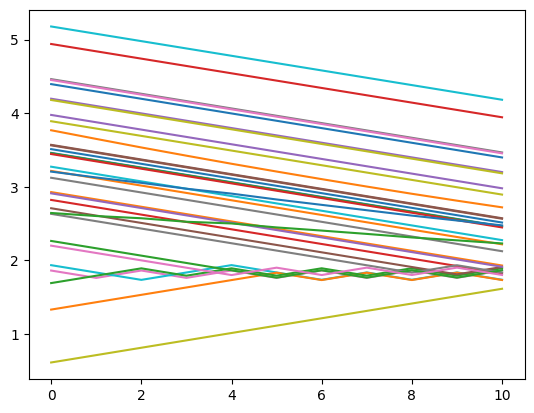

In [28]:
# 绘图

ensemble_tractory = loaded_list[0]

for i in range(ensemble_size):
    plt.plot(ensemble_tractory[i,:])

ensemble_mean = np.mean(ensemble_tractory,axis=0)
ensemble_var = np.var(ensemble_tractory,axis=0)
plt.plot(ensemble_mean)
plt.plot(ensemble_mean+ensemble_var/2)
plt.plot(ensemble_mean-ensemble_var/2)

posterior mess at center =  0.004763319 , mean of posterior =  0.00038446757 , max of posterior mess =  0.018347237  at ( 0.52 0.29999998 )
posterior mess at center =  0.021877276 , mean of posterior =  0.0003844675 , max of posterior mess =  0.1026208  at ( 0.45999998 0.22 )
posterior mess at center =  0.043413334 , mean of posterior =  0.0003844675 , max of posterior mess =  0.19363631  at ( 0.44 0.22 )
posterior mess at center =  0.07228356 , mean of posterior =  0.0003844675 , max of posterior mess =  0.2756957  at ( 0.44 0.22 )
posterior mess at center =  0.075581 , mean of posterior =  0.0003844675 , max of posterior mess =  0.28782442  at ( 0.44 0.22 )
posterior mess at center =  0.09917691 , mean of posterior =  0.0003844675 , max of posterior mess =  0.30600327  at ( 0.44 0.22 )
posterior mess at center =  0.14048652 , mean of posterior =  0.00038446745 , max of posterior mess =  0.41376585  at ( 0.44 0.24 )
posterior mess at center =  0.15331273 , mean of posterior =  0.00038

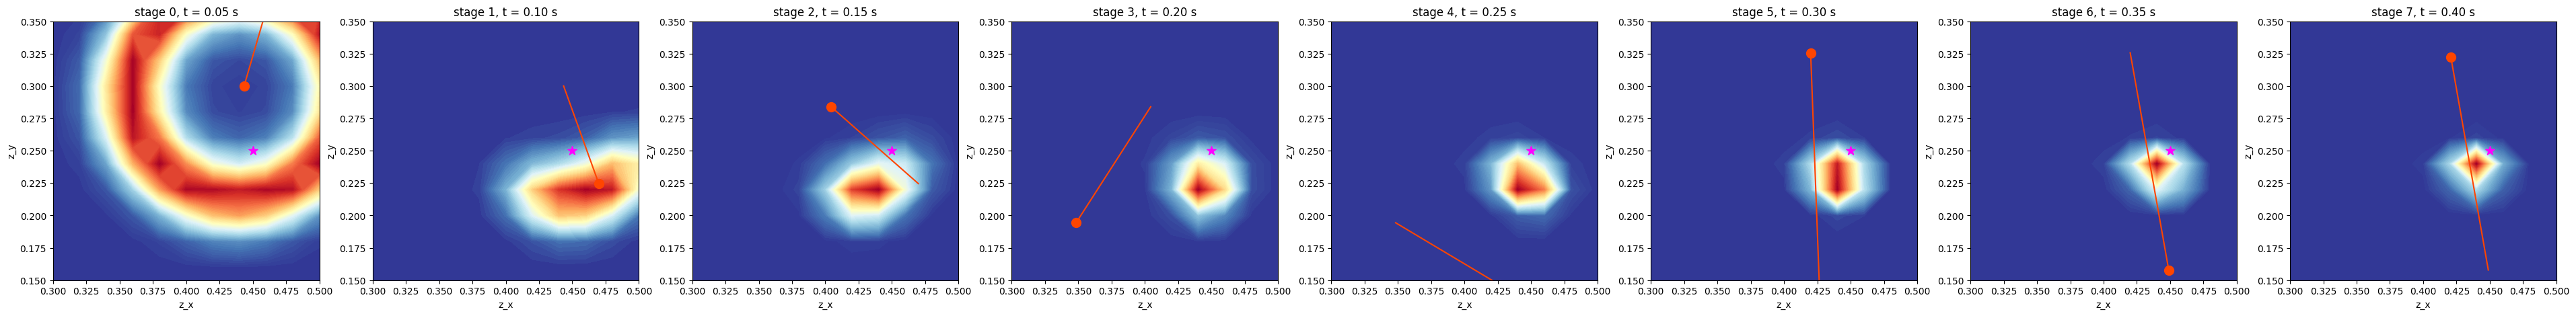

In [9]:
fig, axes = plt.subplots(1, n_stage, figsize=(6*n_stage, 5))
for stage in range(n_stage):
    if counted_stage_list[stage] == 1:
        axes[stage].contourf(grid_x_plot0, grid_y_plot0, posterior_list[stage].T, levels=100,cmap='RdYlBu_r' )
    axes[stage].scatter(design_list[stage+1][0], design_list[stage+1][1], marker='o', s=100, c='orangered')
    axes[stage].scatter(center[0], center[1], marker='*', s=100, c='magenta')
    axes[stage].plot([design_list[stage+1][0],design_list[stage][0]],
                    [design_list[stage+1][1],design_list[stage][1]], c='orangered')
    axes[stage].set_title(f'stage {stage}, t = {((stage+1)*0.05):.2f} s')  # 设置子图的标题
    axes[stage].set_xlim([0.3,0.5])  # 设置x轴标签
    axes[stage].set_ylim([0.15,0.35])  # 设置x轴标签
    axes[stage].set_xlabel('z_x')  # 设置x轴标签
    axes[stage].set_ylabel('z_y')  # 设置y轴标签

    max_index = jnp.argmax(posterior_list[stage])
    max_row, max_col = jnp.unravel_index(max_index, posterior_list[stage].shape)
    
    print('posterior mess at center = ', jax.scipy.ndimage.map_coordinates(posterior_list[stage],[center[0]*50,center[1]*50],1), ', mean of posterior = ', jnp.mean(posterior_list[stage]), ', max of posterior mess = ', jnp.max(posterior_list[stage]), ' at (', max_row/50, max_col/50, ')')
    

In [ ]:
# 用于某一个stage 继续往后算多步。跳过了design环节
stage = 6
print('stage = ', stage)
current_params = jnp.array([1.7784164])
#current_params = params_at_stage_end_list[stage-1]
print('current_params = ', current_params)
prior = posterior_list[stage-1]
d_start = jnp.array([0.4209376,0.3064373])

# 首先手动完成oed的更新后验过程

_, posterior = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], theta_true)
del prior
prior = posterior

lr_schedule2 = create_decay_schedule(learning_rate2[stage], 10, 0.98)
tx2 = optax.chain(
        optax.adam(lr_schedule2),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
        #optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
    )
opt_state2 = tx2.init(current_params)

output_point, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
observation = output_point

print('observation = ', observation)
num_top = 15
noise_level = 0.3

test_params_list = []
test_params_grad_list = []
test_percentage_list = []
test_loglikelihood_list = []
test_params_list.append(current_params)

# 重新指定一个步数
iteration_new = 500
key_for_param = random.split(key[stage*2+1],iteration_new)

for i in range(iteration_new):
    loglikelihood = calculate_loglikelihood_refine(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_for_param[i], theta_true, observation)
    test_loglikelihood_list.append(loglikelihood)
    
    log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
    indices = jnp.argpartition(log_evidence_list.ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)
    
    average_x = np.mean(multi_indices[0])
    average_y = np.mean(multi_indices[1])
    
    
    key_local = random.split(key_for_param[0],2)
    
    
    average_x_purterbed = average_x+jax.random.normal(key_local[0], average_x.shape)*noise_level
    average_y_purterbed = average_y+jax.random.normal(key_local[1], average_y.shape)*noise_level
    
    selected_loglikelihoods = jax.scipy.ndimage.map_coordinates(loglikelihood,[average_x_purterbed,average_y_purterbed],1)
    
#    print('max of loglikelihood = ', jnp.max(loglikelihood), ', mean of loglikelihood = ', jnp.mean(loglikelihood), ', loss (selected_loglikelihoods) = ', selected_loglikelihoods, '. percent = ', selected_loglikelihoods/jnp.max(loglikelihood))
#    print([average_x, average_y, average_x_purterbed, average_y_purterbed])


    loss_return, grad_params = jax.value_and_grad(loss_params_average_refine,has_aux=True)(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_for_param[i], theta_true, num_top, observation)
#    print('grad_params = ', grad_params)
    updates, opt_state2 = tx2.update(grad_params, opt_state2, params=current_params)

    updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
    if updates_contain_nans:
        noise = 0.01*jax.random.normal(key_for_param[i], current_params.shape)
        print('NaN appears in learning. Perturb params and continue. The previos design is ',current_params,'. noise is ', noise)
        current_params = current_params+ noise
        average_theta_xy_list.append(['nan'])
    else:
        current_params = optax.apply_updates(current_params, updates)
        print('.',end='')
        average_theta_xy_list.append(loss_return[1])


    test_params_list.append(current_params)
    test_params_grad_list.append(grad_params)
    test_percentage_list.append(selected_loglikelihoods/jnp.max(loglikelihood))

plt.figure(figsize=(16, 4))
plt.plot(test_percentage_list)
plt.figure(figsize=(16, 4))
plt.plot(test_params_grad_list)
plt.figure(figsize=(16, 4))
plt.plot(test_params_list)

In [ ]:
opt_state2

In [ ]:
# 用于继续计算后面的stage
key = random.split(key1,30)

for stage in [9,10]:
    print('\n stage = ', stage, '\n')
    key_for_design = random.split(key[stage*2],iteration_step_number1[stage])
    key_for_param = random.split(key[stage*2+1],iteration_step_number2[stage])
    
    clip_count = 0
    
    if stage!=0:
        del tx1
        
    #tx1 = optax.adam(lr_schedule1)
    tx1 = optax.chain(
    optax.adam(lr_schedule1),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
    optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
    )
    
    opt_state1 = tx1.init(d_start)
    
    d_limit_min = d_start - d_change_range
    d_limit_max = d_start + d_change_range
    
    start_time = time.time()
    d_start_backup = d_start

    print('start learning design')
    print(f'start design : ', d_start)
    for i in range(iteration_step_number1[stage]):
        negtive_KLD, grad_design = jax.value_and_grad(loss_design)(d_start, current_params, stage, center, prior, noise_info, num_d, radio_d, key_for_design[i], theta_true)
        updates, opt_state1 = tx1.update(grad_design, opt_state1, params=d_start)

        
        # 解决nan的问题
        updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
        if updates_contain_nans:
            print('NaN appears in learning. Perturb designs and continue')
            noise = 0.01*jax.random.normal(key_for_design[i], d_start.shape)
            d_start = d_start+ noise
        else:
            d_start = optax.apply_updates(d_start, updates)
    
        d_start_before_clip = d_start
        d_start = jnp.clip(d_start, d_limit_min, d_limit_max)
        
        # 如果clip函数生效，即有参数被裁剪，增加计数器
        if not jnp.all(d_start == d_start_before_clip):
            clip_count += 1
            
        if clip_count >= 5:
            print(f"Stopping iteration at step {i} as clip function has been activated 5 times.")
            break
        
        if np.isnan(d_start).any() or np.isnan(negtive_KLD).any():
            print('some results are Nan')
            break
    
        KLD_list.append(-negtive_KLD)
        
        #if len(KLD_list) >= 5:
        #    last_five = KLD_list[-5:]
        #    if all(abs(last_five[0] - k) < 0.01*last_five[0] for k in last_five[1:]):
        #        print("连续5步的negtive_KLD几乎相同，停止循环")
        #        break  # 跳出循环
            
    end_time = time.time()
    print(f"Execution learning design time: {end_time - start_time} seconds")
    print(f"Current design: {d_start}")

    # ====== 如果下面是从0阶段就开始做model correction，那么这里需要从0阶段开始执行。如果下面跳过某些阶段，那么这里就跳过某些阶段。因为这里会和下面的更新后验的步骤重叠。
    if stage not in stage_to_skip:
        _, posterior = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], theta_true)
        del prior
        prior = posterior


    # 设置优化器
    if stage!=0:
        del tx2
        #del cosine_schedule2
        #cosine_schedule2 = optax.cosine_decay_schedule(init_value=learning_rate2[stage], decay_steps=25, alpha=learning_rate2_min)
        del lr_schedule2
    lr_schedule2 = create_decay_schedule(learning_rate2[stage], 10, 0.98)
    #lr_schedule2 = create_decay_schedule(learning_rate2[stage], 5, 0.98)
    tx2 = optax.chain(
        optax.adam(lr_schedule2),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
        optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
    )
    
    #tx2 = optax.chain(
    #    optax.scale_by_adam(),  # 使用 Adam 算法
    #    optax.scale_by_schedule(cosine_schedule2),  # 应用余弦退火学习率调度
    #    optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-4
    #)

    opt_state2 = tx2.init(current_params)


    
    # model correction    
    start_time = time.time()
    print('start optimazing design for model correction')
    num_top = int(num_array[stage])

    ## 新的办法：只在开头进行一次测量，后面不测量了。节约一半的时间
    
    noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]
    output_point, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
    #noise = random.normal(key,(1,1))*(noise_base_scale+output_point*noise_ratio_scale) #形状(1,1)
    #observation = output_point + noise*0.1
    observation = output_point
    
    #if observation < 0.4:
    #    noise_info_local = noise_info2
    #else:
    #    noise_info_local = noise_info

    nan_account = 0
    for i in range(iteration_step_number2[stage]):
        if stage in stage_to_skip:
            print('this stage  dont learn error parameters')
            break

        ### 新的办法：只在开头进行一次测量，后面不测量了。节约一半的时间
        #if i%5 == 0:
        #    noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]
        #    output_point, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
        #    noise = random.normal(key_for_param[i],(1,1))*(noise_base_scale+output_point*noise_ratio_scale) #形状(1,1)
        #    observation = output_point + noise*0.01
        
        ## 新的办法
        loss_return, grad_params = jax.value_and_grad(loss_params_average_refine_minibatch,has_aux=True)(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_for_param[i], theta_true, num_top, observation)
        
        ## 旧的代码
        #loss, grad_params = jax.value_and_grad(loss_params_average)(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_for_param[i], theta_true, num_top)

        
        updates, opt_state2 = tx2.update(grad_params, opt_state2, params=current_params)

        updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
        if updates_contain_nans:
            noise = 0.01*jax.random.normal(key_for_param[i], current_params.shape)
            print('NaN appears in learning. Perturb params and continue. The previos design is ',current_params,'. noise is ', noise)
            current_params = current_params+ noise
            average_theta_xy_list.append(['nan'])
            nan_account += 1
        else:
            current_params = optax.apply_updates(current_params, updates)
            print('.',end='')
            average_theta_xy_list.append(loss_return[1])

        
            ## 使用模拟退火的接受准则
            #new_params = optax.apply_updates(current_params, updates)
            #
            ### 显式扰动theta_s
            ##updated_params = optax.apply_updates(current_params, updates)
            ##new_params = updated_params + step_size * random.normal(key_for_param[i], updated_params.shape)
            #key_local, _ = random.split(key_for_param[i])
            #new_loss = loss_params_average_refine(new_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_local, theta_true, num_top, observation)
            ## 计算损失变化
            #delta_E = new_loss - loss
            #
            ## 使用 Metropolis 准则决定是否接受新解
            #if delta_E < 0:
            #    current_params = new_params
            #    loss = new_loss
            #    print('.',end='')
            #elif jnp.exp(-delta_E / T0) > random.uniform(key_for_param[i]):
            #    current_params = new_params
            #    loss = new_loss
            #    print('-',end='')
            #else:
            #    #print('current_params did not change')
            #    print('^',end='')
                
        if nan_account > 6:
            print('break this stage as nan shows up more than 6 times')
            break

        if np.isnan(current_params).any():
            print('some results are Nan')
            break
            
        # annealing
        
        #net_accuracy = evaluate_nn_accuracy(params,model,center,local_size)
        #print(f'Loss step {i} max evidence items: {max_evidence_items}, nn error {i}: {net_accuracy}')
            
        NN_error_list.append(loss_return[0])
        params_list.append(current_params)
        #grad_list.append(grad_params)
        params_detail_list.append(grad_params)
            
        
        #if len(NN_error_list) >= 5:
        #    last_five = NN_error_list[-5:]
        #    if all(abs(last_five[0] - k) < 0.005*last_five[0] for k in last_five[1:]):
        #        print("连续5步的 NN error 几乎相同，停止循环")
        #        break  # 跳出循环

    print('\n')
    print('design for model correction : ', d_start)
    end_time = time.time()
    print(f"Execution learning param time: {end_time - start_time} seconds")
    print(f"current theta_s: {current_params}")
    params_at_stage_end_list.append(current_params)

    # 更新后验
    _, posterior = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], theta_true)
    if stage!=0:
         del prior
    prior = posterior
    design_list.append(d_start)
    posterior_list.append(posterior)

In [12]:
center = jnp.array([0.45,0.25])
theta_true = jnp.array([2.0])

# 检查了几个阶段的model correction的测量值。发现这个越来越小。
for stage in range(n_stage):
    output_point, _ = sealed_convection_diffusion_exp_parametic(design_list[stage+1], center, stage, theta_true)
    print(f'measure on design point {design_list[stage]} is {output_point}')

# 因为第四个阶段的测量值得到的数太小了

measure on design point [0.5 0.5] is 0.5263859033584595
measure on design point [0.4440282 0.3      ] is 0.65467768907547
measure on design point [0.46126467 0.2237932 ] is 0.6416658163070679
measure on design point [0.41602552 0.28675115] is 0.40165385603904724
measure on design point [0.3875192  0.17286941] is 0.5718757510185242
measure on design point [0.42133167 0.30463505] is 0.21618816256523132
measure on design point [0.31953496 0.22170521] is 0.4468940794467926
measure on design point [0.42341912 0.316074  ] is 0.2671109437942505


In [30]:
output_point, _ = sealed_convection_diffusion_exp_parametic(design_list[3], center, 1, theta_true)
output_point

Array(0.6140377, dtype=float32)

In [31]:
# we still have poseterior_list
# so we cam know the output in the model correction to see if this is because of the error scale

for stage in range(n_stage):
    _, output_all = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
    print(f'max value at stage {stage} is {jnp.max(output_all)} while the mean value is {jnp.mean(output_all)}')

# 在最后一个stage，这个场几乎接近于平均了。感觉是应该减小风速试试

max value at stage 0 is 0.5896304845809937 while the mean value is 0.004039999563246965
max value at stage 1 is 0.6890552639961243 while the mean value is 0.00803999975323677
max value at stage 2 is 0.7212824821472168 while the mean value is 0.012039999477565289
max value at stage 3 is 0.7072358727455139 while the mean value is 0.016039999201893806
max value at stage 4 is 0.6609936952590942 while the mean value is 0.0200399998575449
max value at stage 5 is 0.6045292615890503 while the mean value is 0.024039998650550842
max value at stage 6 is 0.5489238500595093 while the mean value is 0.028039997443556786
max value at stage 7 is 0.5025457143783569 while the mean value is 0.03203999623656273


In [ ]:
len(count_step_list)

Text(0.5, 1.0, 'loss')

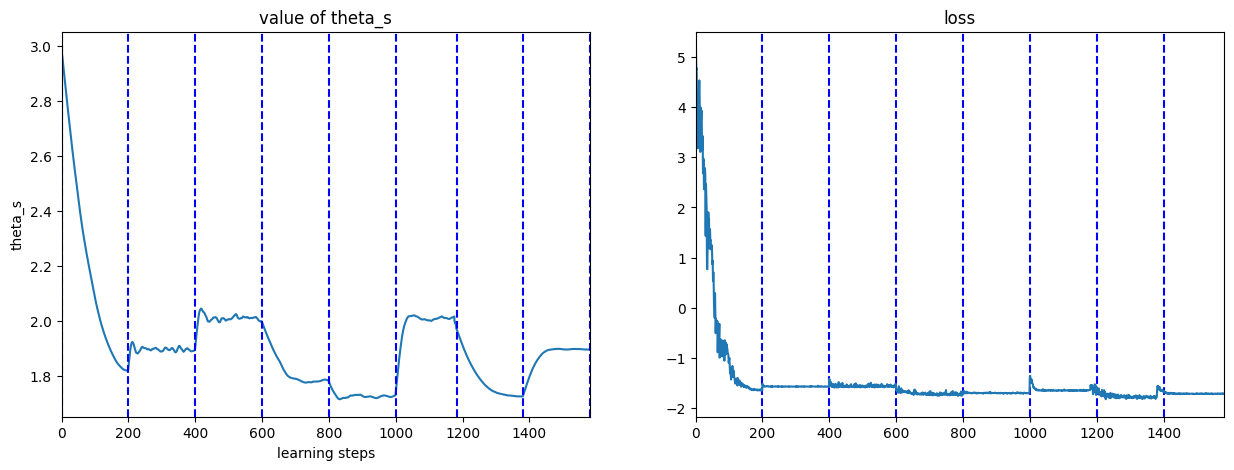

In [10]:
# 检验correction 结果

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

ax = axs[0]
values = [item[0][0] for item in params_list]
ax.plot(values)
ax.axvline(x=0, color='b', linestyle='dashed')
x_value_accum=0
for x_value in count_step_list:
    x_value_accum = x_value_accum+x_value
    ax.axvline(x=x_value_accum, color='b', linestyle='dashed')

ax.set_xlabel('learning steps')
ax.set_ylabel('theta_s')
ax.set_xlim([0,len(values)])
ax.set_title('value of theta_s')

ax = axs[1]
x_value_accum=0
for x_value in iteration_step_number2[0:-1]:
    x_value_accum = x_value_accum+x_value
    ax.axvline(x=x_value_accum, color='b', linestyle='dashed')

ax.plot(NN_error_list)
ax.set_xlim([0,len(values)])
ax.set_title('loss')



In [ ]:
print(np.max(values[1500:1600])-np.min(values[1500:1600]))
print(np.max(values[1300:1400])-np.min(values[1300:1400]))
print(np.max(values[1100:1200])-np.min(values[1100:1200]))
print(np.max(values[900:1000])-np.min(values[900:1000]))
print(np.max(values[700:800])-np.min(values[700:800]))

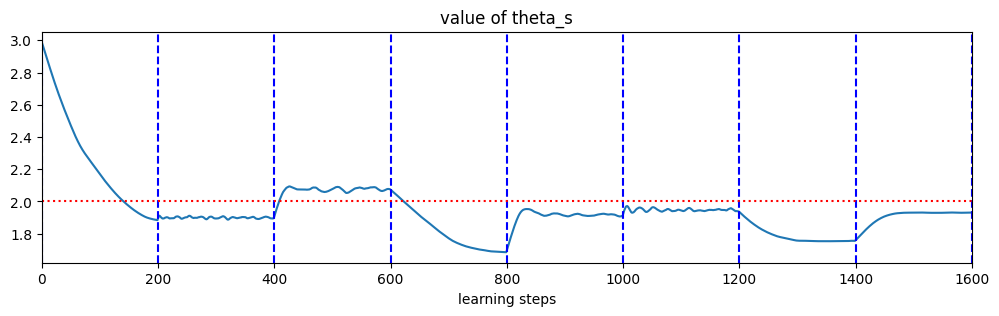

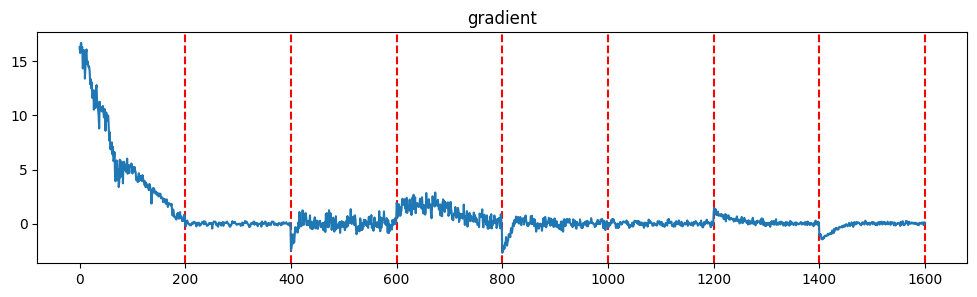

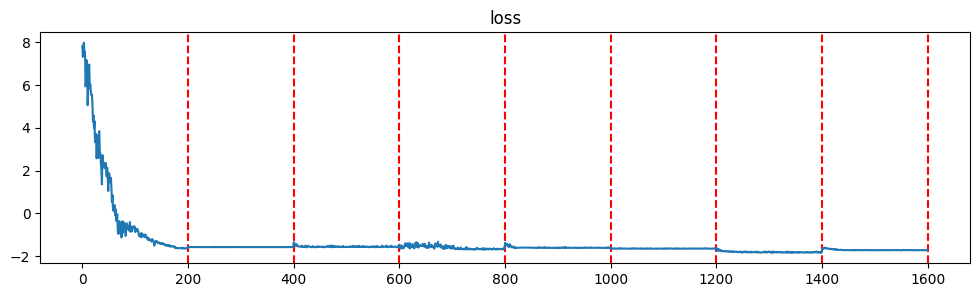

In [7]:
#average_theta_xy_list
#plt.plot(params_detail_list)


plt.figure(figsize=(12, 3))
values = [item[0][0] for item in params_list]
plt.plot(values)
plt.axvline(x=0, color='b', linestyle='dashed')
x_value_accum=0
for x_value in count_step_list:
    x_value_accum = x_value_accum+x_value
    plt.axvline(x=x_value_accum, color='b', linestyle='dashed')
    
plt.plot([0,x_value_accum],[2,2],color='r',linestyle=':')

plt.xlabel('learning steps')
#plt.ylabel('theta_s')
plt.xlim([0,len(values)])
plt.title('value of theta_s')
plt.show()


combined_array = np.concatenate(params_detail_list)

plt.figure(figsize=(12, 3))
x_value_accum=0
for x_value in count_step_list:
    x_value_accum = x_value_accum+x_value
    plt.axvline(x=x_value_accum, color='r', linestyle='dashed')
plt.plot(combined_array)
plt.title('gradient')
plt.show()


plt.figure(figsize=(12, 3))
x_value_accum=0
for x_value in count_step_list:
    x_value_accum = x_value_accum+x_value
    plt.axvline(x=x_value_accum, color='r', linestyle='dashed')
plt.plot(NN_error_list)
plt.title('loss')
plt.show()


In [10]:
design_list

[Array([0.5, 0.5], dtype=float32),
 Array([0.44615543, 0.3       ], dtype=float32),
 Array([0.46478364, 0.22185667], dtype=float32),
 Array([0.4142818 , 0.29978114], dtype=float32),
 Array([0.3919749 , 0.17226636], dtype=float32),
 Array([0.41805908, 0.3145661 ], dtype=float32),
 Array([0.44018278, 0.32191935], dtype=float32),
 Array([0.3603241 , 0.22477573], dtype=float32),
 Array([0.4369285 , 0.32754728], dtype=float32)]

In [8]:
np.savez("theta_s_trajectory_simple_case_seed_2022.npz", values, count_step_list, design_list, params_at_stage_end_list) # 比较好的数据

In [8]:
np.savez("theta_s_trajectory_simple_case_seed_812.npz", values, count_step_list, design_list, params_at_stage_end_list) # 一般的数据

In [8]:
data = np.load("theta_s_trajectory_simple_case_seed_2022.npz")

# 读取数组
values = data['arr_0']
count_step_list = data['arr_1']
design_list = data['arr_2']
params_at_stage_end_list = data['arr_3']

# 使用这些数组进行操作
print("Values:", values)
print("Count Step List:", count_step_list)

Values: [2.9882996 2.9765828 2.9648545 ... 1.707542  1.7070955 1.7066988]
Count Step List: [200 200 200  70 200 200 200 200]


In [7]:

size = 251  #只需要在 my_equation 里面改尺寸就可以了
local_size = int((size-1)/5+1)
density = 1.
viscosity = 1

lo_b = -2. #也需要在 my_equation 里面改范围
up_b = 3.

max_velocity = 2.0
cfl_safety_factor = 0.5


#key = random.PRNGKey(0)  # 随机数生成器的键
#x_for_shape = random.normal(key, (1, 2))  # 假设输入数据形状为 (batch_size, input_features)，这里是一个样本，两个特征
#model = my_forcing.FullyConnectedNN()  # 创建模型实例
#params = model.init(key, x_for_shape)




# OED settings =================
n_stage = 8
d_start = jnp.array([0.5,0.5])
center = jnp.array([0.45,0.25])

d_change_range = jnp.array([0.2,0.2])

noise_loc = 0
noise_base_scale = 0.05
noise_ratio_scale = 0.05
noise_info = [(noise_loc, noise_base_scale, noise_ratio_scale),]
num_top = 15

num_d = 1.0
radio_d = 0.5

xb_size = int((size - 1)/5+1) #初始化均匀先验
prior_ori = jnp.ones((xb_size,xb_size))
prior = prior_ori/jnp.sum(prior_ori)

for stage in range(n_stage):
    current_params = params_at_stage_end_list[stage]
    d_start = design_list[stage+1]
    output_point, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
    observation = output_point
    print('observation = ', observation)


    # 定义一个ensemble
    ensemble_size = 30
    ensemble_step = 10
    initial_var = 1
    key_ensemble = random.split(key[stage],ensemble_size*ensemble_step+1)
    ensemble_member = current_params + random.normal(key_ensemble[0], (1,ensemble_size))*jnp.sqrt(initial_var)
    ensemble_key_count = 1
    ensemble_trajectory = np.zeros((ensemble_size, ensemble_step+1))
    ensemble_optimizer = optax.chain(
                            optax.adam(learning_rate=0.012),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
                            optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
    )
    
    # 对于每一个元素执行一次更新
    for i in range(ensemble_size):
        ensemble_current_params = ensemble_member[0][i]
        print('|',end='')
        ensemble_trajectory[i,0]=ensemble_current_params
        
        for j in range(ensemble_step):
            ensemble_opt_state = ensemble_optimizer.init(ensemble_current_params)
            
            _, grad_params = jax.value_and_grad(loss_params_average_refine,has_aux=True)(ensemble_current_params, d_start, stage, center, loaded_list[stage], noise_info, num_d, radio_d, key_ensemble[ensemble_key_count], theta_true, num_top, observation)
            updates, ensemble_opt_state = ensemble_optimizer.update(grad_params, ensemble_opt_state, params=ensemble_current_params)
            
            updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
            if updates_contain_nans:
                break
            else:
                ensemble_current_params = optax.apply_updates(ensemble_current_params, updates)
                ensemble_trajectory[i,j+1]=ensemble_current_params
                print('.',end='')
            
            ensemble_key_count += 1 # for key updating
            
    ensemble_trajectory_list.append(ensemble_trajectory)
    del ensemble_opt_state
    del ensemble_optimizer

IndexError: list index out of range

1.8748358
1.9140682
2.033071
1.8545785
1.9648844
1.7766172
2.0042126
1.7066988


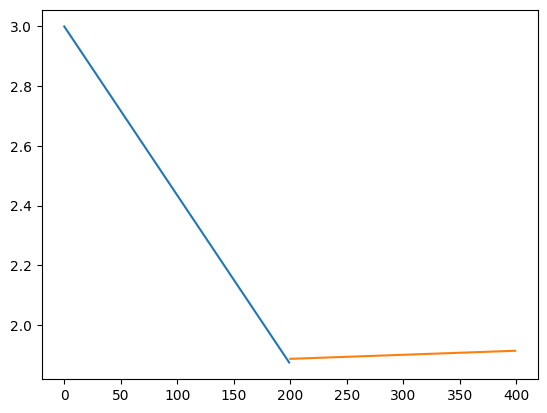

In [23]:
#plt.plot(values)
plt.plot([0,199],[3,values[199]])
plt.plot([200,399],[values[200],values[399]])
#plt.plot([0,199],[3,values[199]])
#plt.plot([0,199],[3,values[199]])
#plt.plot([0,199],[3,values[199]])
#plt.plot([0,199],[3,values[199]])
#plt.plot([0,199],[3,values[199]])
#plt.plot([0,199],[3,values[199]])
print(values[199])
print(values[399])
print(values[599])
print(values[668])
print(values[868])
print(values[1068])
print(values[1268])
print(values[1468])

end_list = [jnp.array([[3.0]]),values[199],values[399],values[599],values[668],values[868],values[1068],values[1268]]

In [24]:
end_list 

[Array([[3.]], dtype=float32),
 1.8748358,
 1.9140682,
 2.033071,
 1.8545785,
 1.9648844,
 1.7766172,
 2.0042126]

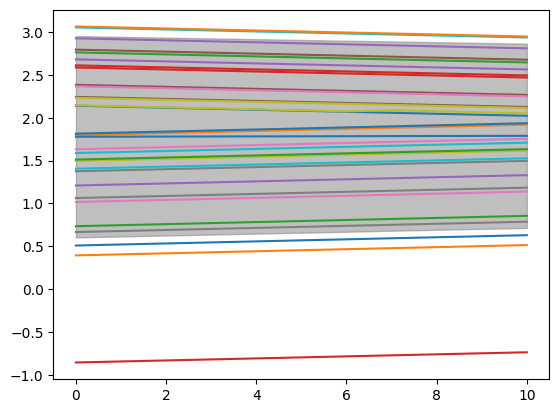

In [19]:
# 绘图

ensemble_tractory = loaded_list[2]

for i in range(ensemble_size):
    plt.plot(ensemble_tractory[i,:])

ensemble_mean = np.mean(ensemble_tractory,axis=0)
ensemble_var = np.var(ensemble_tractory,axis=0)
plt.plot(ensemble_mean)
plt.fill_between(np.arange(11), ensemble_mean - ensemble_std , ensemble_mean + ensemble_std , color='gray', alpha=0.5, label='1 std dev')
#plt.plot(ensemble_mean+ensemble_var/2)
#plt.plot(ensemble_mean-ensemble_var/2)

0.008169249121061317
0.009844092385650094
0.014666866369242193
0.007462041268572861
0.020408973144533604
0.00968021122930196
0.010342282565675487
0.01049191201668831


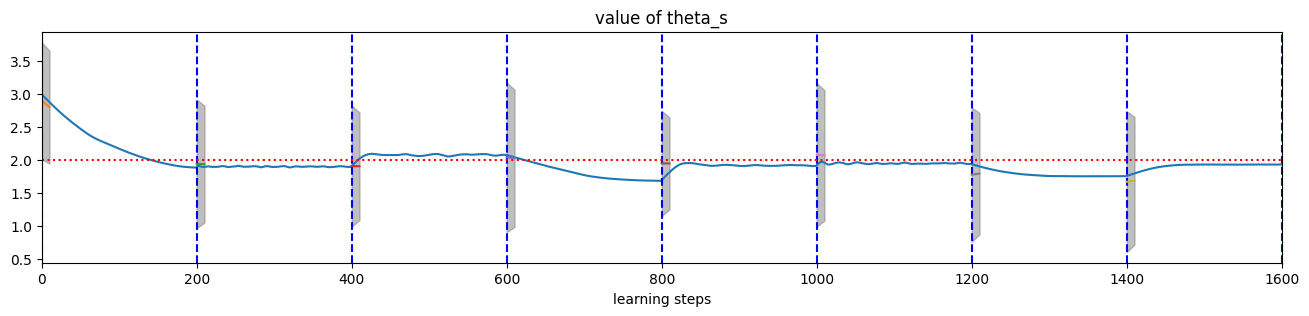

In [13]:
plt.figure(figsize=(16, 3))
plt.plot(values)
plt.axvline(x=0, color='b', linestyle='dashed')
x_value_accum=0
for x_value in count_step_list:
    x_value_accum = x_value_accum+x_value
    plt.axvline(x=x_value_accum, color='b', linestyle='dashed')
    
plt.plot([0,x_value_accum],[2,2],color='r',linestyle=':')

plt.xlabel('learning steps')
#plt.ylabel('theta_s')
plt.xlim([0,len(values)])
plt.title('value of theta_s')


def calculate_kld(mu1, var1, mu2, var2):
    sigma1 = np.sqrt(var1)
    sigma2 = np.sqrt(var2)
    kld = np.log(sigma2 / sigma1) + (var1 + (mu1 - mu2) ** 2) / (2 * var2) - 0.5
    return kld
    
# 绘图

ensemble_tractory = loaded_list[0]


#for i in range(ensemble_size):
#    length_to_plot = len(ensemble_tractory)
#    plt.plot(ensemble_tractory[i,:])

x_value_accum=0
for stage, x_value in enumerate(count_step_list):
    ensemble_tractory = loaded_list[stage]
    length_to_plot = ensemble_tractory.shape[1]
    ensemble_mean = np.mean(ensemble_tractory,axis=0)
    ensemble_var = np.var(ensemble_tractory,axis=0)
    ensemble_std = np.std(ensemble_tractory,axis=0)
    plt.plot(np.arange(length_to_plot)+x_value_accum,ensemble_mean)
    #plt.plot(np.arange(length_to_plot)+x_value_accum,ensemble_mean+np.sqrt(ensemble_var)/2)
    #plt.plot(np.arange(length_to_plot)+x_value_accum,ensemble_mean-np.sqrt(ensemble_var)/2)
    plt.fill_between(np.arange(length_to_plot) + x_value_accum, ensemble_mean - ensemble_std , ensemble_mean + ensemble_std , color='gray', alpha=0.5, label='1 std dev')
    x_value_accum = x_value_accum+x_value
    
    mu1 = np.mean(ensemble_tractory[:,0])
    mu2 = np.mean(ensemble_tractory[:,-1])
    var1 = np.var(ensemble_tractory[:,0])
    var2 = np.var(ensemble_tractory[:,-1])
    
    
    print(calculate_kld(mu1, var1, mu2, var2))

#plt.xlim([599,668])
plt.show()

In [51]:
values[:10]

array([2.9882996, 2.9765828, 2.9648545, 2.953116 , 2.9414184, 2.9297194,
       2.9179826, 2.906244 , 2.8945122, 2.8828492], dtype=float32)

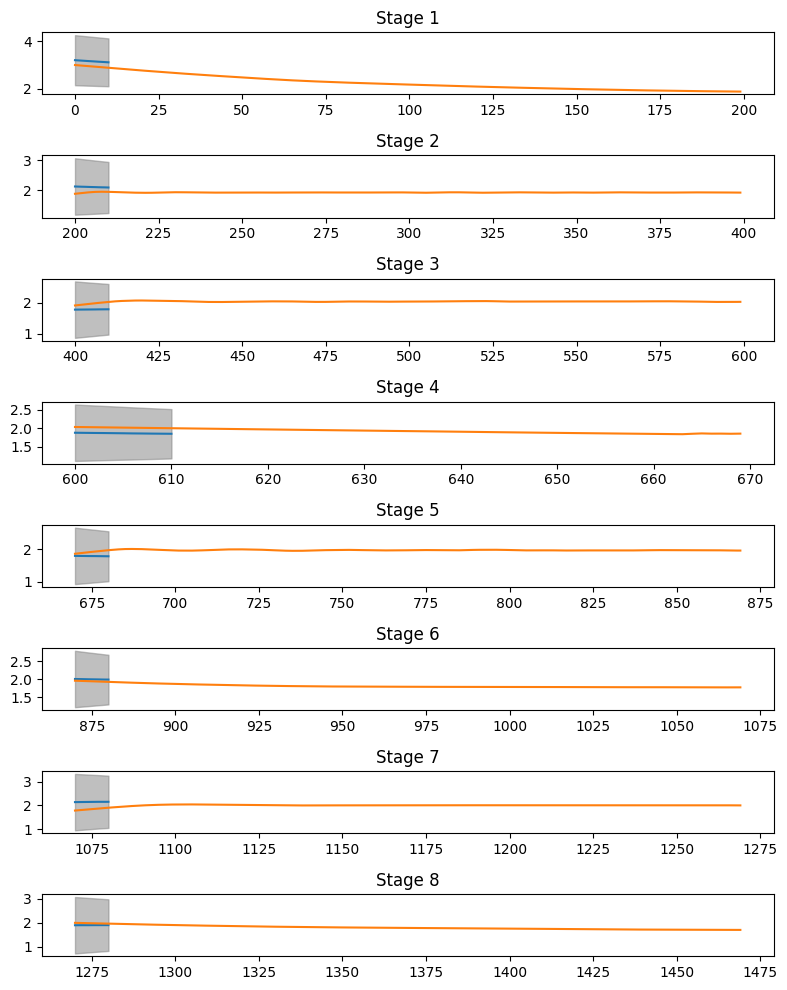

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 loaded_list 和 count_step_list 已经定义和加载
x_value_accum = 0
fig, axs = plt.subplots(8, 1, figsize=(8, 10))  # 设置子图布局为1行8列，可以根据您的实际需要调整尺寸
values_add_initial = np.append([3.0], values)

for stage, (ax, x_value) in enumerate(zip(axs, count_step_list)):
    ensemble_tractory = loaded_list[stage]
    length_to_plot = ensemble_tractory.shape[1]
    ensemble_mean = np.mean(ensemble_tractory, axis=0)
    ensemble_var = np.var(ensemble_tractory, axis=0)
    ensemble_std = np.std(ensemble_tractory, axis=0)
    
    x_indices = np.arange(length_to_plot) + x_value_accum  # 计算X轴的实际位置
    ax.plot(x_indices, ensemble_mean, label='Mean')
    ax.fill_between(x_indices, ensemble_mean - ensemble_std, ensemble_mean + ensemble_std, color='gray', alpha=0.5, label='1 std dev')
    ax.set_title(f"Stage {stage+1}")  # 为每个子图设置标题
    #ax.label_outer()  # 外部标签，优化布局

    ax.plot(np.arange(x_value_accum, x_value_accum+ x_value), values_add_initial[x_value_accum: (x_value_accum+ x_value)])
    x_value_accum += x_value  # 累加X轴的偏移量


fig.tight_layout()  # 自动调整子图参数，以使之填充整个图像区域
plt.show()


In [ ]:
print(combined_array[200:400])

In [ ]:
print(NN_error_list[200:400])

In [ ]:
def summarize_statistics(data):
    """Summarize statistics including mean, median, max, min, standard deviation, coefficient of variation, and quartiles for a numpy array."""
    summary = {
        'Mean': np.mean(data),
        'Median': np.median(data),
        'Max': np.max(data),
        'Min': np.min(data),
        'Standard Deviation': np.std(data),
        'Coefficient of Variation': np.std(data) / np.mean(data) if np.mean(data) != 0 else np.inf,
        '25th Percentile (Q1)': np.percentile(data, 25),
        '75th Percentile (Q3)': np.percentile(data, 75),
        'Interquartile Range (IQR)': np.percentile(data, 75) - np.percentile(data, 25)
    }
    return summary

summarize_statistics(combined_array[200:400])

In [ ]:
print(np.max(np.concatenate(params_detail_list[1500:1600])),np.min(np.concatenate(params_detail_list[1500:1600])))
print(np.max(np.concatenate(params_detail_list[1300:1400])),np.min(np.concatenate(params_detail_list[1300:1400])))
print(np.max(np.concatenate(params_detail_list[1100:1200])),np.min(np.concatenate(params_detail_list[1100:1200])))
print(np.max(np.concatenate(params_detail_list[900:1000])),np.min(np.concatenate(params_detail_list[900:1000])))
print(np.max(np.concatenate(params_detail_list[700:800])),np.min(np.concatenate(params_detail_list[700:800])))

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(np.arange(1000,1200),test_params_grad_list)
plt.plot(np.arange(1000,1200),combined_array[1000:1200])
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(values[1000:1200],label = '')
plt.plot(test_params_list)

In [ ]:
average_theta_xy_list[0:200][0]

In [ ]:
average_theta_xy_list[count_step_list[0]:np.sum(count_step_list[0:2])][0]

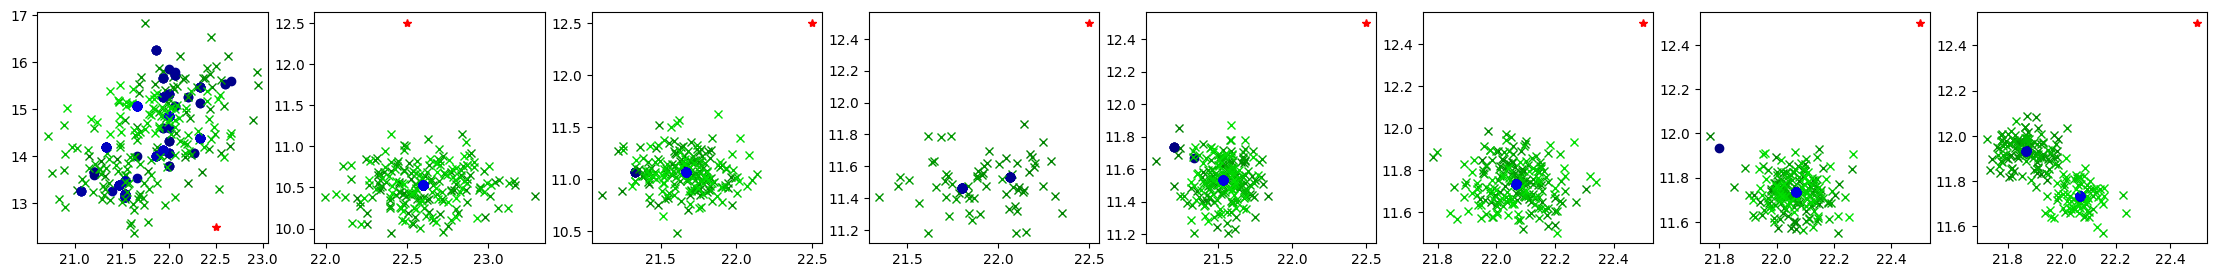

In [36]:
import matplotlib.pyplot as plt

# 定义一个函数来封装重复的绘图逻辑
def plot_coords(coords_list, ax):
    if len(coords_list[0]) == 4:
        for i, coords in enumerate(coords_list, start=1):
            if coords == ['nan']:
                continue
            else:
                x1, y1, x2, y2 = coords
                ax.plot(x1, y1, 'o', color=(0, 0, (250 + i) / 500))
                ax.plot(x2, y2, 'x', color=(0, (250 + i) / 500,0))
    elif len(coords_list[0]) == 3:
        for i, coords in enumerate(coords_list, start=1):
            if coords == ['nan']:
                continue
            else:
                for j in range(3):
                    x1, y1, x2, y2 = coords[j]
                    ax.plot(x1, y1, 'o', color=(0, 0, (250 + i) / 500))
                    ax.plot(x2, y2, 'x', color=(0, (250 + i) / 500,0))
        
                    
            
        

# 创建一个1行3列的子图
fig, axs = plt.subplots(1, len(count_step_list), figsize=(3.5*len(count_step_list), 3))  # 可调整大小以适应显示需求

# 绘制每一部分的坐标数据
plot_coords(average_theta_xy_list[0:count_step_list[0]], axs[0])
plot_coords(average_theta_xy_list[count_step_list[0]:np.sum(count_step_list[0:2])], axs[1])
plot_coords(average_theta_xy_list[np.sum(count_step_list[0:2]):np.sum(count_step_list[0:3])], axs[2])
plot_coords(average_theta_xy_list[np.sum(count_step_list[0:3]):np.sum(count_step_list[0:4])], axs[3])
plot_coords(average_theta_xy_list[np.sum(count_step_list[0:4]):np.sum(count_step_list[0:5])], axs[4])
plot_coords(average_theta_xy_list[np.sum(count_step_list[0:5]):np.sum(count_step_list[0:6])], axs[5])
plot_coords(average_theta_xy_list[np.sum(count_step_list[0:6]):np.sum(count_step_list[0:7])], axs[6])
plot_coords(average_theta_xy_list[np.sum(count_step_list[0:7]):np.sum(count_step_list[0:8])], axs[7])

# 设置每个子图的属性
for ax in axs:
    ax.plot(center[0]*50, center[1]*50, marker='*', color='r')
    #ax.set_xlim([20, 25])
    #ax.set_ylim([10, 15])


#axs[0].set_xlim([20, 25])
#axs[0].plot(center[0]*50, center[1]*50, marker='*', color='r')
plt.show()


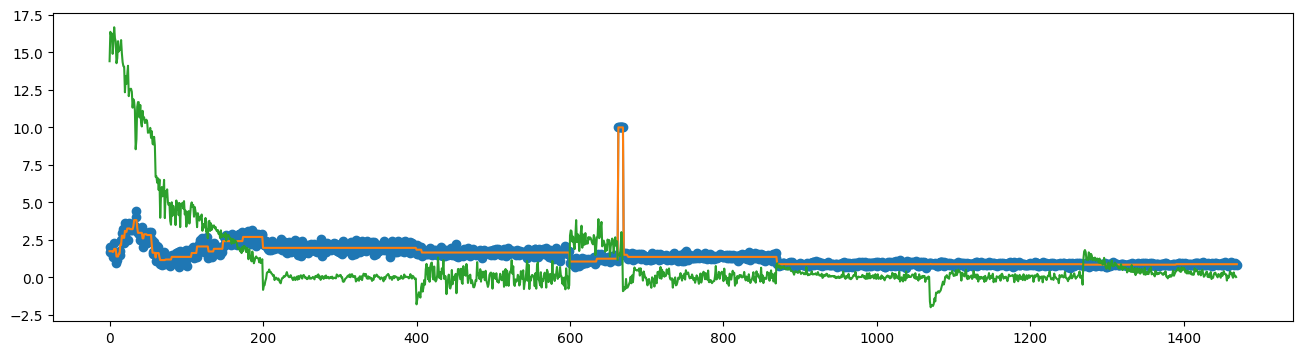

In [37]:
distances = []
distances2 = []
for coords in average_theta_xy_list:
    if coords == ['nan']:
        distance = 10
        distance2 = 10
    else:
        x1, y1, x2, y2 = coords
        distance = np.sqrt((x2-center[0]*50)**2+(y2-center[1]*50)**2)
        distance2 = np.sqrt((x1-center[0]*50)**2+(y1-center[1]*50)**2)
        
    distances.append(distance)
    distances2.append(distance2)

plt.figure(figsize=(16, 4))
plt.plot(distances, marker='o')
plt.plot(distances2)


plt.plot(combined_array)

[-61.712296  -50.461185  -47.3348    -33.01288   -22.426065  -17.898867
  -9.706662   -6.686733    2.6574893  10.63506    16.685179   17.149384
  29.102682   32.91917    40.75425    40.41651    48.47618    52.191654
  49.331226   44.996967   55.72394    57.410374   58.1557     55.785442
  65.44029    65.22906    60.179214   60.924507   73.14807    72.23866
  65.924355 ]
min loss =  -24.037312
corresponding parameter value  1.8000002


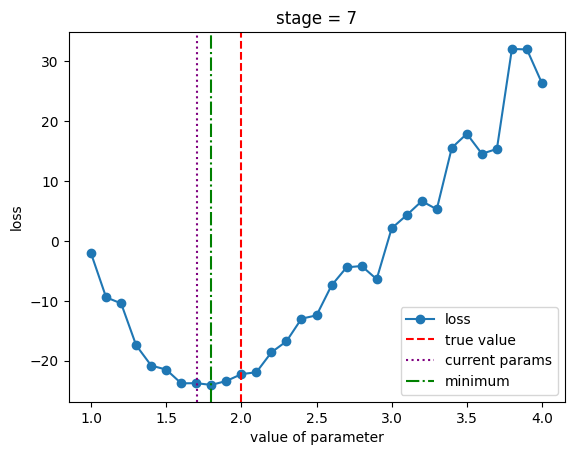

In [38]:
params_array = jnp.arange(1, 4.1, 0.1)  # [0, 4]范围内每隔0.2取值
#params_array = jnp.array([0.0,0.4,0.8,1.2,1.4,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,])

# 生成key数组
key2 = random.PRNGKey(2024)
key_test_grad = random.split(key2, len(params_array))

# 使用for循环计算损失和梯度
losses = []
grads = []
loss_and_grad_func = jax.value_and_grad(loss_params, argnums=0)
for i, param in enumerate(params_array):
    loss, grad = loss_and_grad_func(param, d_start, stage, center, prior, noise_info, num_d, radio_d, key_test_grad[i], theta_true, num_top)
    losses.append(loss)
    grads.append(grad)
    
    del loss, grad
    import gc
    gc.collect()

# 转换回JAX数组（如果需要）
losses = jnp.array(losses)
grads = jnp.array(grads)

plt.plot(params_array,losses,marker='o',label='loss')
plt.axvline([2],color = 'r',linestyle='--',label='true value')
plt.xlabel('value of parameter')
plt.ylabel('loss')
plt.title(f'stage = {stage}')
print(grads)

losses_np = np.array(losses)  # 如果losses不是Numpy数组，将其转换为一个

# 找到最小值
min_loss = np.min(losses_np)

# 找到最小值的索引
min_index = np.argmin(losses_np)

plt.axvline(current_params,color = 'purple',linestyle=':', label='current params')
plt.axvline(params_array[min_index],color = 'g',linestyle='-.', label='minimum')
plt.legend()
print('min loss = ', min_loss)
print('corresponding parameter value ', params_array[min_index])

In [ ]:
stage = 0
d_start = jnp.array([0.45414057,0.3])
prior_ori = jnp.ones((xb_size,xb_size))
prior = prior_ori/jnp.sum(prior_ori)
current_params = jnp.array([3.0])

loglikelihood = calculate_loglikelihood(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[0], theta_true)
log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
indices = jnp.argpartition(log_evidence_list.ravel(), -num_top)[-num_top:]
multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)

In [ ]:
multi_indices

In [ ]:
grid_x_plot0[multi_indices[0][0],multi_indices[1][0]]

In [ ]:
plt.contourf(jnp.exp(log_evidence_list).T, levels=100)
plt.plot(center[0]*50,center[1]*50,marker='*',color='r')
for i in range(num_array[stage]):
    plt.plot(50*grid_y_plot0[multi_indices[0][i],multi_indices[1][i]],50*grid_x_plot0[multi_indices[0][i],multi_indices[1][i]],marker='o',color='purple')

key_local = random.split(key[0],2)
    
    # 计算平均坐标
average_x = np.mean(multi_indices[0])
average_y = np.mean(multi_indices[1])

noise_level = 1.0

average_x_purterbed = average_x+jax.random.normal(key_local[0], average_x.shape)*noise_level
average_y_purterbed = average_y+jax.random.normal(key_local[1], average_y.shape)*noise_level

plt.plot(average_x, average_y, marker='^',color='orange')
plt.plot(average_x_purterbed, average_y_purterbed, marker='x',color='orange')
plt.xlim([10,30])
plt.ylim([5,25])

In [ ]:
posterior_list[0].shape

In [ ]:
# 调查为什么第三个阶段突然梯度快速波动
#def loss_params_average_refine(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, theta_true, num_top, observation):
#    # 找到了evidence最大的几个点，然后把他们的index取平均值，在loglikelihood中插值
#    # 在前面进行测量，这里只进行模拟就行
#    
#    loglikelihood = calculate_loglikelihood_refine(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, theta_true, observation)
#    log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
#    indices = jnp.argpartition(log_evidence_list.ravel(), -num_top)[-num_top:]
#    multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)
#
#    # 计算平均坐标
#    average_x = np.mean(multi_indices[0])
#    average_y = np.mean(multi_indices[1])
#    
#    # 直接使用平均坐标
#    #selected_loglikelihoods = jax.scipy.ndimage.map_coordinates(loglikelihood,[average_x,average_y],1)
#
#    # 扰动
#    key_local = random.split(key,2)
#    
#    noise_level = 0.3
#    
#    average_x_purterbed = average_x+jax.random.normal(key_local[0], average_x.shape)*noise_level
#    average_y_purterbed = average_y+jax.random.normal(key_local[1], average_y.shape)*noise_level
#    
#    
#    selected_loglikelihoods = jax.scipy.ndimage.map_coordinates(loglikelihood,[average_x_purterbed,average_y_purterbed],1)
#    return -selected_loglikelihoods
    
current_params = jnp.array([1.8105186])
print('current_params = ', current_params)
stage = 1
prior = posterior_list[0]
key_for_param = random.split(key[stage*2+1],iteration_step_number2[stage])

lr_schedule2 = create_decay_schedule(learning_rate2[stage], 10, 0.98)
tx2 = optax.chain(
        optax.sgd(lr_schedule2),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
        #optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
    )
opt_state2 = tx2.init(current_params)

output_point, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
observation = output_point

%time loss, grad_params = jax.value_and_grad(loss_params_average_refine)(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_for_param[3], theta_true, num_top, observation)
print('loss = ', loss, ', grad = ', grad_params)
updates, opt_state2 = tx2.update(grad_params, opt_state2, params=current_params)
new_params = optax.apply_updates(current_params, updates)
print('opt_state2 = ', opt_state2)
print('updates = ', updates)
print('new_params = ', new_params)

In [ ]:
stage = 2
print('stage = ', stage)
current_params = jnp.array([1.8965776])
#current_params = params_at_stage_end_list[stage-1]
print('current_params = ', current_params)
prior = posterior_list[stage-1]
key_for_design = random.split(key[stage*2],iteration_step_number1[stage])
key_for_param = random.split(key[stage*2+1],iteration_step_number2[stage])
d_start = jnp.array([0.42396033,0.29897714])

# 首先手动完成oed的更新后验过程

_, posterior = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], theta_true)
del prior
prior = posterior

lr_schedule2 = create_decay_schedule(learning_rate2[stage], 10, 0.98)
tx2 = optax.chain(
        optax.sgd(lr_schedule2),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
        #optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
    )
opt_state2 = tx2.init(current_params)

output_point, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
observation = output_point

print('observation = ', observation)
        
%time loss_return, grad_params = jax.value_and_grad(loss_params_average_refine,has_aux=True)(current_params, d_start, stage, center, prior, noise_info_local, num_d, radio_d, key_for_param[0], theta_true, num_top, observation)
        
print('loss = ', loss_return[0], ', grad = ', grad_params)
updates, opt_state2 = tx2.update(grad_params, opt_state2, params=current_params)
new_params = optax.apply_updates(current_params, updates)
print('opt_state2 = ', opt_state2)
print('updates = ', updates)
print('new_params = ', new_params)



stage = 1
print('\nstage = ', stage)
current_params = jnp.array([1.7974879])
#current_params = params_at_stage_end_list[stage-1]
print('current_params = ', current_params)
prior = posterior_list[stage-1]
key_for_design = random.split(key[stage*2],iteration_step_number1[stage])
key_for_param = random.split(key[stage*2+1],iteration_step_number2[stage])
d_start = jnp.array([0.44821715,0.22246502])

_, posterior = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], theta_true)
del prior
prior = posterior

lr_schedule2 = create_decay_schedule(learning_rate2[stage], 10, 0.98)
tx2 = optax.chain(
        optax.sgd(lr_schedule2),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
        #optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
    )
opt_state2 = tx2.init(current_params)

output_point, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
observation = output_point
        
print('observation = ', observation)

%time loss_return, grad_params = jax.value_and_grad(loss_params_average_refine,has_aux=True)(current_params, d_start, stage, center, prior, noise_info_local, num_d, radio_d, key_for_param[0], theta_true, num_top, observation)
        
print('loss = ', loss_return[0], ', grad = ', grad_params)
updates, opt_state2 = tx2.update(grad_params, opt_state2, params=current_params)
new_params = optax.apply_updates(current_params, updates)
print('opt_state2 = ', opt_state2)
print('updates = ', updates)
print('new_params = ', new_params)

In [ ]:
#结论：这个倒数看起来没有差很多

In [ ]:
# 检查likelihood。如果不行就需要跟踪循环了
# 突然想到了，输出的loss就是likelihood。测量值没差多少，observation =  0.6423271 & 0.6484254。loss也没差多少：loss =  -1.4327302 , grad =  [-1.8640722] & loss =  -1.4760706 , grad =  [-1.8290784]
# 只能跟踪循环内看看是怎么回事


stage = 1
print('\nstage = ', stage)
current_params = jnp.array([1.7974879])
#current_params = params_at_stage_end_list[stage-1]
print('current_params = ', current_params)
prior = posterior_list[stage-1]
key_for_design = random.split(key[stage*2],iteration_step_number1[stage])
key_for_param = random.split(key[stage*2+1],iteration_step_number2[stage])
d_start = jnp.array([0.44821715,0.22246502])

# 首先手动完成oed的更新后验过程

_, posterior = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], theta_true)
del prior
prior = posterior

lr_schedule2 = create_decay_schedule(learning_rate2[stage], 10, 0.98)
tx2 = optax.chain(
        optax.sgd(lr_schedule2),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
        #optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
    )
opt_state2 = tx2.init(current_params)

output_point, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
observation = output_point

loglikelihood = calculate_loglikelihood_refine(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_for_param[0], theta_true, observation)
plt.contourf(loglikelihood.T)
plt.plot(center[0]*50,center[1]*50,marker = 'o',color = 'b')
plt.show()
print('max of loglikelihood = ', jnp.max(loglikelihood), ', mean of loglikelihood = ', jnp.mean(loglikelihood))

num_top = 15
log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
indices = jnp.argpartition(log_evidence_list.ravel(), -num_top)[-num_top:]
multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)

average_x = np.mean(multi_indices[0])
average_y = np.mean(multi_indices[1])


key_local = random.split(key_for_param[0],2)

noise_level = 0.3

average_x_purterbed = average_x+jax.random.normal(key_local[0], average_x.shape)*noise_level
average_y_purterbed = average_y+jax.random.normal(key_local[1], average_y.shape)*noise_level

selected_loglikelihoods = jax.scipy.ndimage.map_coordinates(loglikelihood,[average_x_purterbed,average_y_purterbed],1)

print([average_x, average_y, average_x_purterbed, average_y_purterbed])
print('loss (selected_loglikelihoods) = ', selected_loglikelihoods)

In [ ]:
stage = 2
print('stage = ', stage)
current_params = jnp.array([1.8965776])
#current_params = params_at_stage_end_list[stage-1]
print('current_params = ', current_params)
prior = posterior_list[stage-1]
key_for_design = random.split(key[stage*2],iteration_step_number1[stage])
key_for_param = random.split(key[stage*2+1],iteration_step_number2[stage])
d_start = jnp.array([0.42396033,0.29897714])

# 首先手动完成oed的更新后验过程

_, posterior = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], theta_true)
del prior
prior = posterior

lr_schedule2 = create_decay_schedule(learning_rate2[stage], 10, 0.98)
tx2 = optax.chain(
        optax.sgd(lr_schedule2),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
        #optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
    )
opt_state2 = tx2.init(current_params)

output_point, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
observation = output_point

loglikelihood = calculate_loglikelihood_refine(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_for_param[0], theta_true, observation)
plt.contourf(loglikelihood.T)
plt.plot(center[0]*50,center[1]*50,marker = 'o',color = 'b')
plt.show()
print('max of loglikelihood = ', jnp.max(loglikelihood), ', mean of loglikelihood = ', jnp.mean(loglikelihood))

num_top = 15
log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
indices = jnp.argpartition(log_evidence_list.ravel(), -num_top)[-num_top:]
multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)

average_x = np.mean(multi_indices[0])
average_y = np.mean(multi_indices[1])


key_local = random.split(key_for_param[0],2)

noise_level = 0.3

average_x_purterbed = average_x+jax.random.normal(key_local[0], average_x.shape)*noise_level
average_y_purterbed = average_y+jax.random.normal(key_local[1], average_y.shape)*noise_level

selected_loglikelihoods = jax.scipy.ndimage.map_coordinates(loglikelihood,[average_x_purterbed,average_y_purterbed],1)

print([average_x, average_y, average_x_purterbed, average_y_purterbed])
print('loss (selected_loglikelihoods) = ', selected_loglikelihoods)

In [ ]:
 stage =  0 

start learning design
start design :  [0.5 0.5]
Stopping iteration at step 17 as clip function has been activated 5 times.
Execution learning design time: 32.73649477958679 seconds
Current design: [0.46308923 0.3       ]
start optimazing design for model correction
........................................................................................................................................................................................................

design for model correction :  [0.46308923 0.3       ]
Execution learning param time: 265.26879024505615 seconds
current theta_s: [[1.9047214]]

 stage =  1 

start learning design
start design :  [0.46308923 0.3       ]
Execution learning design time: 68.80124187469482 seconds
Current design: [0.46426058 0.22533645]
start optimazing design for model correction
........................................................................................................................................................................................................

design for model correction :  [0.46426058 0.22533645]
Execution learning param time: 268.50914907455444 seconds
current theta_s: [[1.9336519]]

 stage =  2 

start learning design
start design :  [0.46426058 0.22533645]
Execution learning design time: 70.4743926525116 seconds
Current design: [0.41108927 0.2961028 ]
start optimazing design for model correction
........................................................................................................................................................................................................

design for model correction :  [0.41108927 0.2961028 ]
Execution learning param time: 282.6629500389099 seconds
current theta_s: [[2.0482006]]

In [ ]:
# 尝试使用unnormalized posterior作为目标函数

def loss_params_average_refine_unnormal_posterior(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, theta_true, num_top, observation):
    # 找到了evidence最大的几个点，然后把他们的index取平均值，在loglikelihood中插值
    # 在前面进行测量，这里只进行模拟就行
    
    loglikelihood = calculate_loglikelihood_refine(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, theta_true, observation)
    log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
    indices = jnp.argpartition(log_evidence_list.ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)

    # 计算平均坐标
    average_x = np.mean(multi_indices[0])
    average_y = np.mean(multi_indices[1])
    
    # 直接使用平均坐标
    #selected_loglikelihoods = jax.scipy.ndimage.map_coordinates(loglikelihood,[average_x,average_y],1)

    # 扰动
    key_local = random.split(key,2)

    noise_level = 0.3
    #if stage < 8:
    #    noise_level = 0.3*0.95**stage
    #else:
    #    noise_level = 0.3*0.95**8
    
    average_x_purterbed = average_x+jax.random.normal(key_local[0], average_x.shape)*noise_level
    average_y_purterbed = average_y+jax.random.normal(key_local[1], average_y.shape)*noise_level
    
    
    selected_loglikelihoods = jax.scipy.ndimage.map_coordinates(log_evidence_list ,[average_x_purterbed,average_y_purterbed],1)

    list_local = [average_x, average_y, average_x_purterbed, average_y_purterbed]
    return -selected_loglikelihoods, list_local

stage = 2
print('stage = ', stage)
current_params = jnp.array([1.9336519])
#current_params = params_at_stage_end_list[stage-1]
print('current_params = ', current_params)
prior = posterior_list[stage-1]
key_for_design = random.split(key[stage*2],iteration_step_number1[stage])
key_for_param = random.split(key[stage*2+1],iteration_step_number2[stage])
d_start = jnp.array([0.41108927,0.2961028 ])

# 首先手动完成oed的更新后验过程

_, posterior = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], theta_true)
del prior
prior = posterior

lr_schedule2 = create_decay_schedule(learning_rate2[stage], 10, 0.98)
tx2 = optax.chain(
        optax.adam(lr_schedule2),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
        #optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
    )
opt_state2 = tx2.init(current_params)

output_point, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
observation = output_point

print('observation = ', observation)
num_top = 15
noise_level = 0.3

test_params_list3 = []
test_params_grad_list3 = []
test_percentage_list3 = []
test_loglikelihood_list3 = []
average_theta_xy_list3 = []
test_params_list.append(current_params)

for i in range(iteration_step_number2[stage]):
    loglikelihood = calculate_loglikelihood_refine(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_for_param[i], theta_true, observation)
    test_loglikelihood_list3.append(loglikelihood)
    
    log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
    indices = jnp.argpartition(log_evidence_list.ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)
    
    average_x = np.mean(multi_indices[0])
    average_y = np.mean(multi_indices[1])
    
    
    key_local = random.split(key_for_param[0],2)
    
    
    average_x_purterbed = average_x+jax.random.normal(key_local[0], average_x.shape)*noise_level
    average_y_purterbed = average_y+jax.random.normal(key_local[1], average_y.shape)*noise_level
    
    selected_loglikelihoods = jax.scipy.ndimage.map_coordinates(loglikelihood,[average_x_purterbed,average_y_purterbed],1)
    
#    print('max of loglikelihood = ', jnp.max(loglikelihood), ', mean of loglikelihood = ', jnp.mean(loglikelihood), ', loss (selected_loglikelihoods) = ', selected_loglikelihoods, '. percent = ', selected_loglikelihoods/jnp.max(loglikelihood))
#    print([average_x, average_y, average_x_purterbed, average_y_purterbed])


    loss_return, grad_params = jax.value_and_grad(loss_params_average_refine_unnormal_posterior,has_aux=True)(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_for_param[i], theta_true, num_top, observation)
#    print('grad_params = ', grad_params)
    updates, opt_state2 = tx2.update(grad_params, opt_state2, params=current_params)

    updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
    if updates_contain_nans:
        noise = 0.01*jax.random.normal(key_for_param[i], current_params.shape)
        print('NaN appears in learning. Perturb params and continue. The previos design is ',current_params,'. noise is ', noise)
        current_params = current_params+ noise
        average_theta_xy_list3.append(['nan'])
    else:
        current_params = optax.apply_updates(current_params, updates)
#        print('\n')
        average_theta_xy_list3.append(loss_return[1])


    test_params_list3.append(current_params)
    test_params_grad_list3.append(grad_params)
    test_percentage_list3.append(selected_loglikelihoods/jnp.max(loglikelihood))

#plt.figure(figsize=(16, 4))
#plt.plot(test_percentage_list)
#plt.figure(figsize=(16, 4))
#plt.plot(test_params_grad_list)
#plt.figure(figsize=(16, 4))
#plt.plot(test_params_list)

In [ ]:
# 尝试使用unnormalized posterior作为目标函数

def loss_params_average_refine_unnormal_posterior(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, theta_true, num_top, observation):
    # 找到了evidence最大的几个点，然后把他们的index取平均值，在loglikelihood中插值
    # 在前面进行测量，这里只进行模拟就行
    
    loglikelihood = calculate_loglikelihood_refine(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, theta_true, observation)
    log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
    indices = jnp.argpartition(log_evidence_list.ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)

    # 计算平均坐标
    average_x = np.mean(multi_indices[0])
    average_y = np.mean(multi_indices[1])
    
    # 直接使用平均坐标
    #selected_loglikelihoods = jax.scipy.ndimage.map_coordinates(loglikelihood,[average_x,average_y],1)

    # 扰动
    key_local = random.split(key,2)

    noise_level = 0.3
    #if stage < 8:
    #    noise_level = 0.3*0.95**stage
    #else:
    #    noise_level = 0.3*0.95**8
    
    average_x_purterbed = average_x+jax.random.normal(key_local[0], average_x.shape)*noise_level
    average_y_purterbed = average_y+jax.random.normal(key_local[1], average_y.shape)*noise_level
    
    
    selected_loglikelihoods = jax.scipy.ndimage.map_coordinates(log_evidence_list ,[average_x_purterbed,average_y_purterbed],1)

    list_local = [average_x, average_y, average_x_purterbed, average_y_purterbed]
    return -selected_loglikelihoods, list_local

stage = 1
print('\nstage = ', stage)
current_params = jnp.array([1.9047214])
#current_params = params_at_stage_end_list[stage-1]
print('current_params = ', current_params)
prior = posterior_list[stage-1]
key_for_design = random.split(key[stage*2],iteration_step_number1[stage])
key_for_param = random.split(key[stage*2+1],iteration_step_number2[stage])
d_start = jnp.array([0.46426058,0.22533645])

# 首先手动完成oed的更新后验过程

_, posterior = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], theta_true)
del prior
prior = posterior

lr_schedule2 = create_decay_schedule(learning_rate2[stage], 10, 0.98)
tx2 = optax.chain(
        optax.adam(lr_schedule2),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
        #optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
    )
opt_state2 = tx2.init(current_params)

output_point, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
observation = output_point

print('observation = ', observation)
num_top = 15
noise_level = 0.3

test_params_list4 = []
test_params_grad_list4 = []
test_percentage_list4 = []
test_loglikelihood_list4 = []
average_theta_xy_list4 = []
test_params_list4.append(current_params)

for i in range(iteration_step_number2[stage]):
    loglikelihood = calculate_loglikelihood_refine(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_for_param[i], theta_true, observation)
    test_loglikelihood_list4.append(loglikelihood)
    
    log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
    indices = jnp.argpartition(log_evidence_list.ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)
    
    average_x = np.mean(multi_indices[0])
    average_y = np.mean(multi_indices[1])
    
    
    key_local = random.split(key_for_param[0],2)
    
    
    average_x_purterbed = average_x+jax.random.normal(key_local[0], average_x.shape)*noise_level
    average_y_purterbed = average_y+jax.random.normal(key_local[1], average_y.shape)*noise_level
    
    selected_loglikelihoods = jax.scipy.ndimage.map_coordinates(loglikelihood,[average_x_purterbed,average_y_purterbed],1)
    
#    print('max of loglikelihood = ', jnp.max(loglikelihood), ', mean of loglikelihood = ', jnp.mean(loglikelihood), ', loss (selected_loglikelihoods) = ', selected_loglikelihoods, '. percent = ', selected_loglikelihoods/jnp.max(loglikelihood))
#    print([average_x, average_y, average_x_purterbed, average_y_purterbed])


    loss_return, grad_params = jax.value_and_grad(loss_params_average_refine_unnormal_posterior,has_aux=True)(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_for_param[i], theta_true, num_top, observation)
#    print('grad_params = ', grad_params)
    updates, opt_state2 = tx2.update(grad_params, opt_state2, params=current_params)

    updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
    if updates_contain_nans:
        noise = 0.01*jax.random.normal(key_for_param[i], current_params.shape)
        print('NaN appears in learning. Perturb params and continue. The previos design is ',current_params,'. noise is ', noise)
        current_params = current_params+ noise
        average_theta_xy_list4.append(['nan'])
    else:
        current_params = optax.apply_updates(current_params, updates)
#        print('\n')
        average_theta_xy_list4.append(loss_return[1])


    test_params_list4.append(current_params)
    test_params_grad_list4.append(grad_params)
    test_percentage_list4.append(selected_loglikelihoods/jnp.max(loglikelihood))

#plt.figure(figsize=(16, 4))
#plt.plot(test_percentage_list)
#plt.figure(figsize=(16, 4))
#plt.plot(test_params_grad_list)
#plt.figure(figsize=(16, 4))
#plt.plot(test_params_list)

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(test_percentage_list4)
plt.figure(figsize=(16, 4))
plt.plot(test_params_grad_list4)
plt.figure(figsize=(16, 4))
plt.plot(test_params_list4)

In [ ]:
stage = 2
print('stage = ', stage)
current_params = jnp.array([1.9336519])
#current_params = params_at_stage_end_list[stage-1]
print('current_params = ', current_params)
prior = posterior_list[stage-1]
key_for_design = random.split(key[stage*2],iteration_step_number1[stage])
key_for_param = random.split(key[stage*2+1],iteration_step_number2[stage])
d_start = jnp.array([0.41108927,0.2961028 ])

# 首先手动完成oed的更新后验过程

_, posterior = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], theta_true)
del prior
prior = posterior

lr_schedule2 = create_decay_schedule(learning_rate2[stage], 10, 0.98)
tx2 = optax.chain(
        optax.adam(lr_schedule2),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
        #optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
    )
opt_state2 = tx2.init(current_params)

output_point, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
observation = output_point

print('observation = ', observation)
num_top = 15
noise_level = 0.3

test_params_list = []
test_params_grad_list = []
test_percentage_list = []
test_loglikelihood_list = []
test_params_list.append(current_params)

for i in range(iteration_step_number2[stage]):
    loglikelihood = calculate_loglikelihood_refine(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_for_param[i], theta_true, observation)
    test_loglikelihood_list.append(loglikelihood)
    
    log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
    indices = jnp.argpartition(log_evidence_list.ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)
    
    average_x = np.mean(multi_indices[0])
    average_y = np.mean(multi_indices[1])
    
    
    key_local = random.split(key_for_param[0],2)
    
    
    average_x_purterbed = average_x+jax.random.normal(key_local[0], average_x.shape)*noise_level
    average_y_purterbed = average_y+jax.random.normal(key_local[1], average_y.shape)*noise_level
    
    selected_loglikelihoods = jax.scipy.ndimage.map_coordinates(loglikelihood,[average_x_purterbed,average_y_purterbed],1)
    
#    print('max of loglikelihood = ', jnp.max(loglikelihood), ', mean of loglikelihood = ', jnp.mean(loglikelihood), ', loss (selected_loglikelihoods) = ', selected_loglikelihoods, '. percent = ', selected_loglikelihoods/jnp.max(loglikelihood))
#    print([average_x, average_y, average_x_purterbed, average_y_purterbed])


    loss_return, grad_params = jax.value_and_grad(loss_params_average_refine,has_aux=True)(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_for_param[i], theta_true, num_top, observation)
#    print('grad_params = ', grad_params)
    updates, opt_state2 = tx2.update(grad_params, opt_state2, params=current_params)

    updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
    if updates_contain_nans:
        noise = 0.01*jax.random.normal(key_for_param[i], current_params.shape)
        print('NaN appears in learning. Perturb params and continue. The previos design is ',current_params,'. noise is ', noise)
        current_params = current_params+ noise
        average_theta_xy_list.append(['nan'])
    else:
        current_params = optax.apply_updates(current_params, updates)
#        print('\n')
        average_theta_xy_list.append(loss_return[1])


    test_params_list.append(current_params)
    test_params_grad_list.append(grad_params)
    test_percentage_list.append(selected_loglikelihoods/jnp.max(loglikelihood))

plt.figure(figsize=(16, 4))
plt.plot(test_percentage_list)
plt.figure(figsize=(16, 4))
plt.plot(test_params_grad_list)
plt.figure(figsize=(16, 4))
plt.plot(test_params_list)

In [ ]:
stage = 1
print('\nstage = ', stage)
current_params = jnp.array([1.9047214])
#current_params = params_at_stage_end_list[stage-1]
print('current_params = ', current_params)
prior = posterior_list[stage-1]
key_for_design = random.split(key[stage*2],iteration_step_number1[stage])
key_for_param = random.split(key[stage*2+1],iteration_step_number2[stage])
d_start = jnp.array([0.46426058,0.22533645])

# 首先手动完成oed的更新后验过程

_, posterior = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], theta_true)
del prior
prior = posterior

lr_schedule2 = create_decay_schedule(learning_rate2[stage], 10, 0.98)
tx2 = optax.chain(
        optax.sgd(lr_schedule2),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
        #optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
    )
opt_state2 = tx2.init(current_params)

output_point, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
observation = output_point

print('observation = ', observation)
num_top = 15
noise_level = 0.3

test_params_list2 = []
test_params_grad_list2 = []
test_percentage_list2 = []
test_loglikelihood_list = []
test_params_list2.append(current_params)

for i in range(iteration_step_number2[stage]):
    loglikelihood = calculate_loglikelihood_refine(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_for_param[i], theta_true, observation)
    test_loglikelihood_list.append(loglikelihood)
    
    log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
    indices = jnp.argpartition(log_evidence_list.ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)
    
    average_x = np.mean(multi_indices[0])
    average_y = np.mean(multi_indices[1])
    
    
    key_local = random.split(key_for_param[0],2)
    
    
    average_x_purterbed = average_x+jax.random.normal(key_local[0], average_x.shape)*noise_level
    average_y_purterbed = average_y+jax.random.normal(key_local[1], average_y.shape)*noise_level
    
    selected_loglikelihoods = jax.scipy.ndimage.map_coordinates(loglikelihood,[average_x_purterbed,average_y_purterbed],1)
    
#    print('max of loglikelihood = ', jnp.max(loglikelihood), ', mean of loglikelihood = ', jnp.mean(loglikelihood), ', loss (selected_loglikelihoods) = ', selected_loglikelihoods, '. percent = ', selected_loglikelihoods/jnp.max(loglikelihood))
#    print([average_x, average_y, average_x_purterbed, average_y_purterbed])


    loss_return, grad_params = jax.value_and_grad(loss_params_average_refine,has_aux=True)(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_for_param[i], theta_true, num_top, observation)
#    print('grad_params = ', grad_params)
    updates, opt_state2 = tx2.update(grad_params, opt_state2, params=current_params)

    updates_contain_nans = any(jnp.any(jnp.isnan(u)) for u in jax.tree_util.tree_leaves(updates))
    if updates_contain_nans:
        noise = 0.01*jax.random.normal(key_for_param[i], current_params.shape)
        print('NaN appears in learning. Perturb params and continue. The previos design is ',current_params,'. noise is ', noise)
        current_params = current_params+ noise
        average_theta_xy_list.append(['nan'])
    else:
        current_params = optax.apply_updates(current_params, updates)
#        print('\n')
        average_theta_xy_list.append(loss_return[1])


    test_params_list2.append(current_params)
    test_params_grad_list2.append(grad_params)
    test_percentage_list2.append(selected_loglikelihoods/jnp.max(loglikelihood))

plt.figure(figsize=(16, 4))
plt.plot(test_percentage_list2)
plt.figure(figsize=(16, 4))
plt.plot(test_params_grad_list2)
plt.figure(figsize=(16, 4))
plt.plot(test_params_list2)

In [ ]:
plt.figure(figsize=(12, 3))
plt.plot(test_percentage_list, label='staeg 2')
plt.plot(test_percentage_list2, label='staeg 1')
plt.xlabel('iterations in the stage')
plt.ylabel('the picked likelihood / max likelihood')
plt.legend()
plt.figure(figsize=(12, 3))
plt.plot(test_params_grad_list, label='staeg 2')
plt.plot(test_params_grad_list2, label='staeg 1')
plt.plot(test_params_grad_list3, label='staeg 2 optimize with posterior')
plt.plot(test_params_grad_list4, label='staeg 1 optimize with posterior')
plt.xlabel('iterations in the stage')
plt.ylabel('gradient of loss to error parameter')
plt.legend()
plt.figure(figsize=(12, 3))
plt.plot(test_params_list, label='stage 2')
plt.plot(test_params_list2, label='stage 1')
plt.xlabel('iterations in the stage')
plt.ylabel('value of error parameter')
plt.legend()

In [ ]:
plt.figure(figsize=(12, 3))
plt.plot(test_params_grad_list, label='staeg 2')
plt.plot(test_params_grad_list2, label='staeg 1')
plt.xlabel('iterations in the stage')
plt.ylabel('gradient of loss to error parameter')
plt.axvline(57, linestyle = ':', color='r')
plt.legend()

In [ ]:
type(loglikelihood)

In [ ]:
# 比较 选出的那个theta_xy对应的位置，以及likelihood的峰值

stage = 2
print('stage = ', stage)
current_params = jnp.array([1.9336519])
#current_params = params_at_stage_end_list[stage-1]
print('current_params = ', current_params)
prior = posterior_list[stage-1]
key_for_design = random.split(key[stage*2],iteration_step_number1[stage])
key_for_param = random.split(key[stage*2+1],iteration_step_number2[stage])
d_start = jnp.array([0.41108927,0.2961028 ])

# 首先手动完成oed的更新后验过程

_, posterior = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], theta_true)
del prior
prior = posterior

output_point, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
observation = output_point

num_top = 15
noise_level = 0.3

i = 57
loglikelihood = calculate_loglikelihood_refine(test_params_list[i], d_start, stage, center, prior, noise_info, num_d, radio_d, key_for_param[i], theta_true, observation)

log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
indices = jnp.argpartition(log_evidence_list.ravel(), -num_top)[-num_top:]
multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)

average_x = np.mean(multi_indices[0])
average_y = np.mean(multi_indices[1])


key_local = random.split(key_for_param[0],2)


average_x_purterbed = average_x+jax.random.normal(key_local[0], average_x.shape)*noise_level
average_y_purterbed = average_y+jax.random.normal(key_local[1], average_y.shape)*noise_level

center_of_likelihood_x, center_of_likelihood_y = jnp.unravel_index(jnp.argmax(loglikelihood),loglikelihood.shape)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# 第一个子图
ax = axs[0]
contour = ax.contourf(loglikelihood.T, levels=70)
fig.colorbar(contour, ax=ax)
ax.plot(average_x, average_y, 'o', color='r')
ax.plot(average_x_purterbed, average_y_purterbed, 'x', color='r')
ax.plot(center_of_likelihood_x, center_of_likelihood_y, '*', color='r')

# 第二个子图
ax = axs[1]
x = np.arange(21) + 10
y = np.arange(21) + 5
X, Y = np.meshgrid(x, y)
contour = ax.contourf(X, Y, loglikelihood[10:31, 5:26].T, levels=70)
fig.colorbar(contour, ax=ax)
ax.plot(average_x, average_y, 'o', color='g',label='guess center')
ax.plot(average_x_purterbed, average_y_purterbed, 'x', color='green',label='purterbed guess center')
ax.plot(center_of_likelihood_x, center_of_likelihood_y, '*', color='r', label = 'updated information')
ax.plot(center[0]*50, center[1]*50, '*', color='b', label = 'true center')
ax.legend()

fig, axs = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={'projection': '3d'})
# 第三个子图 (3D)
x = np.arange(loglikelihood.shape[1])
y = np.arange(loglikelihood.shape[0])
X, Y = np.meshgrid(x, y)
ax = axs[0]
surf = ax.plot_surface(X, Y, loglikelihood.T, cmap='viridis')
fig.colorbar(surf, ax=ax, shrink=0.5)

# 第四个子图 (3D)
ax = axs[1]
x = np.arange(21) + 10
y = np.arange(21) + 5
X, Y = np.meshgrid(x, y)
surf = ax.plot_surface(X, Y, loglikelihood[10:31, 5:26].T, cmap='viridis')
fig.colorbar(surf, ax=ax, shrink=0.5)

# 调整布局并显示
plt.tight_layout()
plt.show()

In [ ]:
# 比较 选出的那个theta_xy对应的位置，以及likelihood的峰值

stage = 1
print('\nstage = ', stage)
current_params = jnp.array([1.9047214])
#current_params = params_at_stage_end_list[stage-1]
print('current_params = ', current_params)
prior = posterior_list[stage-1]
key_for_design = random.split(key[stage*2],iteration_step_number1[stage])
key_for_param = random.split(key[stage*2+1],iteration_step_number2[stage])
d_start = jnp.array([0.46426058,0.22533645])

# 首先手动完成oed的更新后验过程

_, posterior = forward_posterior_infoGain(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key[stage], theta_true)
del prior
prior = posterior

output_point, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
observation = output_point

num_top = 15
noise_level = 0.3

i = 57
loglikelihood = calculate_loglikelihood_refine(test_params_list[i], d_start, stage, center, prior, noise_info, num_d, radio_d, key_for_param[i], theta_true, observation)

log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
indices = jnp.argpartition(log_evidence_list.ravel(), -num_top)[-num_top:]
multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)

average_x = np.mean(multi_indices[0])
average_y = np.mean(multi_indices[1])


key_local = random.split(key_for_param[0],2)


average_x_purterbed = average_x+jax.random.normal(key_local[0], average_x.shape)*noise_level
average_y_purterbed = average_y+jax.random.normal(key_local[1], average_y.shape)*noise_level

center_of_likelihood_x, center_of_likelihood_y = jnp.unravel_index(jnp.argmax(loglikelihood),loglikelihood.shape)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# 第一个子图
ax = axs[0]
contour = ax.contourf(loglikelihood.T, levels=70)
fig.colorbar(contour, ax=ax)
ax.plot(average_x, average_y, 'o', color='r')
ax.plot(average_x_purterbed, average_y_purterbed, 'x', color='r')
ax.plot(center_of_likelihood_x, center_of_likelihood_y, '*', color='r')

# 第二个子图
ax = axs[1]
x = np.arange(21) + 10
y = np.arange(21) + 5
X, Y = np.meshgrid(x, y)
contour = ax.contourf(X, Y, loglikelihood[10:31, 5:26].T, levels=70)
fig.colorbar(contour, ax=ax)
ax.plot(average_x, average_y, 'o', color='g',label='guess center')
ax.plot(average_x_purterbed, average_y_purterbed, 'x', color='green',label='purterbed guess center')
ax.plot(center_of_likelihood_x, center_of_likelihood_y, '*', color='r', label = 'updated information')
ax.plot(center[0]*50, center[1]*50, '*', color='b', label = 'true center')
ax.legend()

fig, axs = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={'projection': '3d'})
# 第三个子图 (3D)
x = np.arange(loglikelihood.shape[1])
y = np.arange(loglikelihood.shape[0])
X, Y = np.meshgrid(x, y)
ax = axs[0]
surf = ax.plot_surface(X, Y, loglikelihood.T, cmap='viridis')
fig.colorbar(surf, ax=ax, shrink=0.5)

# 第四个子图 (3D)
ax = axs[1]
x = np.arange(21) + 10
y = np.arange(21) + 5
X, Y = np.meshgrid(x, y)
surf = ax.plot_surface(X, Y, loglikelihood[10:31, 5:26].T, cmap='viridis')
fig.colorbar(surf, ax=ax, shrink=0.5)

# 调整布局并显示
plt.tight_layout()
plt.show()

In [ ]:
def loss_params_average_refine(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, theta_true, num_top, observation):
    # 找到了evidence最大的几个点，然后把他们的index取平均值，在loglikelihood中插值
    # 在前面进行测量，这里只进行模拟就行
    
    loglikelihood = calculate_loglikelihood_refine(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, theta_true, observation)
    log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
    indices = jnp.argpartition(log_evidence_list.ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)

    # 计算平均坐标
    average_x = np.mean(multi_indices[0])
    average_y = np.mean(multi_indices[1])
    
    # 扰动
    key_local = random.split(key,2)
    
    noise_level = 0.3
    
    average_x_purterbed = average_x+jax.random.normal(key_local[0], average_x.shape)*noise_level
    average_y_purterbed = average_y+jax.random.normal(key_local[1], average_y.shape)*noise_level
    
    
    selected_loglikelihoods = jax.scipy.ndimage.map_coordinates(loglikelihood,[average_x_purterbed,average_y_purterbed],1)

    list_local = [average_x, average_y, average_x_purterbed, average_y_purterbed]
    return -selected_loglikelihoods, list_local


def calculate_loglikelihood_refine(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, theta_true, observation):
    '''
    参数：
    stage: 当前的阶段。用于决定forward模拟的步数
    center: 污染源的中心
    current_params: 网络的参数
    d_start: 测量点
    prior: 先验
    noise_info: 测量误差设置
    num_d: 计算后验时使用的点数
    radio_d: 在测量点附近多选几个点测量，本质上可以理解为多次测量消除误差，可以考虑直接舍弃误差

    说明：
    1，假设数据量是300*300，计算范围是3*3
    应该是需要数据尺寸是3的倍数，否则到时候后验那里也会费劲
    也可以不是3的倍数，只要后验矩阵和数据矩阵匹配就行
    2，运用了等效的原则。主要起作用的是测量点和center的相对位置
    这里突然想到nn应该需要四个参数，当前的坐标和center，而不是仅当前坐标。
    '''
    noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]
    if num_d == 1.0:
        # 给一个函数，从所有的输出中找到关心的点
        false_center = jnp.array([1.0,1.0]) - d_start
        false_start = jnp.array([0.5, 0.5])
        #_, output_all = sealed_convection_diffusion_nn(current_params, false_start, false_center, stage, model)
        _, output_all  = sealed_convection_diffusion_exp_parametic(false_start, false_center, stage, current_params)
        #output_all_central_sym = output_all.T
        output_all_central_sym = jnp.fliplr(jnp.flipud(output_all))
        # 取出[0,1]^2之间的矩阵
        xb_lo = int((0.0 - lo_b) / (up_b - lo_b) * (size - 1))
        xb_up = int((1.0 - lo_b) / (up_b - lo_b) * (size - 1))
        output_for_xb = output_all_central_sym[xb_lo:(xb_up+1),xb_lo:(xb_up+1)]
        # 针对于每一个数字求likelihood
        loglikelihood = jax.scipy.stats.norm.logpdf(output_for_xb, loc=observation, scale=noise_base_scale+noise_ratio_scale*observation)
    return loglikelihood

In [ ]:
opt_state2 = tx2.init(current_params)
updates, opt_state2 = tx2.update(jnp.array([-20.8490174]), opt_state2, params=current_params)
new_params = optax.apply_updates(current_params, updates)
print('opt_state2 = ', opt_state2)
print('updates = ', updates)
print('new_params = ', new_params)

In [ ]:
key_local = random.split(key_for_param[0], 2)
jax.random.normal(key_local[0], average_x.shape)*noise_level, jax.random.normal(key_local[1], average_y.shape)*noise_level

In [ ]:
key_local = random.split(key_for_param[1], 2)
jax.random.normal(key_local[0], average_x.shape)*noise_level, jax.random.normal(key_local[1], average_y.shape)*noise_level

In [ ]:
plt.contourf(grid_x_plot0, grid_y_plot0,  jnp.exp(log_evidence_list).T, levels=100)
plt.plot(center[0],center[1],marker='*',color='r')
for i in range(num_array[stage]):
    plt.plot(grid_y_plot0[multi_indices[0][i],multi_indices[1][i]],grid_x_plot0[multi_indices[0][i],multi_indices[1][i]],marker='o',color='purple')

x_coords = grid_x_plot0[multi_indices[0], multi_indices[1]]
y_coords = grid_y_plot0[multi_indices[0], multi_indices[1]]

# 计算平均坐标
average_x = np.mean(x_coords)
average_y = np.mean(y_coords)

key_local = random.split(key[0],2)

noise_level = 0.01

average_x_purterbed = average_x+jax.random.normal(key_local[0], average_x.shape)*noise_level
average_y_purterbed = average_y+jax.random.normal(key_local[1], average_y.shape)*noise_level

plt.plot(average_y, average_x, marker='^',color='orange')
plt.plot(average_y_purterbed, average_x_purterbed, marker='x',color='orange')
plt.xlim([0.2,0.6])
plt.ylim([0.18,0.3])

In [ ]:
log_evidence_list[16,14]

In [ ]:
jax.scipy.ndimage.map_coordinates(log_evidence_list,[16,14],1)

In [ ]:
log_evidence_list.shape

In [ ]:
lr_schedule2 = create_decay_schedule(learning_rate2[stage], 5, 0.98)
tx2 = optax.chain(
    optax.adam(lr_schedule2),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
    optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
)

opt_state2 = tx2.init(current_params)
loss, grad_params = jax.value_and_grad(loss_params)(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_for_param[i], theta_true, num_top)
updates, opt_state2 = tx2.update(grad_params, opt_state2, params=current_params)
print('grad_params = ', grad_params)
print('updates = ', updates)

In [ ]:
def loss_params_average(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, theta_true, num_top):
    # 找到了evidence最大的几个点，然后把他们的index取平均值，在loglikelihood中插值
    loglikelihood = calculate_loglikelihood(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, theta_true)
    log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
    indices = jnp.argpartition(log_evidence_list.ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)

    # 计算平均坐标
    average_x = np.mean(multi_indices[0])
    average_y = np.mean(multi_indices[1])

    selected_loglikelihoods = jax.scipy.ndimage.map_coordinates(loglikelihood,[average_x,average_y],1)
    return -selected_loglikelihoods
    
def calculate_loglikelihood_advanced(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, theta_true):
    '''
    参数：
    stage: 当前的阶段。用于决定forward模拟的步数
    center: 污染源的中心
    current_params: 网络的参数
    d_start: 测量点
    prior: 先验
    noise_info: 测量误差设置
    num_d: 计算后验时使用的点数
    radio_d: 在测量点附近多选几个点测量，本质上可以理解为多次测量消除误差，可以考虑直接舍弃误差

    说明：
    1，假设数据量是300*300，计算范围是3*3
    应该是需要数据尺寸是3的倍数，否则到时候后验那里也会费劲
    也可以不是3的倍数，只要后验矩阵和数据矩阵匹配就行
    2，运用了等效的原则。主要起作用的是测量点和center的相对位置
    这里突然想到nn应该需要四个参数，当前的坐标和center，而不是仅当前坐标。
    '''
    noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]
    if num_d == 1.0:
        #output_point, _ = sealed_convection_diffusion_true(d_start, center, stage) #这里的形状是()
        output_point, _ = sealed_convection_diffusion_exp_parametic(d_start, center, stage, theta_true)
        #output_point = jax.lax.stop_gradient(output_point)
        #key, subkey = random.split(key) 这一步放在外面
        
        ##暂时只考虑不要误差的情况：
        #observation = output_point + jnp.array([0.0])

        #这是要误差的代码：
        noise = random.normal(key,(1,1))*(noise_base_scale+output_point*noise_ratio_scale) #形状(1,1)
        observation = output_point + noise*0.1

        # 给一个函数，从所有的输出中找到关心的点
        false_center = jnp.array([1.0,1.0]) - d_start
        false_start = jnp.array([0.5, 0.5])
        #_, output_all = sealed_convection_diffusion_nn(current_params, false_start, false_center, stage, model)
        _, output_all  = sealed_convection_diffusion_exp_parametic(false_start, false_center, stage, current_params)
        #output_all_central_sym = output_all.T
        output_all_central_sym = jnp.fliplr(jnp.flipud(output_all))
        # 取出[0,1]^2之间的矩阵
        xb_lo = int((0.0 - lo_b) / (up_b - lo_b) * (size - 1))
        xb_up = int((1.0 - lo_b) / (up_b - lo_b) * (size - 1))
        output_for_xb = output_all_central_sym[xb_lo:(xb_up+1),xb_lo:(xb_up+1)]
        # 针对于每一个数字求likelihood
        loglikelihood = jax.scipy.stats.norm.logpdf(output_for_xb, loc=observation, scale=noise_base_scale+noise_ratio_scale*observation)
    return loglikelihood, observation


def loss_params_average_2(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, theta_true, num_top):
    # 找到了evidence最大的几个点，然后把他们的坐标取平均值，重新算likelihood
    loglikelihood, observation = calculate_loglikelihood_advanced(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key, theta_true)
    log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
    indices = jnp.argpartition(log_evidence_list.ravel(), -num_top)[-num_top:]
    multi_indices = jnp.unravel_index(indices, log_evidence_list.shape)

    x_coords = grid_x_plot0[multi_indices[0], multi_indices[1]]
    y_coords = grid_y_plot0[multi_indices[0], multi_indices[1]]
    
    # 计算平均坐标
    average_x = np.mean(x_coords)
    average_y = np.mean(y_coords)

    parameter_to_evaluate = jnp.array([average_x,average_y])
    noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]
    data,_ = sealed_convection_diffusion_exp_parametic(parameter_to_evaluate, d_start, stage, current_params)
    selected_loglikelihoods = jax.scipy.stats.norm.logpdf(data, loc=observation, scale=noise_base_scale+noise_ratio_scale*observation)
    return -selected_loglikelihoods[0][0]

lr_schedule2 = create_decay_schedule(learning_rate2[stage], 5, 0.98)

tx2 = optax.chain(
    optax.adam(lr_schedule2),  # 使用由 lr_schedule1 调整的学习率的 Adam 优化器
    optax.add_decayed_weights(1e-4)  # 添加权重衰减，衰减系数为 1e-5
)

print('current_params = ', current_params)

opt_state2 = tx2.init(current_params)
%time loss, grad_params = jax.value_and_grad(loss_params)(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_for_param[i], theta_true, num_top)
updates, opt_state2 = tx2.update(grad_params, opt_state2, params=current_params)
new_params = optax.apply_updates(current_params, updates)
print('updates = ', updates)
print('new_params = ', new_params)

opt_state2 = tx2.init(current_params)
%time loss, grad_params = jax.value_and_grad(loss_params_average)(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_for_param[i], theta_true, num_top)
updates, opt_state2 = tx2.update(grad_params, opt_state2, params=current_params)
new_params = optax.apply_updates(current_params, updates)
print('updates = ', updates)
print('new_params = ', new_params)

opt_state2 = tx2.init(current_params)
%time loss, grad_params = jax.value_and_grad(loss_params_average_2)(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_for_param[i], theta_true, num_top)
updates, opt_state2 = tx2.update(grad_params, opt_state2, params=current_params)
new_params = optax.apply_updates(current_params, updates)
print('updates = ', updates)
print('new_params = ', new_params)

In [ ]:
# key concludion: 给选出的值取平均的效果在初始时候比较好

In [ ]:
opt_state2

In [ ]:
loglikelihood, observation = calculate_loglikelihood_advanced(current_params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_for_param[i], theta_true)

x_coords = grid_x_plot0[multi_indices[0], multi_indices[1]]
y_coords = grid_y_plot0[multi_indices[0], multi_indices[1]]

# 计算平均坐标
average_x = np.mean(x_coords)
average_y = np.mean(y_coords)
parameter_to_evaluate = jnp.array([average_x,average_y])
noise_loc, noise_base_scale, noise_ratio_scale = noise_info[0]
data,_ = sealed_convection_diffusion_exp_parametic(parameter_to_evaluate, d_start, stage, current_params)
selected_loglikelihoods = jax.scipy.stats.norm.logpdf(data, loc=observation, scale=noise_base_scale+noise_ratio_scale*observation)

In [ ]:
selected_loglikelihoods[0][0]

In [ ]:
multi_indices

In [ ]:
x_coords = grid_x_plot0[multi_indices[0], multi_indices[1]]
y_coords = grid_y_plot0[multi_indices[0], multi_indices[1]]
    
# 计算平均坐标
average_x = np.mean(x_coords)
average_y = np.mean(y_coords)

print(average_x )

In [ ]:
print("平均 X 坐标:", average_x)
print("平均 Y 坐标:", average_y)

In [ ]:
a=jnp.array([[1,2,3],[4,5,6],[7,8,9]])
print(a)
jax.scipy.ndimage.map_coordinates(a,[0,1],1)

In [ ]:
jnp.mean(multi_indices[0])/50,jnp.mean(multi_indices[1])/50

In [ ]:
params_array = jnp.arange(1, 4.1, 0.1)  # [0, 4]范围内每隔0.2取值
#params_array = jnp.array([0.0,0.4,0.8,1.2,1.4,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,])

# 生成key数组
key2 = random.PRNGKey(2024)
key_test_grad = random.split(key2, len(params_array))

# 使用for循环计算损失和梯度
losses = []
grads = []
loss_and_grad_func = jax.value_and_grad(loss_params, argnums=0)
for i, param in enumerate(params_array):
    loss, grad = loss_and_grad_func(param, d_start, stage, center, prior, noise_info, num_d, radio_d, key_test_grad[i], theta_true, num_top)
    losses.append(loss)
    grads.append(grad)
    
    del loss, grad
    import gc
    gc.collect()

# 转换回JAX数组（如果需要）
losses = jnp.array(losses)
grads = jnp.array(grads)

plt.plot(params_array,losses,marker='o',label='loss')
plt.axvline([2],color = 'r',linestyle='--',label='true value')
plt.xlabel('value of parameter')
plt.ylabel('loss')
plt.title(f'stage = {stage}')
print(grads)

losses_np = np.array(losses)  # 如果losses不是Numpy数组，将其转换为一个

# 找到最小值
min_loss = np.min(losses_np)

# 找到最小值的索引
min_index = np.argmin(losses_np)

plt.axvline(current_params,color = 'purple',linestyle=':', label='current params')
plt.axvline(params_array[min_index],color = 'g',linestyle='-.', label='minimum')
plt.legend()
print('min loss = ', min_loss)
print('corresponding parameter value ', params_array[min_index])

In [ ]:
# 检验correction 结果
values = [item[0][0] for item in params_list]
plt.plot(values)
plt.axvline(x=0, color='b', linestyle='dashed')
x_value_accum=0
for x_value in iteration_step_number2[0:-1]:
    x_value_accum = x_value_accum+x_value
    plt.axvline(x=x_value_accum, color='b', linestyle='dashed')

plt.xlabel('learning steps')
plt.ylabel('theta_s')
plt.show()

plt.plot(NN_error_list)
plt.show()

In [ ]:
params_array = jnp.arange(0, 4.1, 0.4)  # [0, 4]范围内每隔0.1取值


# 为每个current_params生成对应的key数组
key_size = (params_array.shape[0], 2)  # 假设每个key是一个由2个元素组成的数组
key2 = random.PRNGKey(2024)
key_test_grad = random.split(key2,len(params_array))
batched_loss_grad = jax.vmap(jax.value_and_grad(loss_params, argnums=0),
                         in_axes=(0, None, None, None, None, None, None, None, 0, None, None))

# 计算所有current_params的值及其梯度
losses, grads = batched_loss_grad(params_array, d_start, stage, center, prior, noise_info, num_d, radio_d, key_test_grad, theta_true, 15)




plt.plot(params_array,losses)
plt.xlabel('value of parameter')
plt.ylabel('loss')
print(grads)

In [ ]:
adjoint_posterior_array_np = np.array(posterior_list)
file_path = "fine_posterior.npy"
np.save(file_path, adjoint_posterior_array_np)

In [ ]:
import numpy as np
import jax.numpy as jnp

# 定义文件路径
#file_path = "adjoint_posterior.npy"

# 读取保存的数组
#adjoint_posterior_array_np = np.load(file_path)

n_stage =7
local_size = 51
center = jnp.array([0.25,0.25])

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

fig, axes = plt.subplots(1, n_stage, figsize=(5*n_stage, 4.5))
grid_x_plot0, grid_y_plot0 = np.meshgrid(np.linspace(0, 1, local_size), np.linspace(0, 1, local_size))

def custom_formatter(x, pos):
    if x == 0.0:
        return '  0.0'  # 向右移动
    elif x == 1.0:
        return '1.0  '  # 向左移动
    else:
        return f'{x:.1f}'
        
fontsize = 20

for stage in range(n_stage):
    d_start = design_list[stage+1]
    d_start_backup = design_list[stage]
    contour=axes[stage].contourf(grid_x_plot0, grid_y_plot0, adjoint_posterior_array_np[stage,:,:], levels=100,cmap='RdYlBu_r' )
    axes[stage].scatter(d_start[0], d_start[1], marker='o', s=100, c='orangered')
    axes[stage].scatter(center[0], center[1], marker='*', s=100, c='magenta')
    axes[stage].plot([d_start[0],d_start_backup[0]],
                    [d_start[1],d_start_backup[1]], c='orangered')
    axes[stage].set_title(f'stage {stage}, t = {((stage+1)*0.05):.2f} s', fontsize=fontsize)  # 设置子图的标题
    axes[stage].set_xlabel('z_x', fontsize=fontsize)  # 设置x轴标签
    if stage == 0:
        axes[stage].set_ylabel('z_y', fontsize=fontsize)  # 设置y轴标签
    else:
        axes[stage].set_yticklabels([]) 
        
    axes[stage].tick_params(axis='both', which='major', labelsize=fontsize)
    axes[stage].set_xticks([0, 0.5, 1])
    axes[stage].xaxis.set_major_formatter(FuncFormatter(custom_formatter))

        
plt.subplots_adjust(wspace=0.1)
cbar_ax = fig.add_axes([0.51, 1.08, 0.38, 0.05])  # [left, bottom, width, height]
cbar = fig.colorbar(contour, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=fontsize)

plt.plot([], [], marker='*', markersize=10, color='magenta', linestyle='None', label='true source location')
plt.plot([], [], marker='o', markersize=10, color='orangered', linestyle='None', label='current measure place')
plt.plot([], [], marker='*', markersize=10, color='magenta', linestyle='None', label='true parameter value')
plt.legend(
    loc='center',
    bbox_to_anchor=(0.3, 1.07),  # 仅调整纵坐标位置，使其离上面远一点，离下面近一点
    ncol=3,
    frameon=True,
    framealpha=1,
    edgecolor='black',
    fontsize=fontsize,
    bbox_transform=fig.transFigure  # 将定位转换为相对于整个图形
)
plt.savefig('adjoint method oed.png',bbox_inches='tight')

In [ ]:

fig, axes = plt.subplots(1, n_stage, figsize=(5*n_stage, 5))

contour=axes[stage].contourf(grid_x_plot0, grid_y_plot0, posterior, levels=100,cmap='RdYlBu_r' )
axes[stage].scatter(d_start[0], d_start[1], marker='o', s=100, c='orangered')
axes[stage].scatter(center[0], center[1], marker='*', s=100, c='magenta')
axes[stage].plot([d_start[0],d_start_backup[0]],[d_start[1],d_start_backup[1]], c='orangered')
axes[stage].set_title(f'stage {stage}, t = {((stage+1)*0.05):.2f} s')  # 设置子图的标题
axes[stage].set_xlabel('z_x')  # 设置x轴标签
axes[stage].set_ylabel('z_y')  # 设置y轴标签

cbar_ax = fig.add_axes([0.5, 0.96, 0.3, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(contour, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=8)

plt.plot([], [], marker='*', markersize=10, color='magenta', linestyle='None', label='true source location')
plt.plot([], [], marker='o', markersize=10, color='orangered', linestyle='None', label='current measure place')
plt.plot([], [], marker='*', markersize=10, color='magenta', linestyle='None', label='true parameter value')
plt.legend(
    loc='center',
    bbox_to_anchor=(0.33, 0.96),  # 仅调整纵坐标位置，使其离上面远一点，离下面近一点
    ncol=3,
    frameon=True,
    framealpha=1,
    edgecolor='black',
    fontsize=12,
    bbox_transform=fig.transFigure  # 将定位转换为相对于整个图形
)

plt.savefig('legend and colorvar.png',dpi=600)

In [ ]:

# 创建一个空的图形
fig, ax = plt.subplots(figsize=(8, 2))

# 隐藏轴
ax.axis('off')

# 创建一个虚拟的颜色映射
cmap = plt.cm.RdYlBu_r
norm = plt.Normalize(vmin=0, vmax=1)

# 创建 colorbar
cbar_ax = fig.add_axes([0.1, 0.3, 0.8, 0.4])  # [left, bottom, width, height]
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=8)

# 创建图例
plt.plot([], [], marker='*', markersize=10, color='magenta', linestyle='None', label='true source location')
plt.plot([], [], marker='o', markersize=10, color='orangered', linestyle='None', label='current measure place')
plt.plot([], [], marker='*', markersize=10, color='magenta', linestyle='None', label='true parameter value')
plt.legend(
    loc='center',
    bbox_to_anchor=(0.5, -0.2),  # 调整图例的位置
    ncol=3,
    frameon=True,
    framealpha=1,
    edgecolor='black',
    fontsize=12,
    bbox_transform=fig.transFigure  # 将定位转换为相对于整个图形
)

plt.subplots_adjust(bottom=0.4)  # 调整底部边距以适应 colorbar 和图例

plt.show()


In [ ]:

def show_nn(params, apply_model, center_x=0, center_y=0, size=85):
    x = jnp.linspace(0, 0.3, size).reshape(-1, 1)
    y = jnp.linspace(0, 0.3, size).reshape(-1, 1)  # Reshape y to match dimensions
    xy_combined = jnp.concatenate((x, y), axis=1)  # Properly form (x, y) pairs
    array_nn = apply_model.apply(params, xy_combined) * 70.0
    exponent_internal = ((x - center_x) ** 2 + (y - center_y) ** 2)
    factor = 2.0 / (2.0 * jnp.pi * 0.05 ** 2)
    array_exponent = factor * jnp.exp(-exponent_internal / (2.0 * 0.05 ** 2))
    array_reciprocal = factor * 1.5 / (exponent_internal ** 2 / (2.0 * 0.05 ** 2) ** 2 + 1.0)
    plt.figure(figsize=(5, 5))
    # Directly use jnp arrays in plotting
    plt.plot(jnp.sqrt(2) * x.squeeze(), 
             (array_nn.squeeze() + array_reciprocal.squeeze()), 
             label='NN + Reciprocal',linestyle='-')
    plt.plot(jnp.sqrt(2) * x.squeeze(), 
             array_exponent.squeeze(), label='Exponent',linestyle='--')
    plt.plot(jnp.sqrt(2) * x.squeeze(), 
             array_reciprocal.squeeze(), label='Reciprocal',linestyle='-.')
    plt.xlabel('input')
    plt.ylabel('output values of model')
    plt.xlabel('Input values of model')
    plt.legend()
    
def show_signle_nn(params, apply_model, center_x=0, center_y=0, size=85):
    x = jnp.linspace(0, 1, size).reshape(-1, 1)
    y = jnp.linspace(0, 1, size).reshape(-1, 1)  # Reshape y to match dimensions
    xy_combined = jnp.concatenate((x, y), axis=1)  # Properly form (x, y) pairs
    array_nn = apply_model.apply(params, xy_combined) * 70.0
    exponent_internal = ((x - center_x) ** 2 + (y - center_y) ** 2)
    factor = 2.0 / (2.0 * jnp.pi * 0.05 ** 2)
    array_exponent = factor * jnp.exp(-exponent_internal / (2.0 * 0.05 ** 2))
    array_reciprocal = factor * 1.5 / (exponent_internal ** 2 / (2.0 * 0.05 ** 2) ** 2 + 1.0)
    plt.figure(figsize=(5, 5))
    # Directly use jnp arrays in plotting
    plt.plot(jnp.sqrt(2) * x.squeeze(), 
             array_nn.squeeze(), 
             label='NN + Reciprocal')
    plt.ylabel('values of NN')
    plt.xlabel('Inputs')
    plt.legend()

show_nn(params, model, center_x=0, center_y=0, size=85)

intersection_x = 0.07
#plt.axvline(x=intersection_x, color='black', linestyle='--')
plt.axvspan(0, intersection_x, color='lightgrey', alpha=0.5)

plt.savefig('newwork shape trained.png', bbox_inches='tight')
plt.show()
#show_signle_nn(params, model, center_x=0, center_y=0, size=85)
show_nn(params_back, model, center_x=0, center_y=0, size=85)
plt.savefig('newwork shape untrained.png', bbox_inches='tight')
plt.show()


def show_nn(params_list, apply_model, center_x=0, center_y=0, size=85):
    x = jnp.linspace(0, 1, size).reshape(-1, 1)
    y = jnp.linspace(0, 1, size).reshape(-1, 1)
    xy_combined = jnp.concatenate((x, y), axis=1)
    
    exponent_internal = ((x - center_x) ** 2 + (y - center_y) ** 2)
    factor = 2.0 / (2.0 * jnp.pi * 0.05 ** 2)
    array_exponent = factor * jnp.exp(-exponent_internal / (2.0 * 0.05 ** 2))
    array_reciprocal = factor * 1.5 / (exponent_internal ** 2 / (2.0 * 0.05 ** 2) ** 2 + 1.0)
    
    plt.figure(figsize=(5, 5))

    for index, params in enumerate(params_list):
        array_nn = apply_model.apply(params, xy_combined) * 70.0
        
        plt.plot(jnp.sqrt(2) * x.squeeze(), 
                 (array_nn.squeeze() + array_reciprocal.squeeze()), 
                 label=f'NN + Reciprocal - Params {index+1}')
    
    plt.plot(jnp.sqrt(2) * x.squeeze(), 
             array_exponent.squeeze(), label='Exponent')
    plt.plot(jnp.sqrt(2) * x.squeeze(), 
             array_reciprocal.squeeze(), label='Reciprocal')
    
    plt.ylabel('values of model')
    plt.xlabel('Inputs')
    plt.legend()
    plt.show()

def show_signle_nn(params_list, apply_model, center_x=0, center_y=0, size=85):
    x = jnp.linspace(0, 1, size).reshape(-1, 1)
    y = jnp.linspace(0, 1, size).reshape(-1, 1)  # Reshape y to match dimensions
    xy_combined = jnp.concatenate((x, y), axis=1)  # Properly form (x, y) pairs
    
    exponent_internal = ((x - center_x) ** 2 + (y - center_y) ** 2)
    factor = 2.0 / (2.0 * jnp.pi * 0.05 ** 2)
    array_exponent = factor * jnp.exp(-exponent_internal / (2.0 * 0.05 ** 2))
    array_reciprocal = factor * 1.5 / (exponent_internal ** 2 / (2.0 * 0.05 ** 2) ** 2 + 1.0)
    
    plt.figure(figsize=(5, 5))

    for index, params in enumerate(params_list):
        array_nn = apply_model.apply(params, xy_combined) * 70.0
        
        plt.plot(jnp.sqrt(2) * x.squeeze(), 
                 array_nn.squeeze() , 
                 label=f'NN Params {index+1}')
        
    plt.ylabel('values of NN')
    plt.xlabel('Inputs')
    plt.legend()
    plt.show()


show_nn(params_list, model, center_x=0, center_y=0, size=85)
#show_signle_nn(params_list, model, center_x=0, center_y=0, size=85)

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(6*4, 5))
axes[0].plot(KLD_list,label='KLD')
axes[0].set_xlabel('iteration')
axes[0].set_ylabel('KLD values')
axes[1].plot(evidence_list,label='evidence')
axes[1].set_xlabel('iteration')
axes[1].set_ylabel('objective function values')
axes[2].plot(NN_error_list,label='NN_error')
axes[2].set_xlabel('iteration')
axes[2].set_ylabel('error of neural network')
axes[3].plot(gradient_norm_list)
axes[3].set_xlabel('iteration')
axes[3].set_ylabel('gradient of model correction')

In [ ]:
def show_nn(params, apply_model, center_x=0, center_y=0, size=85):
    x = jnp.linspace(0, 1, size).reshape(-1, 1)
    y = jnp.linspace(0, 1, size).reshape(-1, 1)  # Reshape y to match dimensions
    xy_combined = jnp.concatenate((x, y), axis=1)  # Properly form (x, y) pairs
    array_nn = apply_model.apply(params, xy_combined) * 70.0
    exponent_internal = ((x - center_x) ** 2 + (y - center_y) ** 2)
    factor = 2.0 / (2.0 * jnp.pi * 0.05 ** 2)
    array_exponent = factor * jnp.exp(-exponent_internal / (2.0 * 0.05 ** 2))
    array_reciprocal = factor * 1.5 / (exponent_internal ** 2 / (2.0 * 0.05 ** 2) ** 2 + 1.0)
    plt.figure(figsize=(5, 5))
    # Directly use jnp arrays in plotting
    plt.plot(jnp.sqrt(2) * x.squeeze(), 
             (array_nn.squeeze() + array_reciprocal.squeeze()), 
             label='NN + Reciprocal')
    plt.plot(jnp.sqrt(2) * x.squeeze(), 
             array_exponent.squeeze(), label='Exponent')
    plt.plot(jnp.sqrt(2) * x.squeeze(), 
             array_reciprocal.squeeze(), label='Reciprocal')
    plt.legend()
    plt.show()

show_nn(params, model, center_x=0, center_y=0, size=85)

In [ ]:
params = {'params': {'Dense_0': {'bias': jnp.array([-0.3298, -0.1174,  0.6380,  0.3928, -0.7478,  0.5316,  0.1195, -0.5012]),
   'kernel': jnp.array([[ 0.2482, -0.1645,  0.3177,  0.0101,  0.0504,  0.4333,  0.0107,  -0.3257],
       [-0.1137,  0.6302, -0.699 ,  0.0819,  0.2179, -0.0026, -0.0022,  0.2175]])},
  'Dense_1': {'bias': jnp.array([-0.0216,  0.0225, -0.1443, -0.0964]),
   'kernel': jnp.array([[-0.2057, -0.3018, -0.0947,  0.1217],
       [ 0.1769, -0.0451,  0.2394, -0.3284],
       [ 0.1332, -0.189 , -0.1262, -0.2911],
       [-0.1262,  0.0849,  0.2631,  0.1408],
       [ 0.265 , -0.2259, -0.1145,  0.2127],
       [-0.1701, -0.3768, -0.1982, -0.0188],
       [ 0.1154, -0.3425,  0.0138, -0.269 ],
       [-0.1733, -0.2877, -0.4278,  0.0289]])},
  'Dense_2': {'bias': jnp.array([-0.1950]),
   'kernel': jnp.array([[-0.3703],
       [ 0.0758],
       [ 0.1468],
       [-0.2777]])}}}
params

In [ ]:
np.isnan((max_evidence_items, net_accuracy)).any()

In [ ]:
%time negtive_KLD, grad_params = jax.value_and_grad(loss_design)(d_start, params, stage, center, prior, noise_info, num_d, radio_d, key_tem[0], model)
negtive_KLD, grad_params

In [ ]:
%time negtive_KLD, grad_params = jax.value_and_grad(loss_param)(params, d_start, stage, center, prior, noise_info, num_d, radio_d, key_tem[0], model)
grad_params

In [ ]:
stage

In [ ]:
aa= jnp.array([0.1])
b=[]
b.append(-aa)
b.append(aa)
print(aa)
print(net_accuracy)
b

In [ ]:
a=jnp.array([0.2,0.2])
area=jnp.array([0.2,0.2])
a_min=a-area
a_max=a+area
jax.numpy.clip(jnp.array([0.5,0.5]), a_min, a_max, out=None)

In [ ]:
def test_fun(d_start):
    output_point, _ = sealed_convection_diffusion_true(d_start, center, stage) #这里的形状是()
    #key, subkey = random.split(key) 这一步放在外面
    
    #暂时只考虑不要误差的情况：
    observation = output_point + jnp.array([0.0])
    ##这是要误差的代码：
    #noise = random.normal(key,(1,1))*(noise_base_scale+output_point*noise_ratio_scale) #形状(1,1)
    #observation = output_point + noise
    # 给一个函数，从所有的输出中找到关心的点
    false_center = jnp.array([1.0,1.0]) - d_start
    false_start = jnp.array([0.5, 0.5])
    _, output_all = sealed_convection_diffusion_nn(params, false_start, false_center, stage, model)
    output_all_central_sym = jnp.fliplr(jnp.flipud(output_all))
    xb_lo = int((0.0 - lo_b) / (up_b - lo_b) * (size - 1))
    xb_up = int((1.0 - lo_b) / (up_b - lo_b) * (size - 1))
    output_for_xb = output_all_central_sym[xb_lo:(xb_up+1),xb_lo:(xb_up+1)]
    loglikelihood = jax.scipy.stats.norm.logpdf(output_for_xb, loc=output_point, scale=noise_base_scale+noise_ratio_scale*output_point)
    log_evidence_list = log_normalize_pdf(loglikelihood) + jnp.log(prior+1e-32)
    top_15_indices = jnp.argsort(log_evidence_list.ravel())[-15:]  # ravel()将矩阵平铺为一维，argsort()降序排列
    top_15_values = log_evidence_list.ravel()[top_15_indices]
    key = random.PRNGKey(2023)  # 初始化随机种子，你可以设置为其他值
    chosen_indices = random.choice(key, top_15_indices.shape[0], shape=(5,), replace=False)
    chosen_values = top_15_values[chosen_indices]
    return sum(chosen_values)

jax.value_and_grad(test_fun)(d_start)

In [ ]:
top_15_indices = jnp.argsort(evidence_list.ravel())[-15:]  # ravel()将矩阵平铺为一维，argsort()降序排列

top_15_values = evidence_list.ravel()[top_15_indices]

# 随机取出其中5个
key = random.PRNGKey(0)  # 初始化随机种子，你可以设置为其他值
chosen_indices = random.choice(key, top_15_indices.shape[0], shape=(5,), replace=False)

chosen_values = top_15_values[chosen_indices]

In [ ]:
chosen_values

In [ ]:
output_for_xb.shape
import matplotlib.pyplot as plt
grid_x_plot0, grid_y_plot0 = np.meshgrid(np.linspace(0, 1, 85), np.linspace(0, 1, 85))
plt.figure(figsize=(5.5, 4))
plt.contourf(grid_x_plot0, grid_y_plot0, posterior, levels=100,cmap='RdYlBu_r' )
plt.colorbar()
plt.show()

In [ ]:
jax.value_and_grad(sealed_convection_diffusion_true, has_aux=True)(d_start, center, stage)

In [ ]:
jax.value_and_grad(sealed_convection_diffusion_nn, has_aux=True)(params, d_start, center, stage, model)

In [ ]:
key_tem = random.split(key2,3)
key_tem

In [ ]:
d_start = jnp.array([0.21,0.21])
center = jnp.array([0.7,0.7])
%time output1,_=sealed_convection_diffusion(params,d_start,center,3)

In [ ]:
d_start = jnp.array([0.41,0.41])
center = jnp.array([0.9,0.9])
%time output2, op2_ful=sealed_convection_diffusion(params,d_start,center,3)

In [ ]:
print(output1)
print(output2)

In [ ]:
grid = cfd.grids.Grid((size, size), domain=((lo_b, up_b), (lo_b, up_b)))
i = (1-0)/(1-0)*10
grid_x = jnp.linspace(0, 1, 11)
print(i)
print(grid_x)
size

In [ ]:

i = (0.7-lo_b)/(up_b-lo_b)*(size-1)
j = (0.7-lo_b)/(up_b-lo_b)*(size-1)
print(i,j)
type(int(i))
#op2_ful[i,j]

In [ ]:
grid = cfd.grids.Grid((size, size), domain=((0, 1), (0, 1)))
offsets = ((0.5,0.5),(0.5,0.5))
x = grid.mesh(offsets[1])[0]
y = grid.mesh(offsets[0])[1]
exponent_internal = ((x-center_x)**2.0+(y-center_y)**2.0) / (2.0 * 0.05 **2.0)
factor = 2.0 / (2.0 * jnp.pi * 0.05 **2)
array_exponent = factor * jnp.exp(-exponent_internal)
array_reciprocal = factor / (exponent_internal+ 1.0)
target=array_exponent-array_reciprocal

In [ ]:
jnp.max(target)
jnp.min(target)

In [ ]:
xb_lo = int((0.0 - lo_b) / (up_b - lo_b) * (size - 1))
xb_up = int((1.0 - lo_b) / (up_b - lo_b) * (size - 1))
print(xb_lo, xb_up )
grid_x = jnp.linspace(lo_b, up_b, size)
grid_y = jnp.linspace(lo_b, up_b, size)
xx, yy = jnp.meshgrid(grid_x, grid_y, indexing='ij')
print(op2_ful.shape)
need_array=jnp.fliplr(jnp.flipud(op2_ful[xb_lo:(xb_up+1),xb_lo:(xb_up+1)]))
print(need_array.shape)
print(need_array)
print(output2)
pdf_array = jax.scipy.stats.norm.logpdf(need_array, loc=output2, scale=0.05)
print(pdf_array)


import matplotlib.pyplot as plt
grid_x_plot0, grid_y_plot0 = np.meshgrid(np.linspace(-2, 3, size), np.linspace(-2, 3, size))
plt.figure(figsize=(5.5, 4))
plt.contourf(grid_x_plot0, grid_y_plot0, op2_ful, levels=100,cmap='RdYlBu_r' )
plt.colorbar()
plt.show()

grid_x_plot, grid_y_plot = np.meshgrid(np.linspace(0, 1, int((size-1)/5+1)), np.linspace(0, 1, int((size-1)/5+1)))
plt.figure(figsize=(5.5, 4))
plt.contourf(grid_x_plot, grid_y_plot, need_array, levels=100,cmap='RdYlBu_r' )
plt.colorbar()
plt.show()

plt.figure(figsize=(5.5, 4))
plt.contourf(grid_x_plot, grid_y_plot, pdf_array, levels=100,cmap='RdYlBu_r' )
plt.colorbar()
plt.show()

In [ ]:
print(pdf_array)
print(jnp.log(jnp.exp(pdf_array)+1e-32))

In [ ]:
print(jnp.max(need_array))
print(jnp.max(pdf_array))

In [ ]:
data_array=jnp.array([[0,1],[0.3,0.5]])
pdf_array = jax.scipy.stats.norm.pdf(data_array, loc=0, scale=1)
print(pdf_array)
jnp.sum(pdf_array)

In [ ]:
zz=(0.21,0.21)
print(type(zz))
xx=jnp.array([0.21,0.21])
print(type(xx))

In [ ]:
def sum_squared_error(x, y):
  return jnp.sum((x-y)**2)
    
def squared_error_with_aux(x, y):
  return int(sum_squared_error(x, y)), x-y

jax.value_and_grad(squared_error_with_aux, has_aux=True, argnums=(0, 1))(1.0, 2.0)
# 默认对第一个输入参数求导，对第一个输出求导
# 求导默认有两个参数，只能有两个。多的参数不求导数

In [ ]:
def squared_error_with_aux1(x, y):
  return sum_squared_error(x, y), x-y

value, grad = jax.value_and_grad(squared_error_with_aux1, has_aux=True)(1.0, 2.0)

print(value)
print(grad)
print(type(value))
print((grad))

In [ ]:
random.normal(key, (1,10))

In [ ]:
# 学习scan的用法
import jax.numpy as jnp
from jax import random
from jax.scipy.signal import convolve

# 定义卷积操作函数
def convolve_x_with_y(x, y):
    # 假设x和y是一维向量，'valid'表示卷积操作不会超出边界
    result = convolve(x, y, mode='valid')
    return result

# 定义添加噪音的函数
def add_noise_to_y(y, noise_level, key):
    noise = random.normal(key, y.shape) * noise_level
    y_noisy = y + noise
    return y_noisy

# 固定的x向量
x = jnp.array([1, 2, 1])

# 基础的y向量
y_base = jnp.array([0.5, -0.5, 0.5])

# 噪音水平
noise_level = 0.1

# 初始化随机种子
key = random.PRNGKey(0)

# 生成3个不同的随机种子
keys = random.split(key, 3)

# 为了使用vmap，我们需要一个函数，该函数接收单个key和y_base作为输入
def process_single_y(key, y_base):
    y_noisy = add_noise_to_y(y_base, noise_level, key)
    result = convolve_x_with_y(x, y_noisy)
    return result

# 使用vmap向量化处理过程
batched_process = jax.vmap(process_single_y, in_axes=(0, None))

# 执行向量化操作
results = batched_process(keys, y_base)

print("卷积结果：", results)


In [ ]:
import optax
import jax
from typing import Any, Callable, Sequence
from jax import random, numpy as jnp
import flax
from flax import linen as nn

# Set problem dimensions.
n_samples = 20
x_dim = 10
y_dim = 5

# Generate random ground truth W and b.
key = random.key(0)
k1, k2 = random.split(key)
W = random.normal(k1, (x_dim, y_dim))
b = random.normal(k2, (y_dim,))
# Store the parameters in a FrozenDict pytree.
true_params = flax.core.freeze({'params': {'bias': b, 'kernel': W}})

# Generate samples with additional noise.
key_sample, key_noise = random.split(k1)
x_samples = random.normal(key_sample, (n_samples, x_dim))
y_samples = jnp.dot(x_samples, W) + b + 0.1 * random.normal(key_noise,(n_samples, y_dim))
print('x shape:', x_samples.shape, '; y shape:', y_samples.shape)

model = nn.Dense(features=5)

# Initialize the model parameters.
key, subkey = random.split(key)
params_test = model.init(subkey, x_samples[0])

@jax.jit
def mse(params, x_batched, y_batched):
  def squared_error(x, y):
    pred = model.apply(params, x)
    return jnp.inner(y-pred, y-pred) / 2.0
  return jnp.mean(jax.vmap(squared_error)(x_batched,y_batched), axis=0)
    
learning_rate = 0.3  # Gradient step size.
print('Loss for "true" W,b: ', mse(true_params, x_samples, y_samples))

tx = optax.adam(learning_rate=learning_rate)
opt_state = tx.init(params_test)
loss_grad_fn = jax.value_and_grad(mse)

for i in range(101):
  loss_val, grads = loss_grad_fn(params_test, x_samples, y_samples)
  updates, opt_state = tx.update(grads, opt_state)
  params_test = optax.apply_updates(params_test, updates)
  if i % 10 == 0:
    print('Loss step {}: '.format(i), loss_val)

In [ ]:
params_test

In [ ]:
print(type(results))
print(type(y_base))

In [ ]:

# 创建一个示例矩阵
matrix = jnp.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# 首先上下翻转
#flip_ud = jnp.flipud(matrix)

# 然后左右翻转
flip_lr_ud = jnp.fliplr(jnp.flipud(matrix))

print("原始矩阵:\n", matrix)
print("左右和上下翻转后的矩阵:\n", flip_lr_ud)


In [ ]:
print(key)
key, subkey = random.split(key)
print(key)
print(subkey)